## К вам обратился представитель крупного агентства недвижимости со следующей проблемой:

#### «Мои риелторы тратят катастрофически много времени на сортировку объявлений и поиск выгодных предложений. Поэтому их скорость реакции, да и, сказать по правде, качество анализа не дотягивают до уровня конкурентов. Это сказывается на наших финансовых показателях. 

#### Ваша задача — разработать сервис для предсказания стоимости домов на основе истории предложений.

In [160]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import category_encoders as ce

from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn import metrics
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import StackingRegressor

import warnings
warnings.filterwarnings("ignore")

### 1. Загрузка данных

Загрузим датасет

In [161]:
data = pd.read_csv('data/data.csv')
data.head()

status private pool        propertyType               street    baths  \
0    Active          NaN  Single Family Home       240 Heather Ln      3.5   
1  for sale          NaN  single-family home    12911 E Heroy Ave  3 Baths   
2  for sale          NaN  single-family home    2005 Westridge Rd  2 Baths   
3  for sale          NaN  single-family home  4311 Livingston Ave  8 Baths   
4  for sale          NaN            lot/land       1524 Kiscoe St      NaN   

                                           homeFacts fireplace  \
0  {'atAGlanceFacts': [{'factValue': '2019', 'fac...  Gas Logs   
1  {'atAGlanceFacts': [{'factValue': '2019', 'fac...       NaN   
2  {'atAGlanceFacts': [{'factValue': '1961', 'fac...       yes   
3  {'atAGlanceFacts': [{'factValue': '2006', 'fac...       yes   
4  {'atAGlanceFacts': [{'factValue': '', 'factLab...       NaN   

             city                                            schools  \
0  Southern Pines  [{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...   
1  Spokane Valley  [{'rating': ['4/10', 'None/10', '4/10'], 'data...   
2     Los Angeles  [{'rating': ['8/10', '4/10', '8/10'], 'data': ...   
3          Dallas  [{'rating': ['9/10', '9/10', '10/10', '9/10'],...   
4        Palm Bay  [{'rating': ['4/10', '5/10', '5/10'], 'data': ...   

         sqft zipcode    beds state stories mls-id PrivatePool       MlsId  \
0        2900   28387       4    NC     NaN    NaN         NaN      611019   
1  1,947 sqft   99216  3 Beds    WA     2.0    NaN         NaN   201916904   
2  3,000 sqft   90049  3 Beds    CA     1.0    NaN         yes  FR19221027   
3  6,457 sqft   75205  5 Beds    TX     3.0    NaN         NaN    14191809   
4         NaN   32908     NaN    FL     NaN    NaN         NaN      861745   

       target  
0    $418,000  
1    $310,000  
2  $2,895,000  
3  $2,395,000  
4      $5,000

Выведем информацию о датасете

In [162]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377185 entries, 0 to 377184
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   status        337267 non-null  object
 1   private pool  4181 non-null    object
 2   propertyType  342452 non-null  object
 3   street        377183 non-null  object
 4   baths         270847 non-null  object
 5   homeFacts     377185 non-null  object
 6   fireplace     103114 non-null  object
 7   city          377151 non-null  object
 8   schools       377185 non-null  object
 9   sqft          336608 non-null  object
 10  zipcode       377185 non-null  object
 11  beds          285903 non-null  object
 12  state         377185 non-null  object
 13  stories       226469 non-null  object
 14  mls-id        24942 non-null   object
 15  PrivatePool   40311 non-null   object
 16  MlsId         310305 non-null  object
 17  target        374704 non-null  object
dtypes: object(18)
memory usa

Данные представлены 18 признаками и 377185 строками

Рассмотрим основные статистические данные по датасету

In [163]:
data.describe()

status private pool        propertyType                 street  \
count     337267         4181              342452                 377183   
unique       159            1                1280                 337076   
top     for sale          Yes  single-family home  Address Not Disclosed   
freq      156104         4181               92206                    672   

          baths                                          homeFacts fireplace  \
count    270847                                             377185    103114   
unique      229                                             321009      1652   
top     2 Baths  {'atAGlanceFacts': [{'factValue': '', 'factLab...       yes   
freq      52466                                               7174     50356   

           city                                            schools    sqft  \
count    377151                                             377185  336608   
unique     2026                                             297365   25405   
top     Houston  [{'rating': [], 'data': {'Distance': [], 'Grad...       0   
freq      24442                                               4204   11854   

       zipcode    beds   state stories   mls-id PrivatePool   MlsId    target  
count   377185  285903  377185  226469    24942       40311  310305    374704  
unique    4549    1184      39     347    24907           2  232944     43939  
top      32137  3 Beds      FL     1.0  No MLS#         yes  NO MLS  $225,000  
freq      2141   53459  115449   67454        3       28793      24      1462

Рассмотрим пропуски в данных

In [164]:
data.isnull().mean() * 100

status          10.583136
private pool    98.891525
propertyType     9.208479
street           0.000530
baths           28.192532
homeFacts        0.000000
fireplace       72.662221
city             0.009014
schools          0.000000
sqft            10.757851
zipcode          0.000000
beds            24.200856
state            0.000000
stories         39.958111
mls-id          93.387330
PrivatePool     89.312672
MlsId           17.731352
target           0.657767
dtype: float64

Наблюдаем большое количество пропусков в большинстве признаков

Удалим дубликаты

In [165]:
n_start = data.shape[0]
data = data.drop_duplicates(ignore_index=True)
n_fin = data.shape[0]
print(f'Количество удаленных дубликатов: {n_start - n_fin}')

Количество удаленных дубликатов: 50


Рассмотрим целевой признак

In [166]:
data['target'].isnull().sum()

np.int64(2480)

Удаляем пропуски целевого признака

In [167]:
data = data.dropna(subset=['target'])
data.shape

(374655, 18)

### 2. Первичная обработка признаков

2.1 Признак 'status'

Рассмотрим количество уникальных значений признака и первые 20 наиболее частых значений

In [168]:
data['status'].nunique()

156

In [169]:
data['status'].value_counts().head(20)

status
for sale                     156054
Active                       105206
For sale                      43464
foreclosure                    5677
New construction               5458
Pending                        4697
Pre-foreclosure                2000
P                              1488
Pre-foreclosure / auction      1281
Under Contract Show            1183
 / auction                      799
Under Contract   Showing        793
Active Under Contract           718
New                             690
Under Contract                  690
Contingent                      581
Price Change                    563
Auction                         493
A Active                        443
for rent                        398
Name: count, dtype: int64

Напишем функцию по преобразованию значений признака, оставив только 11 значений

In [170]:
def new_status(elem):
    
    if elem is np.nan: return 'other'
    elif 'for sale' in elem.lower(): return 'for sale'
    elif 'activ' in elem.lower(): return 'active'
    elif 'new construction' in elem.lower(): return 'new construction'
    elif 'foreclos' in elem.lower(): return 'foreclosure'
    elif 'auction' in elem.lower(): return 'auction'
    elif 'pending' in elem.lower(): return 'pending'
    elif 'under contract' in elem.lower(): return 'under contract'
    elif 'new' in elem.lower(): return 'new'
    elif 'for rent' in elem.lower(): return 'for rent'
    else: return 'other'    

Преобразуем признак

In [171]:
data['status'] = data['status'].apply(new_status)

In [172]:
data['status'].value_counts()

status
for sale            199520
active              106557
other                42827
foreclosure           9597
new construction      5458
pending               5359
under contract        2943
auction               1292
new                    690
for rent               412
Name: count, dtype: int64

Признак 'status' не несет какой либо информации, т.к. по сути у нас вся недвижимость на продажу. Но у нас присутствует значение for rent - аренда. Рассмотрим значение целевого признака 'target' для недвижимости под аренду

In [173]:
rent_data = data[data['status'] == 'for rent']
rent_data['target'].unique()[: 5]

array(['$5,500/mo', '$10,500/mo', '$6,390/mo', '$1,200/mo', '$3,600/mo'],
      dtype=object)

Как видим здесь значения аренды в месяц. Эти данные не подходят для нас - уберем их.

In [174]:
data = data[data['status'] != 'for rent']

2.2 Переведем целевой признак в численное значение

In [175]:
data['target'] = data['target'].apply(lambda x: float(x.strip('$+').replace(',', '')))

2.3 Признак частного басейна

В данных присутствуют два признака басейна - 'private pool' и 'PrivatePool'. Очевидно переданные данные были образованы слиянием двух таблиц, т.к. имеются повторяющиеся признаки.

Преобразуем данные признаки: 1 - есть басейн, 0 - нет басейна. А затем создадим новый признак путем сложения этих двух преобразованных признаков. Если будет пересечение данных, т.е. и в 'private pool'б и в 'PrivatePool' в одной строке указывалось значение наличия басейна, то в новом будет стоять значение 2.

In [176]:
data['private pool'] = data['private pool'].apply(lambda x: 1 if x == 'Yes' else 0)
data['PrivatePool'] = data['PrivatePool'].apply(lambda x: 1 if x == 'Yes' or x == 'yes' else 0)
# Создадим новый признак pool, сложив оба преобразованных столбца
data['pool'] = data['PrivatePool'] + data['private pool']
# Рассмотрим частоты значений признака pool
data['pool'].value_counts()

pool
0    330069
1     44174
Name: count, dtype: int64

Как видим  пересечений не было

Удалим старые признаки

In [177]:
data = data.drop(['private pool', 'PrivatePool'], axis=1)

2.4 Признак 'fireplace'

Напишем финкцию для преобразования значений признака: наличие  - 1, отсутствие - 0. Отсутствие значения (NaN) будем считать как 0.

In [178]:
def get_fireplace(elem):
    
    if elem is np.nan: return 0    
    elif elem.lower() in ['no', '0', 'n/k', 'see agent'] or 'other' in elem.lower(): return 0
    else: return 1

Преобразуем признак

In [179]:
data['fireplace'] = data['fireplace'].apply(get_fireplace)

2.5 Признак 'stories' - количество этажей и признак 'propertyType' - тип строения

Создадим вспомогательный признак на основе 'stories' с помощью функции для преобразования признака

In [180]:
# Вспомогательный словарь значений
num = {'one': 1., 'two': 2., 'three': 3.}

def get_stories(elem):
    
    if elem is np.nan: return elem
    elif elem.lower().strip(' +story').replace('.', '').isdigit():
        return float(elem.lower().strip(' +story'))
    elif elem.split(' ')[0].replace('.', '').isdigit(): return float(elem.split(' ')[0])
    elif elem.lower() in list(num.keys()): return num[elem.lower()]
    elif elem.lower().split(' ')[0] in list(num.keys()): return num[elem.lower().split(' ')[0]]
    elif 'tri' in elem.lower() or 'three' in elem.lower(): return 3.
    elif 'bi' in elem.lower() or 'two' in elem.lower(): return 2.
    elif elem in [', 2', '1.5, 2', '1-2 Stories']: return 2.
    elif elem in [', 3', 'T3-Townhouse 3+ Stories', 'Townhouse-2 Story, T3-Townhouse 3+ Stories']: return 3.
    elif elem in ['3-4 Stories', '1-2 Stories, 3-4 Stories']: return 4.
    elif '6+' in elem: return 6.
    elif elem == ', 1' or elem == '1, 1' or elem == 'Ranch/1 Story': return 1.
    elif '5+' in elem: return 5.
    else: return elem

In [181]:
data['story'] = data['stories'].apply(get_stories)

Данный признак понадобится нам далее

Часть значений 'propertyType' оказались в вспомогательном признаке 'story' заполним их с помощью функции

In [182]:
def get_unk_type(propertytype, story):
    
    if propertytype is np.nan and story is not np.nan and type(story) != float: 
        return story
    else: return propertytype

Создадим вспомогательный признак 'property_type'

In [183]:
data['property_type'] = data.apply(lambda x: get_unk_type(x['propertyType'], x['story']), axis=1)

In [184]:
data['property_type'].isnull().sum()

np.int64(34475)

Преобразуем признак оставив только часть значений и заполнив пропуски значением 'no data'. Примечательно наличие в данных значений типа 'land' - земля, а также 'condo/townhome' - кондомониум и таунхаус - это разные вещи.

In [185]:
def get_type(elem):
    
    if elem is np.nan or elem.strip(' ') == '' or elem.strip(' ') == 'unknown' or 'florida' in elem.lower(): return 'other'
    elif 'singlefamily' in elem.lower().replace('-', ' ').replace(' ', ''):
        return 'single family home'
    elif 'multi' in elem.lower() or 'duplex' in elem.lower() or 'fourplex' in elem.lower() or 'triplex' in elem.lower() or '4-plex' in elem.lower():
        return 'multi family home'
    elif 'land' in elem.lower() or 'lot' in elem.lower():
        return 'land'
    elif 'ranch' in elem.lower() or 'farm' in elem.lower():
        return 'ranch/farm'
    elif '1 story' in elem.lower() or 'one story' in elem.lower():
        return 'one story'
    elif '2 stor' in elem.lower().replace('-', ' ') or 'two stor' in elem.lower() or 'Bi-Level' in elem or elem == 'Bilevel':
        return 'two story'
    elif 'condo/townhome' in elem.lower():
        return 'condo/townhome'
    elif 'condo' in elem.lower():
        return 'condo'
    elif 'townho' in elem.lower():
        return 'townhome'
    elif 'apartment' in elem.lower():
        return 'apartment'
    elif 'traditional' in elem.lower():
        return 'traditional'
    elif 'pentho' in elem.lower():
        return 'penthouse'
    elif 'detach' in elem.lower():
        return 'detached'
    elif 'bungal' in elem.lower():
        return 'bungalow'
    elif 'mobile' in elem.lower():
        return 'mobile home'
    elif 'coop' in elem.lower().replace('-', ''):
        return 'coop'
    elif 'high rise' in elem.lower().replace('-', ' ') or 'hi rise' in elem.lower().replace('-', ' '):
        return 'high rise'
    elif 'contempora' in elem.lower() or 'modern' in elem.lower():
        return 'contemporary'
    elif 'colonial' in elem.lower() or 'spanish' in elem.lower() or 'victor' in elem.lower() or 'mediterr' in elem.lower() or 'french' in elem.lower() or 'english' in elem.lower() or 'euro' in elem.lower() or 'georgian' in elem.lower() or 'tudor' in elem.lower():
        return 'european'
    elif 'mid rise' in elem.lower().replace('-', ' ') or '3+ Stories' in elem or '4+ Floors' in elem:
        return 'mid rise'
    elif 'split level' in elem.lower().replace('-', ' '):
        return 'split level'
    elif 'low rise' in elem.lower().replace('-', ' ') or 'trilevel' in elem.lower().replace('-', '') or elem == 'Less Than 4 Floors' or elem == '3 Story':
        return 'low rise'    
    elif 'garden home' in elem.lower():
        return 'garden home'
    elif 'transitional' in elem.lower():
        return 'transitional'
    elif 'craftsman' in elem.lower():
        return 'craftsman'
    elif elem == 'Cape Cod' or elem == 'Cluster Home' or elem == 'Federal':
        return elem
    else: return 'other'
    

Создадим признак 'type house'

In [186]:
data['type house'] = data['property_type'].apply(get_type)

Теперь с помощью признака 'type house' востановим часть пропусков в признаке 'stories'

In [187]:
def get_unk_story(propertytype, story):
    
    if story is np.nan:
        if propertytype == 'one story':
            return 1.
        elif propertytype == 'two story':
            return 2.
        else: return story
    else: return story

In [188]:
data['story'].value_counts()[: 5]

story
1.0    99293
2.0    81613
3.0    17825
0.0    11440
9.0     3381
Name: count, dtype: int64

In [189]:
data['stories'] = data.apply(lambda x: get_unk_story(x['type house'], x['story']), axis=1)

In [190]:
data['stories'].value_counts()[: 5]

stories
1.0    103421
2.0     84625
3.0     17825
0.0     11440
9.0      3381
Name: count, dtype: int64

In [191]:
data['stories'].isnull().mean() * 100

np.float64(37.99777150140417)

Нам удалось востановить часть данных. Но даже не смотря на это количество пропусков еще очень большое.

Удалим вспомогательные признаки

In [192]:
data = data.drop(['propertyType', 'story', 'property_type'], axis=1)

Переведем значения признака 'stories', не несущие информацию об количестве этажей, в nan

In [193]:
def get_num_stories(elem):
    
    if elem is np.nan: return elem
    elif type(elem) == float:
        # Самое высокое здание в США - 104 этажа 
        if elem > 104.: return np.nan
        else: return elem
    else: return np.nan

In [194]:
data['stories'] = data['stories'].apply(get_num_stories)

In [195]:
data['stories'].isnull().mean() * 100

np.float64(38.600053975625464)

Как видим пропусков более 30%. Пока оставим его.

2.6 Признак 'baths' - количество ванных комнат

напишем функцию для преобразования данных, как обычно пропуски и неправильные значения заменим на nan

In [196]:
def get_bathroom(bath):
    # Список неправвильных значений
    list_sin = ['-- baths', '~', '—', 'bathrooms: semimod', 'sq. ft.']
       
    # Отработка пропусков    
    if bath is np.nan:
        return bath
    elif bath == '0 / 0': 
        return 0.0
    # Вместо неправильных значений введем nan
    elif bath.lower() in list_sin or 'Sq.' in bath or '/' in bath or 'Semimod' in bath: 
        return np.nan 
    # Оставим только значения меньше 100, а остальные заменим на 'over 100'   
    elif float(bath.lower().strip(' +bathsrooms:').replace(',', '')) < 100:        
        return float(bath.lower().strip(' +bathsrooms:').replace(',', ''))
    else: return 'over 100'
    

Создадим признак 'bathrooms' на основе преобразования признака 'baths', а затем удалим последний

In [197]:
data['bathrooms'] = data['baths'].apply(get_bathroom)

In [198]:
data = data.drop('baths', axis=1)

Оставим значения с количеством более 1000 - это первые 15 признаков, а оставшиеся значения обозначим как 'other'

In [199]:
top_bath_val = list(data['bathrooms'].value_counts(dropna=False)[: 15].index)

data['bathrooms'] = data['bathrooms'].apply(lambda x: x if x in top_bath_val else 'other')

2.7 Признак sqft - площадь в квадратных футах

Преобразуем признак с помощью функции

In [200]:
def get_square(elem):
    # Заполним пропуски
    if elem is np.nan: return elem
    elif elem.lower().strip(' sqft') == '--' or elem == '0': return np.nan 
    # Преобразуем значения в числа   
    else: return float(elem.lower().strip('total interior livable area: sqft').replace(',', ''))

Создадим новый признак 'square' на основе преобразования 'sqft'

In [201]:
data['square'] = data['sqft'].apply(get_square)

Удалим 'sqft'

In [202]:
data = data.drop('sqft', axis=1)

2.8 Признак homeFacts - в нем хранится список и словарь с информацией о недвижимости

Создадим функции для преобразования словаря

In [203]:
# Год строительства
def get_feat_year_built(item):
    dict_fact = eval(item)
    list_facts = dict_fact['atAGlanceFacts']
    fact = list_facts[0]['factValue']
    
    if fact == '' or fact is None: 
        return np.nan
    elif fact.isdigit():
        return int(fact)
    else:
        return fact
# Год последней реконструкции 
def get_feat_remov_year(item):
    dict_fact = eval(item)
    list_facts = dict_fact['atAGlanceFacts']
    fact = list_facts[1]['factValue']
    
    if fact == '' or fact is None: 
        return np.nan
    elif fact.replace('.', '').isdigit():
        return int(fact)
    else:
        return fact
# Наличие отопления    
def get_feat_heat(item):
    dict_fact = eval(item)
    list_facts = dict_fact['atAGlanceFacts']
    fact = list_facts[2]['factValue']
    
    if fact == '' or fact is None or fact.lower() == 'none': 
        return 'not'
    else:
        fact = fact.lower()
        return fact
# Наличие охлаждения
def get_feat_cool(item):
    dict_fact = eval(item)
    list_facts = dict_fact['atAGlanceFacts']
    fact = list_facts[3]['factValue']
    
    if fact == '' or fact is None or fact.lower() == 'none': 
        return 'not'
    else:
        fact = fact.lower()
        return fact
# Наличие парковки
def get_feat_parking(item):
    dict_fact = eval(item)
    list_facts = dict_fact['atAGlanceFacts']
    fact = list_facts[4]['factValue']
    
    if fact == '' or fact is None or fact.lower() == 'none': 
        return 'not'
    else:
        fact = fact.lower()
        return fact
# Площадь участка    
def get_feat_lotsize(item):
    dict_fact = eval(item)
    list_facts = dict_fact['atAGlanceFacts']
    fact = list_facts[5]['factValue']
    
    if fact == '' or fact is None or fact.lower() == 'no data' or fact == '—': 
        return 'no data'
    else: return fact
# Стоимость за один квадратный фут
def get_feat_price(item):
    dict_fact = eval(item)
    list_facts = dict_fact['atAGlanceFacts']
    fact = list_facts[6]['factValue']
    list_ex = ['no data', 'no info', 'Contact manager', 'No Info', 'No Data']
        
    if fact == '' or fact in list_ex or fact is None : 
        return 'no data'
    elif fact.lower().strip('$ /sqft sq.ft.').replace(',', '').isdigit():
        fact = fact.lower().strip('$ /sqft sq.ft.').replace(',', '')
        return float(fact)
    else:        
        return fact

Развернем признак 'homeFacts' на 7 новых признаков

In [204]:
list_label = ['Year built', 'Remodeled year', 'Heating', 'Cooling', 'Parking', 'lotsize', 'Price/sqft']

data[list_label[0]] = data['homeFacts'].apply(get_feat_year_built)
data[list_label[1]] = data['homeFacts'].apply(get_feat_remov_year)
data[list_label[2]] = data['homeFacts'].apply(get_feat_heat)
data[list_label[3]] = data['homeFacts'].apply(get_feat_cool)
data[list_label[4]] = data['homeFacts'].apply(get_feat_parking)
data[list_label[5]] = data['homeFacts'].apply(get_feat_lotsize)
data[list_label[6]] = data['homeFacts'].apply(get_feat_price)

Удалим 'homeFacts'

In [205]:
data = data.drop('homeFacts', axis=1)

2.9 Признак 'beds' - количество спален и принак 'lotsize'

Преобразуем начальный признак 'beds'

In [206]:
def get_beds(elem):
    
    if elem is np.nan:
        return np.nan
    # Часть значений заполнены значениями площади - как оказалось это часть значений признака 'lotsize'. Пока поставим метку sq, она нам поможит далее
    elif 'sqft' in elem.lower() or 'acr' in elem.lower():
        return 'sq'
    # Часть значений заполнено словом 'bath'
    elif 'bath' in elem.lower():
        return np.nan
    elif '3 or more' in elem.lower(): 
        return 3
    elif 'based' in elem.lower() or '#' in elem.lower():
        return np.nan
    elif elem == '-- bd': 
        return 0
    elif elem.strip(' ') == '': 
        return np.nan    
    else: return float(elem.lower().strip(' beds'))

In [207]:
data['bedrooms'] = data['beds'].apply(get_beds)

Заполним пропуски в 'lotsize' значениями в 'beds' с помощью функции

In [208]:
data['lotsize'].value_counts()[: 5]

lotsize
no data        91123
-- sqft lot     3813
0.26 acres      2481
0.25 acres      2318
0.28 acres      2083
Name: count, dtype: int64

In [209]:
def get_sq_from_bed(bedroom, lotsize, beds):
    
    if bedroom == 'sq' and (lotsize == 'no data' or lotsize is None or lotsize == '-- sqft lot'):
        if 'sqft' in beds or 'acre' in beds:
            return beds
        else: return lotsize
    else: return lotsize

In [210]:
data['lotsize'] = data.apply(lambda x: get_sq_from_bed(x['bedrooms'], x['lotsize'], x['beds']), axis=1)

In [211]:
data['lotsize'].value_counts()[: 5]

lotsize
no data        88181
-- sqft lot     3813
0.26 acres      2512
0.25 acres      2336
0.28 acres      2120
Name: count, dtype: int64

Преобразуем признак 'lotsize' 

In [212]:
def get_lotsize(elem):
    
    if 'ft' in elem.lower():
        sq = elem.lower().strip(' sq. ft. sqft lot').replace(',', '')
        if sq.replace('.', '').isdigit(): 
            return float(sq)
        elif sq.strip('-').isdigit():
            return float(sq.strip('-'))
        else: return 'no data'
    # Часть значений в акрах - преобразуем их в квадратные футы
    elif 'acr' in elem.lower():
        sq = elem.lower().strip(' acres lot')
        if sq.replace(',', '').replace('.', '').isdigit(): 
            return float(sq.replace(',', '')) * 43560.
        else: return sq
    elif elem.strip('-').replace(',', '').replace('.', '').isdigit(): 
        sq = float(elem.replace(',', ''))
        return sq
    else: return elem

In [213]:
data['lotsize'] = data['lotsize'].apply(get_lotsize)

Уберем вспомогательные метки из признака 'bedrooms'

In [214]:
def bedroom_not(elem):
    if elem == 'sq':
        return np.nan
    else:
        return elem

In [215]:
data['bedrooms'] = data['bedrooms'].apply(bedroom_not)

Удалим  признак 'beds'

In [216]:
data = data.drop('beds', axis=1)

Рассмотрим количество пропусков в признаке 'bedrooms' и 'lotsize'

In [217]:
data['bedrooms'].value_counts(normalize=True, dropna=False).reset_index()[: 5]

bedrooms  proportion
0       NaN    0.294477
1       3.0    0.280286
2       4.0    0.182988
3       2.0    0.132708
4       5.0    0.057682

2.10 Признаки 'Heating', 'Cooling', 'Parking'

Переведем их к бинарному виду: 1 - есть, 0 - нет

In [218]:
def not_heating(elem):
    
    if elem == 'no data' or elem == 'not': return 0
    else: return 1
    
def not_cooling(elem):
    
    if elem == 'no data' or elem == 'not': return 0
    else: return 1

def not_parking(elem):
    
    if elem == 'no data' or elem == 'not' or elem == '0': return 0
    else: return 1

In [219]:
data['Heating'] = data['Heating'].apply(not_heating)
data['Cooling'] = data['Cooling'].apply(not_cooling)
data['Parking'] = data['Parking'].apply(not_parking)

Рассмотрим соотношение данных по наличию или отсутствию отопления, кондиционера и парковки

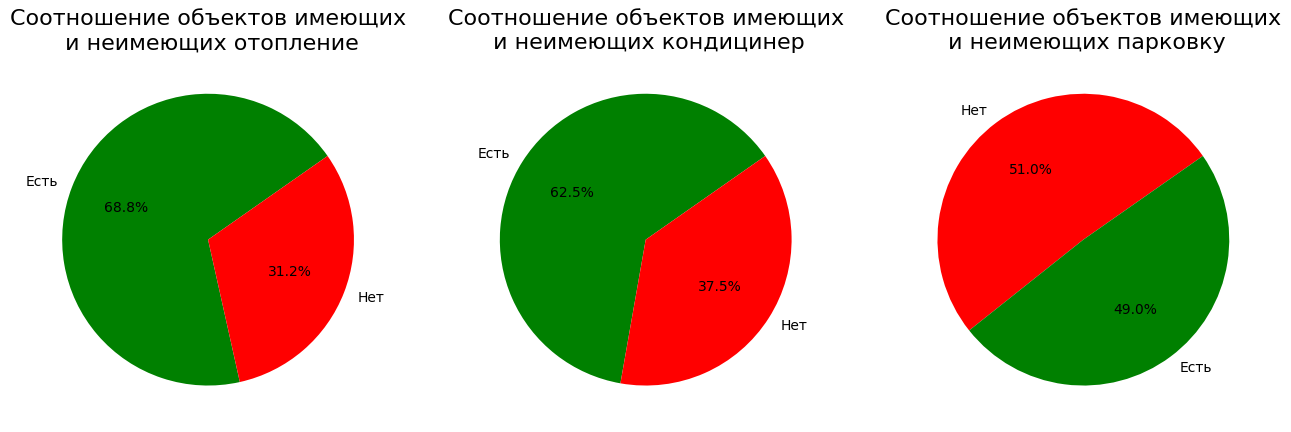

In [220]:
df1 = data['Heating'].value_counts()
df2 = data['Cooling'].value_counts()
df3 = data['Parking'].value_counts()

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16, 8))

ax[0].pie(x=df1, labels=['Есть', 'Нет'], colors=['green', 'red'], autopct='%.1f%%', startangle=35)
ax[0].set_title('Соотношение объектов имеющих\n и неимеющих отопление', fontsize=16)
ax[1].pie(x=df2, labels=['Есть', 'Нет'], colors=['green', 'red'], autopct='%.1f%%', startangle=35)
ax[1].set_title('Соотношение объектов имеющих\n и неимеющих кондицинер', fontsize=16)
ax[2].pie(x=df3, labels=['Нет', 'Есть'], colors=['red', 'green'], autopct='%.1f%%', startangle=35)
ax[2].set_title('Соотношение объектов имеющих\n и неимеющих парковку', fontsize=16);
fig = ax[0].figure
fig.savefig('pic/pic1.png')


2.11 Признак 'schools' - содержит информацию о близжайших школах

Получим на его основе следующие признаки:
* максимальный рейтинг из указанных школ - 'max_rating';
* расстояние до близжайшей школы - 'min_dist';
* количество указанных школ - 'num_schools'.

In [221]:
# Максимальный рейтинг указанных школ
def get_max_schoole_rating(item):
    dict_fact = eval(item)
    list_rating = dict_fact[0]['rating']
    n = len(list_rating)
    rating = 0
        
    if n == 0: 
        return 'no data'
    else:
        for i in range(n):
            elem = list_rating[i].replace('/10', '')
            if elem.isdigit():
                if int(elem) > rating:
                    rating = int(elem)
                else: continue
            else: continue
        
        if rating == 0: return 'no rating'
        else: return rating   
# Минимальное расстояние до ближайшей школы
def get_min_schoole_dist(item):
    dict_fact = eval(item)
    list_dis = dict_fact[0]['data']['Distance']
    n = len(list_dis)
        
    if n == 0: 
        return 'no data'
    else:
        min_dist = min(list_dis)           
        return float(min_dist.strip(' /mi'))        
# Количество указанных школ
def get_num_schools(item):
    dict_fact = eval(item)
    list_rating = dict_fact[0]['rating']
    n = len(list_rating)
    return n


In [222]:
data['max_rating'] = data['schools'].apply(get_max_schoole_rating)
data['min_dist'] = data['schools'].apply(get_min_schoole_dist)
data['num_schools'] = data['schools'].apply(get_num_schools)

Удалим признак 'schools'

In [223]:
data = data.drop('schools', axis=1)

2.12 Признаки 'mls-id' и 'MlsId' - это так называемые MLS ID (Multiple Listing Service ID) — уникальный идентификатор, который присваивается каждому объекту, включённому в Службу множественных размещений (MLS). Это число важно для профессионалов в сфере недвижимости и покупателей. Оно не доступно для просмотра на публичных сайтах, но доступно для агентов по недвижимости.

Данный признак позволит получить всю полную информацио по объекту недвижимости, вплоть до истории продаж. Но к сожалению мне не удалось найти бесплатный доступ к базам данных MLS ID, к тому же системы MLS могут различаться в зависимости от региона, поэтому MLS ID в одном районе будет отличаться от MLS ID в другом.

Поэтому удалим эти признаки.

Признак 'zipcode' - почтовый индекс. Для нас не несет какой-либо информации - удаляем его.

In [224]:
data = data.drop(['zipcode', 'mls-id', 'MlsId'], axis=1)

Удалим появившиеся дубликаты

In [225]:
n = data.shape[0]
data = data.drop_duplicates(ignore_index=True)
print(f'Количество удаленных дубликатов: {n - data.shape[0]}')

Количество удаленных дубликатов: 206


2.13 Признаки 'Year built' и 'Remodeled year'

Переведем их в численный вид, заполним пропуски значением 'no data' 

In [226]:
def num_year(elem):
    
    if elem is np.nan or elem == 'No Data' or np.isnan(elem):
        return 'no data'
    else:
        
        if elem < 1492 or elem > 2025:
            return 'no data'
        else: return int(elem)

In [227]:
data['Year built'] = data['Year built'].apply(num_year)

In [228]:
data['Remodeled year'] = data['Remodeled year'].apply(num_year)

### Результаты:
1. Провели работу по преобразованию всех признаков
2. Часть признаков имеют большое количество пропусков, которые удалось заполнить за счет других признаков
3. Раскрыли признаки homeFacts и schools

### 3. Работа с пропусками

3.1 Признаки 'square', 'Price/sqft' и целевая переменная 'target'

Построим зависимости целевой переменной от признаков 'square' и 'Price/sqft'

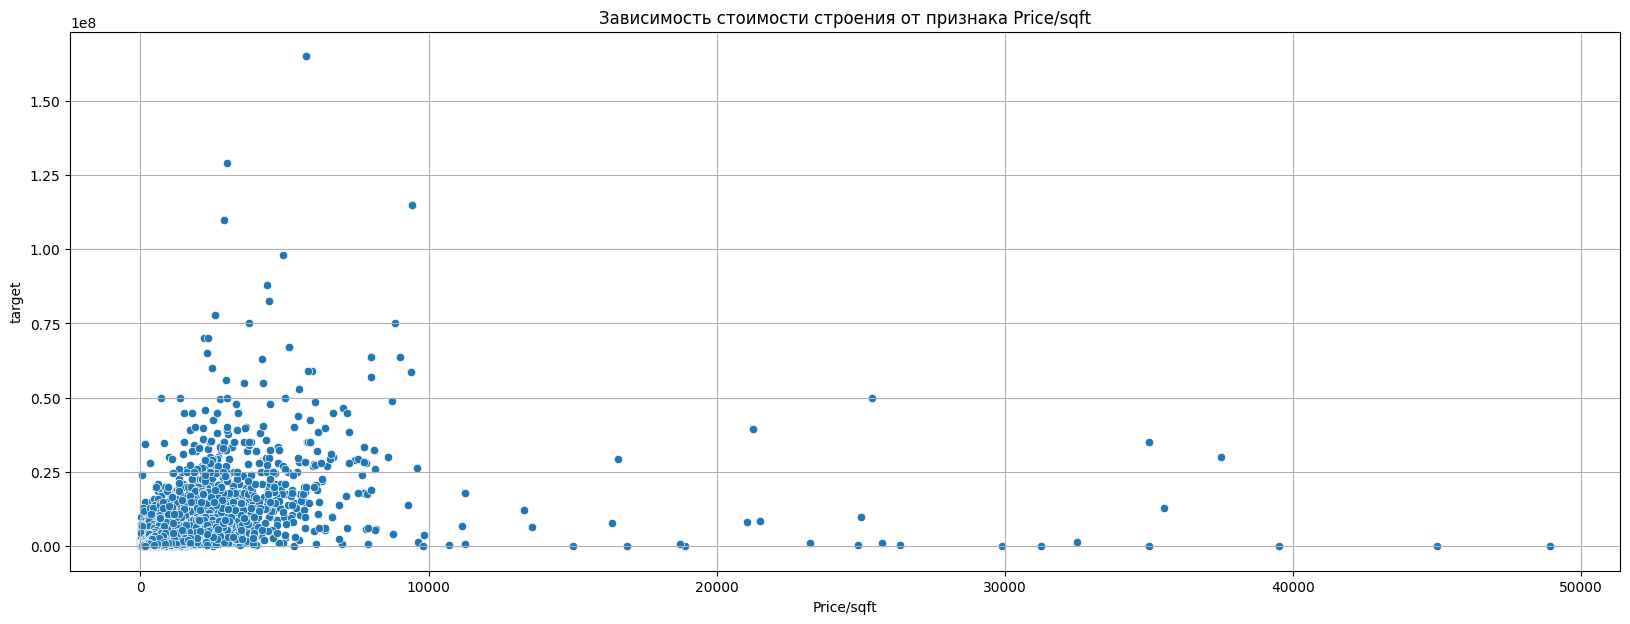

In [229]:
data1 = data[data['Price/sqft'] != 'no data']
data1 = data1[data1['Price/sqft'] < 50000.]

fig = plt.figure(figsize=(20, 7))
ax = sns.scatterplot(data1, x='Price/sqft', y='target')
ax.set_title('Зависимость стоимости строения от признака Price/sqft')
ax.grid();
fig = ax.figure
fig.savefig('pic/pic2.png')

In [230]:
def num_sq(elem):
    
    if np.isnan(elem):
        return 'no data'
    else: return elem

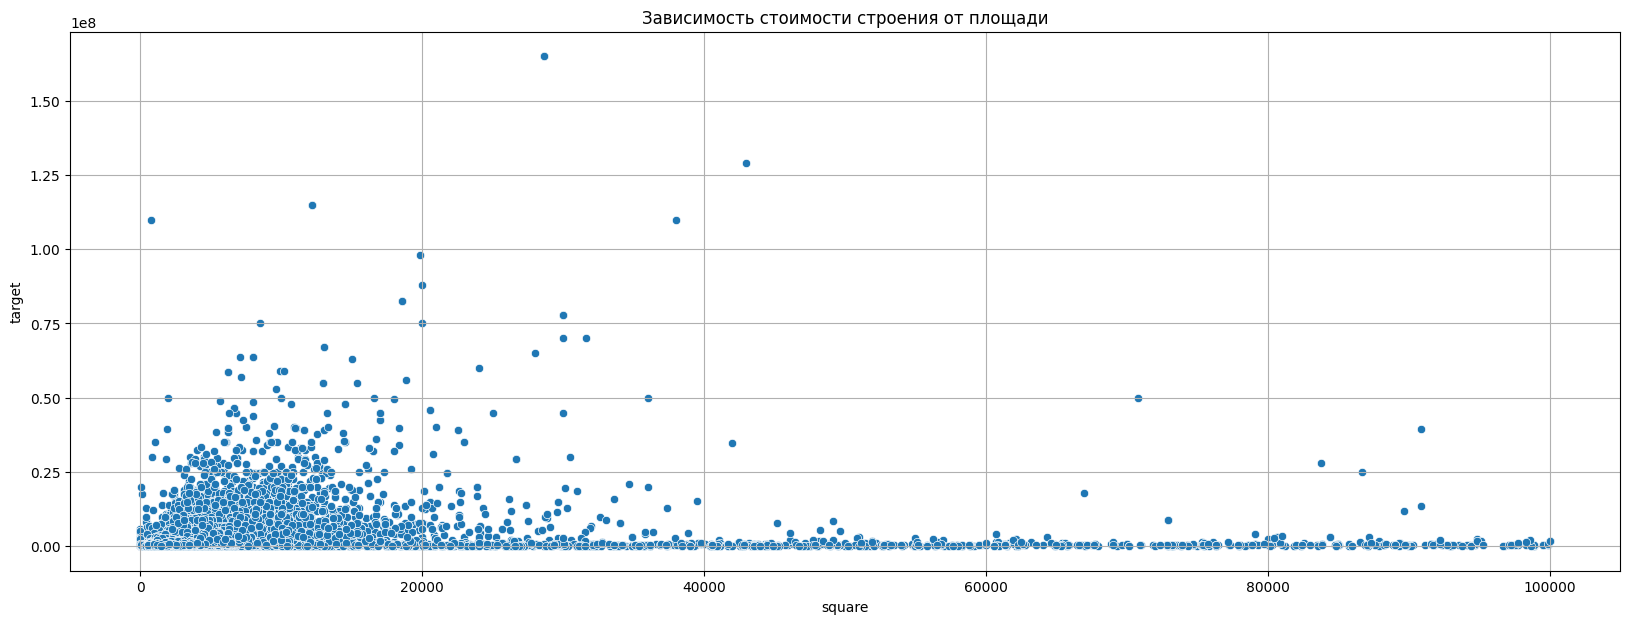

In [231]:
data2 = data[['square', 'target']]
data2['square'] = data2['square'].apply(num_sq)
data2 = data2[data2['square'] != 'no data']
data2 = data2[data2['square'] < 100000]

fig = plt.figure(figsize=(20, 7))
ax = sns.scatterplot(data2, x='square', y='target')
ax.set_title('Зависимость стоимости строения от площади')
ax.grid();
fig = ax.figure
fig.savefig('pic/pic3.png')

А теперь посмотрим на зависимость целевой переменной от произведения признаков 'Price/sqft' и 'square'

In [232]:
def func(sq, price):
    
    if type(sq) == float and type(price) == float:
        return sq * price
    else: return 'no data'

In [233]:
data3 = data[['Price/sqft', 'square', 'target']]
data3['sq*pr'] = data3.apply(lambda x: func(x['square'], x['Price/sqft']), axis=1)

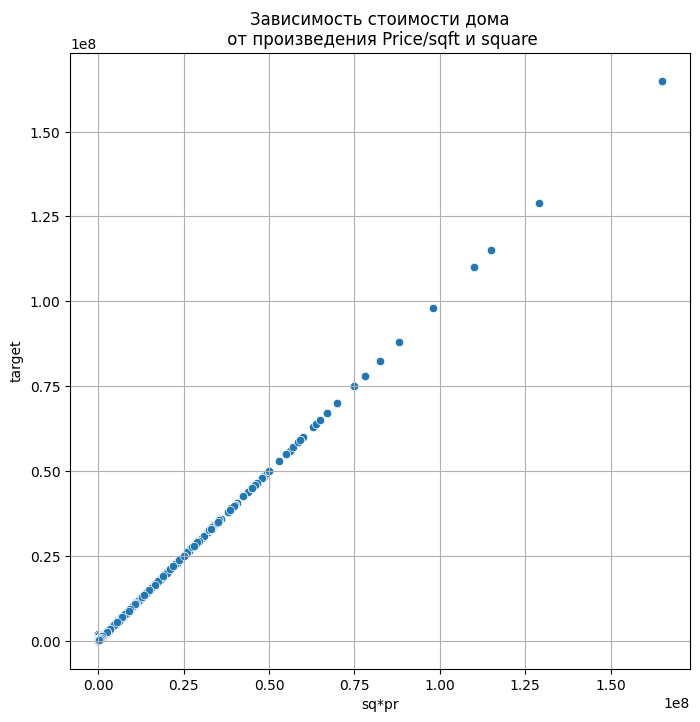

In [234]:
data3 = data3[data3['sq*pr'] != 'no data']

fig = plt.figure(figsize=(8, 8))
ax = sns.scatterplot(data3, x='sq*pr', y='target')
ax.set_title('Зависимость стоимости дома\n от произведения Price/sqft и square')
ax.grid();
fig = ax.figure
fig.savefig('pic/pic4.png')

Получили значение целевого признака. 

Всё, можно расходиться - задача решена. Достаточно перемножить значения двух признаков - 'Price/sqft' и 'square', чтобы получить стоимость дома.

Дальнейшие возможные варианты:

1. По сути, нашу первоначальную задачу - 'разработать сервис для предсказания стоимости домов на основе истории предложений' нужно бы переквалифицировать в разработку модели по предсказанию цены одного квадратного фута.
2. Продолжим решать первоначальную задачу.

Выбираем второй вариант, т.к. он соответствует первоначальной цели. При этом признак 'Price/sqft' нужно удалить во избежание утечки данных. Признак 'square' становится одним из самых важных для определния стоимости. Поэтому все пропуски в нем удаляем.

In [235]:
print(f'Количество пропусков признака square {round(data['square'].isnull().mean() * 100, 3)}%')

Количество пропусков признака square 14.078%


In [236]:
n = data.shape[0]
data = data.dropna(subset=['square'])
print(f'Количество удаленных строк: {n - data.shape[0]}')
print(f'Количество оставшихся записей: {data.shape[0]}')

Количество удаленных строк: 52656
Количество оставшихся записей: 321381


Удалим признак 'Price/sqft'

In [237]:
data = data.drop('Price/sqft', axis=1)

3.2 Признак 'stories'

Рассмотрим количество пропусков

In [238]:
print(f'Количество пропусков в признаке stories {round(data['stories'].isnull().mean() * 100, 3)}%')

Количество пропусков в признаке stories 29.413%


Признак имеет очень много пропусков.

Заменим пропуски модой. Для чего сначала найдем её в зависимости от типа строения - 'type house'. 

In [239]:
stor_mode_df = data.groupby('type house')['stories'].apply(lambda x: x.mode())
stor_mode_df

type house           
Cape Cod            0    2.0
Cluster Home        0    2.0
apartment           0    1.0
bungalow            0    1.0
condo               0    1.0
condo/townhome      0    2.0
contemporary        0    2.0
coop                0    1.0
craftsman           0    2.0
detached            0    3.0
european            0    2.0
garden home         0    2.0
high rise           0    1.0
land                0    1.0
low rise            0    3.0
mobile home         0    1.0
multi family home   0    2.0
one story           0    1.0
other               0    1.0
penthouse           0    3.0
ranch/farm          0    1.0
single family home  0    1.0
split level         0    2.0
townhome            0    2.0
traditional         0    2.0
two story           0    2.0
Name: stories, dtype: float64

У некоторых типов строений нет значений моды признака 'stories' - заменим их на моду по всему датасету.

In [240]:
fullset_type = set(data['type house'].unique())
mode_stories = float(data['stories'].mode()[0])

stor_mode_df = data.groupby('type house')['stories'].apply(lambda x: x.mode()).reset_index().set_index('type house')
stor_mode_df = stor_mode_df.drop('level_1', axis=1)

In [241]:
dict_stor = {}

for elem in fullset_type:
    if elem in list(stor_mode_df.index):
        dict_stor[elem] = float(stor_mode_df.loc[elem]['stories'])
    else: dict_stor[elem] = mode_stories   


Напишем функцию зля замены пропусков

In [242]:
def fillna_stories(type, stories):
    
    if np.isnan(stories):
        return dict_stor[type]
    else: return stories

Заменим пропуски

In [243]:
data['stories'] = data.apply(lambda x: fillna_stories(x['type house'], x['stories']), axis=1)

In [244]:
print(f'Количество пропусков в признаке stories {round(data['stories'].isnull().mean() * 100, 3)}%')

Количество пропусков в признаке stories 0.0%


3.3 Признаки 'bathrooms' и 'bedrooms'

Рассмотрим колество пропусков

In [245]:
print(f'Количество пропусков в признаке bedrooms {round(data['bedrooms'].isnull().mean() * 100, 3)}%')
print(f'Количество пропусков в признаке bathrooms {round(data['bathrooms'].isnull().mean() * 100, 3)}%')

Количество пропусков в признаке bedrooms 19.524%
Количество пропусков в признаке bathrooms 19.473%


Поступим аналогично, как и спризнаком 'stories' - заменим модой

In [246]:
mode_bath = float(data['bathrooms'].mode()[0])
mode_bed = float(data['bedrooms'].mode()[0])

bath_mode_df = data.groupby('type house')['bathrooms'].apply(lambda x: x.mode()).reset_index().set_index('type house')
bath_mode_df = bath_mode_df.drop('level_1', axis=1)

bed_mode_df = data.groupby('type house')['bedrooms'].apply(lambda x: x.mode()).reset_index().set_index('type house')
bed_mode_df = bed_mode_df.drop('level_1', axis=1)

dict_bath = {}
dict_bed = {}

for elem in fullset_type:
    if elem in list(bath_mode_df.index):
        dict_bath[elem] = bath_mode_df.loc[elem]['bathrooms']
    else: dict_bath[elem] = mode_bath   
    
for elem in fullset_type:
    if elem in list(bed_mode_df.index):
        dict_bed[elem] = float(bed_mode_df.loc[elem]['bedrooms'])
    else: dict_bed[elem] = mode_bed   


In [247]:
def fillna_bath(type, bath):
        
    if bath is np.nan:
        return dict_bath[type]    
    else: return bath

    
def fillna_bed(type, bed):
        
    if bed is np.nan or np.isnan(bed):
        return dict_bed[type]      
    else: return bed

Заполним пропуски

In [248]:
data['bathrooms'] = data.apply(lambda x: fillna_bath(x['type house'], x['bathrooms']), axis=1)
data['bedrooms'] = data.apply(lambda x: fillna_bed(x['type house'], x['bedrooms']), axis=1)

In [249]:
print(f'Количество пропусков в признаке bedrooms {round(data['bedrooms'].isnull().mean() * 100, 3)}%')
print(f'Количество пропусков в признаке bathrooms {round(data['bathrooms'].isnull().mean() * 100, 3)}%')

Количество пропусков в признаке bedrooms 0.0%
Количество пропусков в признаке bathrooms 0.0%


3.4 Признак 'lotsize'

Некоторые значения отрицательны - возьмем модуль

In [250]:
data['lotsize'] = data['lotsize'].apply(lambda x: x if x == 'no data' else abs(x))

Рассмотрим распределение логарифма значений признака 'lotsize'

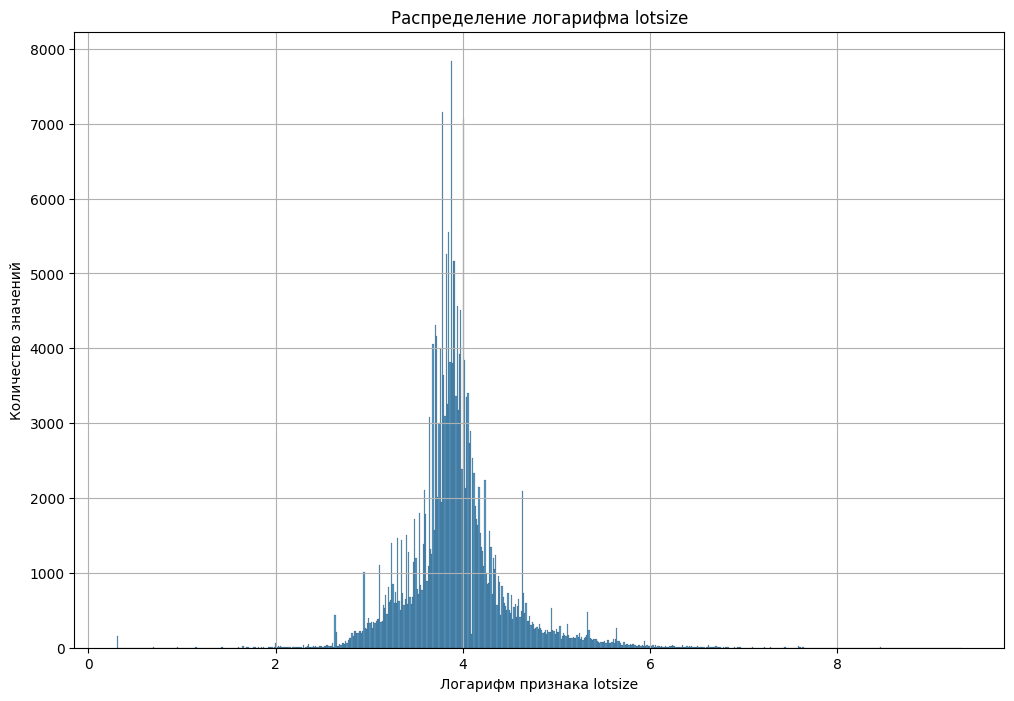

In [251]:
df1 = data[data['lotsize'] != 'no data']
df1['lotsize'] = pd.to_numeric(df1['lotsize'])
df1['log_lotsize'] = np.log10(df1['lotsize'] + 1)

fig = plt.figure(figsize=(12, 8))
ax = sns.histplot(df1, x='log_lotsize')
ax.set_title('Распределение логарифма lotsize')
ax.set_xlabel('Логарифм признака lotsize')
ax.set_ylabel('Количество значений')
ax.grid();
fig = ax.figure
fig.savefig('pic/pic5.png')

Распределение похоже на нормальное, но имеются выбросы.

Использование заполнения пропусков медианой или средним приводит к сильной деградации данных, поэтому переведем признак в категориальный, заменив значения степенью, а пропуски так и оставим со значением 'no data'

In [252]:
def degree_lot(elem):
    
    if elem == 'no data':
        return elem
    else:
        return round(np.log10(float(elem) + 1))

In [253]:
data['degree_lot'] = data['lotsize'].apply(degree_lot)

In [254]:
data['degree_lot'].nunique()

11

Получили 11 значений

Рассмотрим гистограмму распределения значений признака

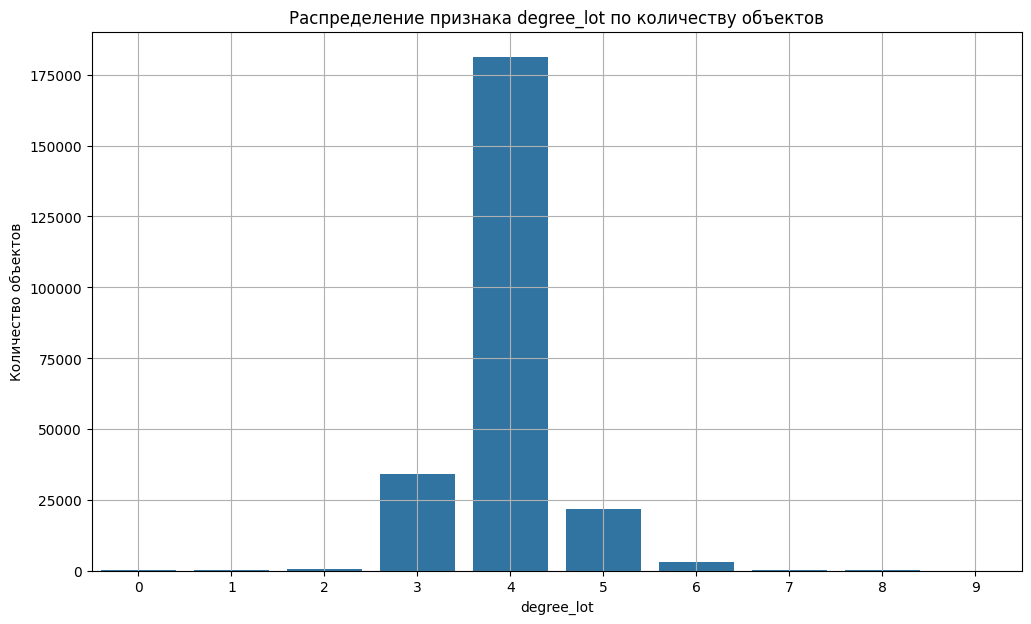

In [255]:
data4 = data['degree_lot'].value_counts().reset_index()

fig = plt.figure(figsize=(12, 7))
ax = sns.barplot(data4[data4['degree_lot'] != 'no data'], x='degree_lot', y='count')
ax.set_title('Распределение признака degree_lot по количеству объектов')
ax.set_ylabel('Количество объектов')
ax.grid();
fig = ax.figure
fig.savefig('pic/pic6.png')

Напоминает нормальное, как и прежнее значение признака

### Результаты:
1. Выявили связь между признаками 'square', 'Price/sqft' и целевой переменной 'target':
$$ target = square * Price/sqft$$
Признак 'square' является ключевым при определении цены. Удалили все пропуски в признаке 'square' и признак 'Price/sqft' из данных.
2. Заменили пропуски модой для признаков 'stories', 'bedrooms' и 'bathrooms'
3. Перевели признак 'lotsize' в категориальный, заменив значения степенью 10, а пропуски 'no data'

### 4. Анализ и преобразование признаков

4.1 Целевая переменная 

Рассмотрим распределение целевой переменной и её логарифма. Для чего введем новый признак 'log_targ'

In [256]:
data['log_targ'] = np.log10(data['target'] + 1)

Поссмотрим является ли распределение нормальным

Черной линией обозначим среднее, красной - медиану

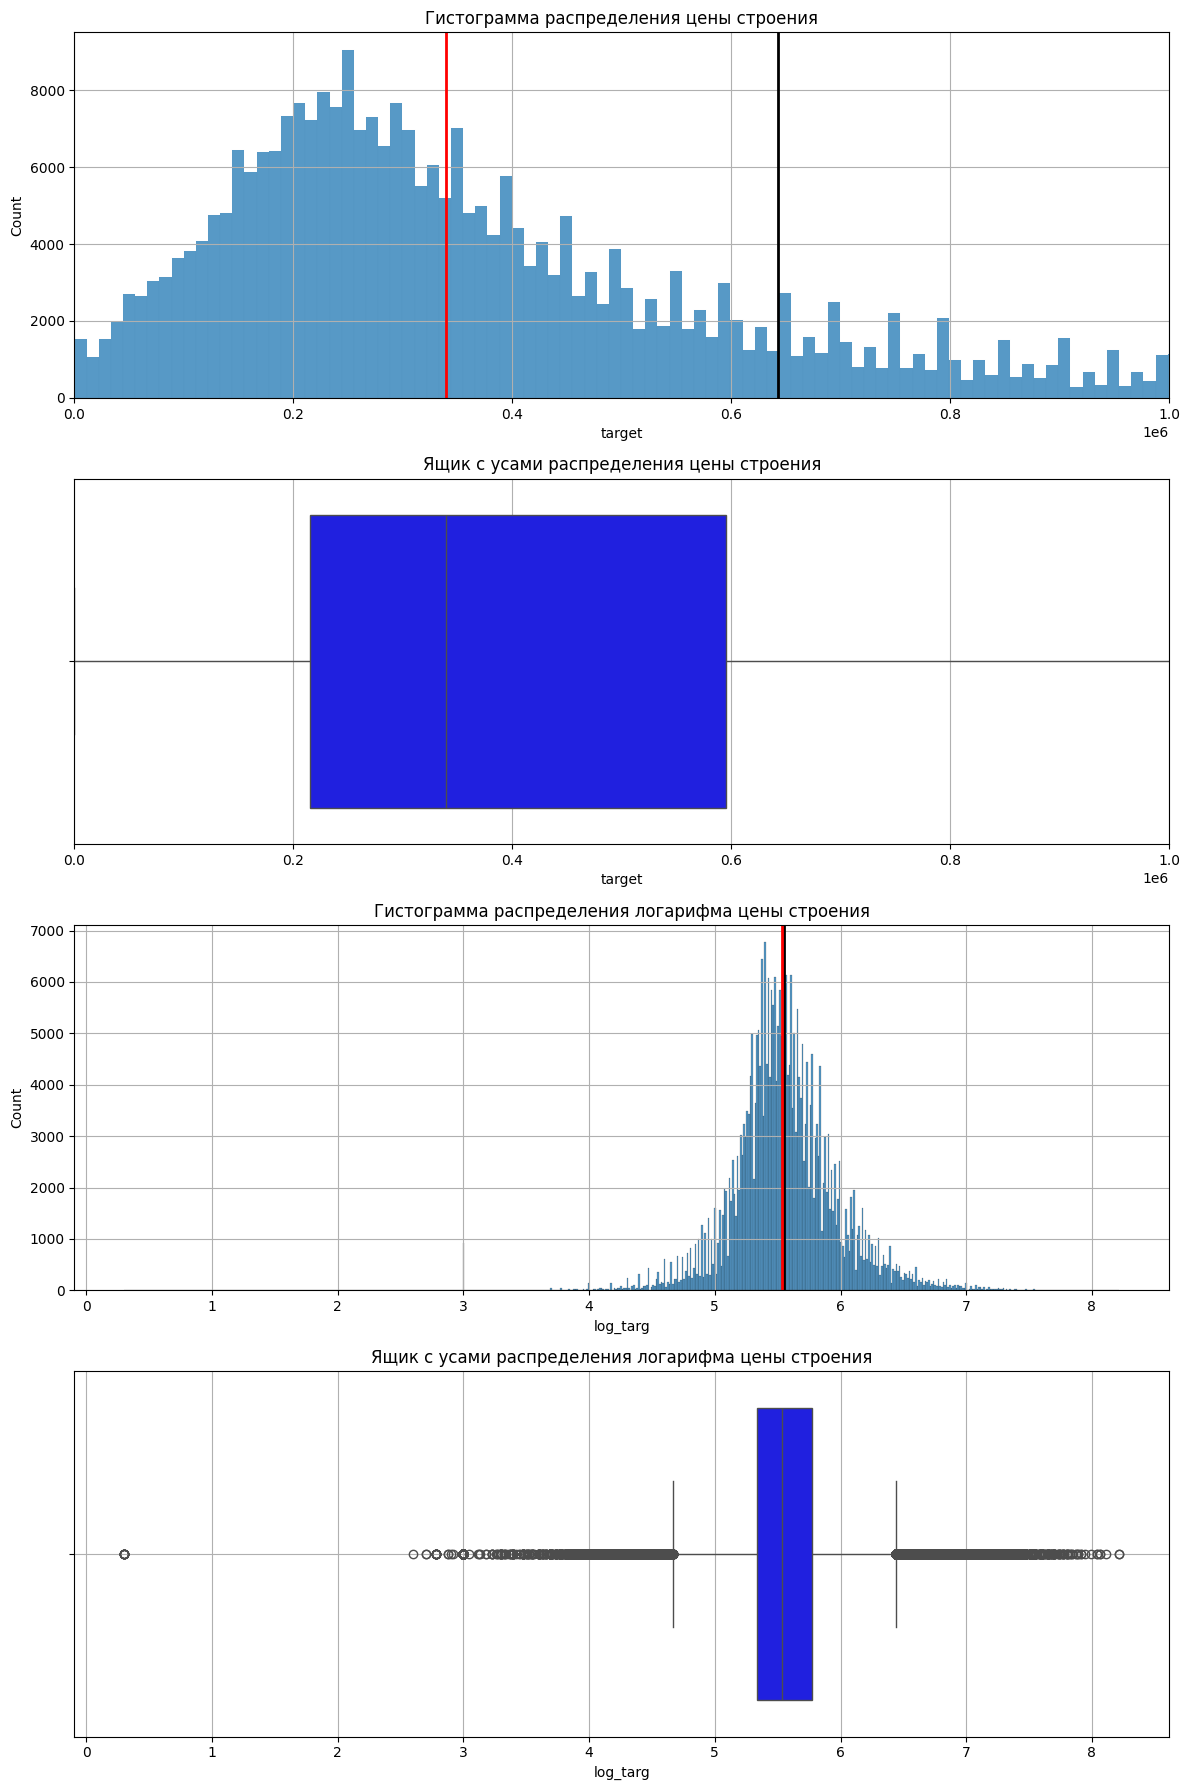

In [257]:
# Расчет средних и медианных значений для отображения на графике
mean_target = data['target'].mean()
median_target = data['target'].median()
mean_log_tar = data['log_targ'].mean()
median_log_tar = data['log_targ'].median()

fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(12, 18))

sns.histplot(data, x='target', ax=axes[0])
axes[0].axvline(mean_target, color='k', lw=2)
axes[0].axvline(median_target, color='r', lw=2)
axes[0].set_xlim([0, 1000000])
axes[0].set_title('Гистограмма распределения цены строения')
axes[0].grid()
sns.boxplot(data, x='target', color='blue', ax=axes[1])
axes[1].set_xlim([0, 1000000])
axes[1].set_title('Ящик с усами распределения цены строения')
axes[1].grid()
sns.histplot(data, x='log_targ', ax=axes[2])
axes[2].axvline(mean_log_tar, color='k', lw=2)
axes[2].axvline(median_log_tar, color='r', lw=2)
axes[2].set_title('Гистограмма распределения логарифма цены строения')
axes[2].grid()
sns.boxplot(data, x='log_targ', color='blue', ax=axes[3])
axes[3].set_title('Ящик с усами распределения логарифма цены строения')
axes[3].grid()
plt.tight_layout();
fig = axes[0].figure
fig.savefig('pic/pic7.png')

Как видно из графиков распределение логарифма цены ближе к нормальному. Проверим это наблюдение

In [258]:
alpha = 0.05

res = stats.normaltest(a=data['log_targ'])
p_val = res.pvalue

print(f'Значение pvalue: {p_val}')

if p_val <= alpha:
    print('Распределение не нормальное')
else:
    print('Распределение нормальное')

Значение pvalue: 0.0
Распределение не нормальное


4.2 Признак 'square'

Аналогично поступим с признаком 'square'

In [259]:
data['log_sq'] = np.log10(data['square'] + 1)

mean_sq = data['square'].mean()
median_sq = data['square'].median()
mean_log_sq = data['log_sq'].mean()
median_log_sq = data['log_sq'].median()

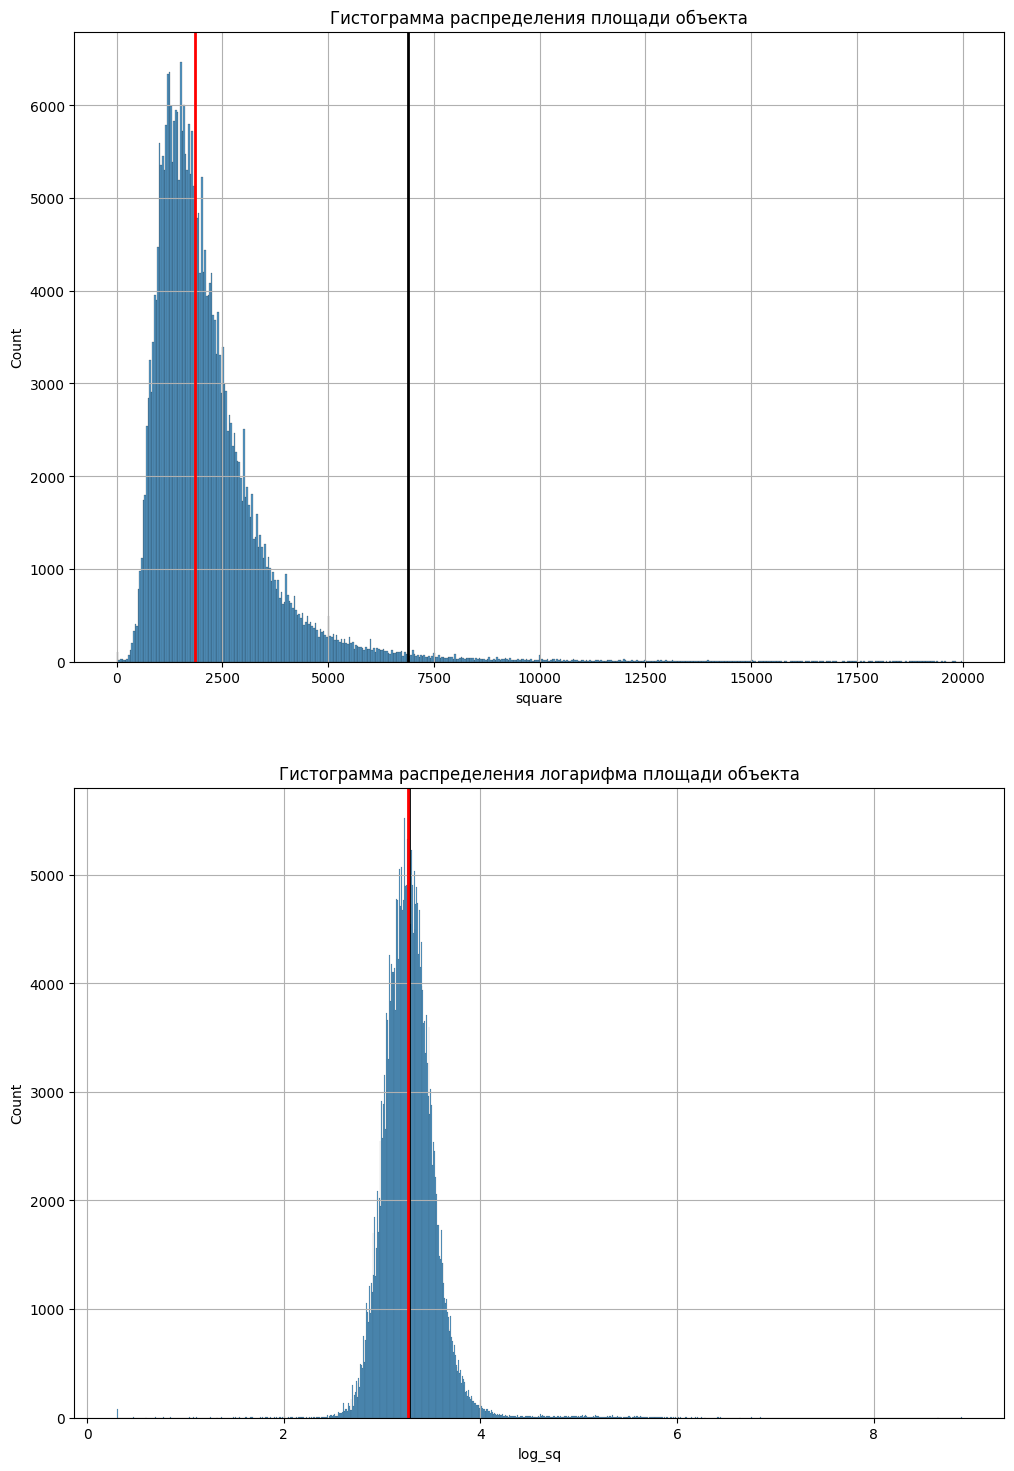

In [261]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 18))

sns.histplot(data[data['square'] < 20000], x='square', ax=axes[0])
axes[0].axvline(mean_sq, color='k', lw=2)
axes[0].axvline(median_sq, color='r', lw=2)
axes[0].set_title('Гистограмма распределения площади объекта')
axes[0].grid()
sns.histplot(data, x='log_sq', ax=axes[1])
axes[1].axvline(mean_log_sq, color='k', lw=2)
axes[1].axvline(median_log_sq, color='r', lw=2)
axes[1].set_title('Гистограмма распределения логарифма площади объекта')
axes[1].grid();
fig = axes[0].figure
fig.savefig('pic/pic8.png')

Как и в случае с ценой, распределение логарифма площади ближе к нормальному распределению. Проверим это наблюдение

In [102]:
alpha = 0.05

res = stats.normaltest(a=data['log_sq'])
p_val = res.pvalue

print(f'Значение pvalue: {p_val}')

if p_val <= alpha:
    print('Распределение не нормальное')
else:
    print('Распределение нормальное')

Значение pvalue: 0.0
Распределение не нормальное


Оба распределения не являются нормальными из-за наличия выбросов, связанных с несбалансированностью данных и ошибок допущенных в данных.

Очистим данные от выбросов. Для этого определим минимальную площать продаваемого объекта - 10 квадратных футов. Скорее всего указанные значения меньше 10 являются ошибкой - вероятно имелись акры.

In [103]:
n = data.shape[0]
data = data[data['square'] > 10]
print(f'Количество удаленных строк {n - data.shape[0]}')

Количество удаленных строк 90


В дальнейшем для обучения модели будем использовать признак логарифма площади - 'log_sq', а признак 'square' удалим.

In [104]:
data = data.drop('square', axis=1)

4.3 Признаки 'street', 'city' и 'state'

На основе этих признаков получим два новых - широта и долгота

Признак 'street' имеет много значений вида 'unknown', поэтому будем использовать только координаты города или штата, в случае если город не указан

Некоторые данные для города Santa Ana указаны неправиль - указан не тот штат. Заменим его на правильный.

In [105]:
def santa_ana_state(city, state):
    
    if city == 'Santa Ana':
        return 'CA'
    else: return state

In [106]:
data['state'] = data.apply(lambda x: santa_ana_state(x['city'], x['state']), axis=1)

Рассмотрим распределение медианной цены по штатам

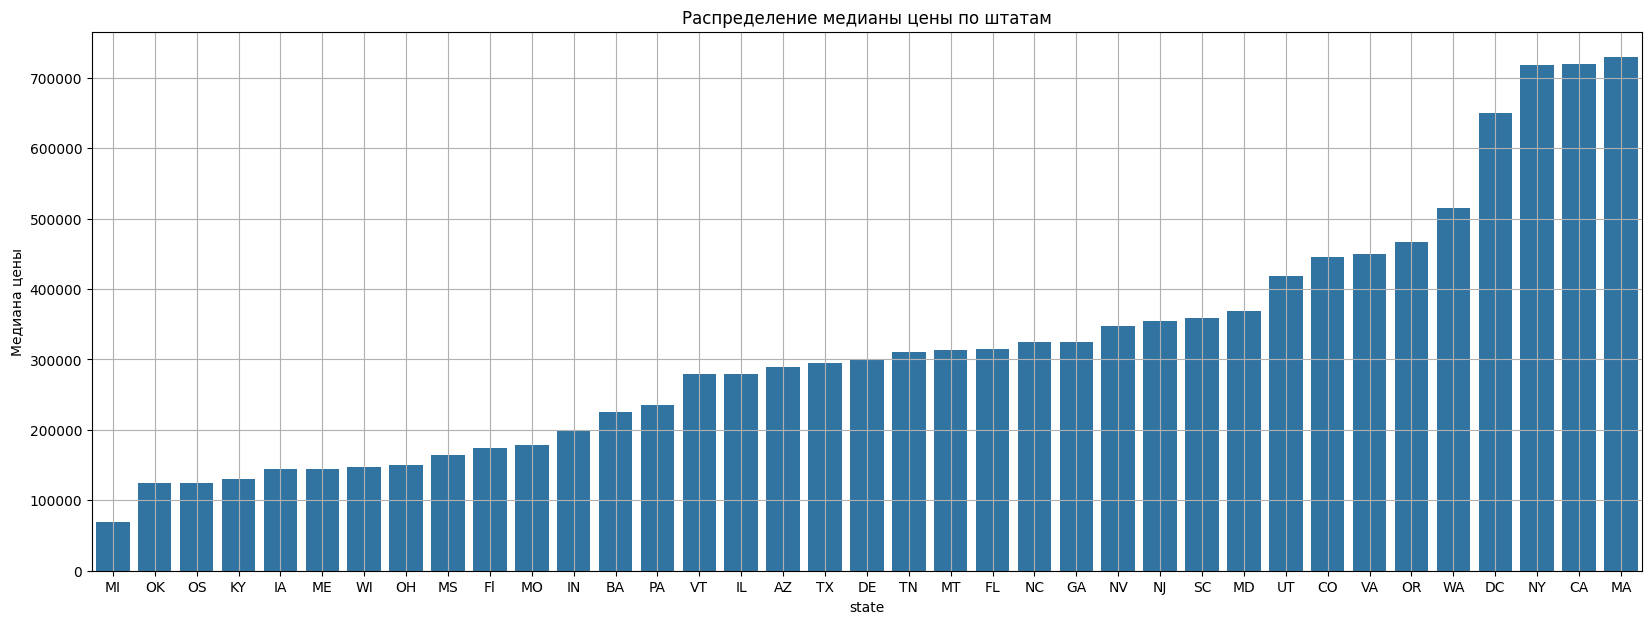

In [107]:
data5 = data.groupby('state')['target'].median().reset_index().sort_values(by='target')

fig = plt.figure(figsize=(20, 7))
ax = sns.barplot(data5, x='state', y='target')
ax.set_title('Распределение медианы цены по штатам')
ax.set_ylabel('Медиана цены')
ax.grid();
fig = ax.figure
fig.savefig('pic/pic9.png')

Как видно, самые большие цены в Массачусетсе, Калифорнии и Нью-Йорке, а самые низкие в Мичигане

In [108]:
data['state'].nunique()

37

Данные представлены 37 штатами, а в США их 50 (на момент разработки модели). Таким образом, в случае появления записи со штатом не входящим в наш датасет, модель не сможет точно предсказать целевую переменную.

Вместо улицы, города и штата будем использовать координаты, для этого сформируем вспомогательный признак - 'city, state', состоящий из города (если есть) и штата.

In [109]:
# Словарь для исправления ошибок в названии городов
set_city_error = {'Federalheights': 'Federal Heights', 'City Of Vista': 'Vista', 'Clear Lk Shrs': 'Clear Lake Shores', 'Unincorporated Dade County': 'Dade County', 'Commercecity': 'Commerce City', 'Ldhl': 'Lauderhill', 'Angel Fie': 'Punta Gorda', 'Cherryhillsvillage': 'Cherryhills Village', 'P C Beach': 'Panama City Beach', 'Belllingham': 'Bellingham', 'Jefferson Count': 'Jefferson County', 'County Los Angeles': 'Los Angeles', 'Jamaica Est': 'Jamaica', 'Atlaanta': 'Atlanta', 'Mdale': 'Mattydale', 'Old Mill Basin': 'Brooklyn', 'Outside Area (Outside Ca)': 'Nashville', 'Bellerose Manor': 'Queens Village', 'Doctor Philips': 'Orlando', 'Town North Country': 'Town n Country', 'Brookside Vl': 'Brookside Village', 'Longvi': 'Longview', 'Hollywood Pa': 'Hollywood Park', 'Highway 30': 'Anderson', }

def get_adress(city, state):
    # для пропусков города будем использовать данные штата
    if city is np.nan or city.strip(' ') == '' or city == '--':
        return state
    # Неправильно заполненые данные будем заполнять nan, далее их удалим
    elif city in ['Other City Not In the State of Florida', 'Other City Value - Out Of Area', 'Other City Value Out Of Area', 'Quito Ecuador'] or city.title() == 'Foreign Country':
        return np.nan
    # Формируем значения признака
    elif city.title() in list(set_city_error.keys()):
        return set_city_error[city.title()] + ', ' + state
    
    elif 'other' in city.lower():
        return state
    
    elif city.lower() in ['s.a.', 'uninc', 'bville']: 
        return state
    
    else:
        city = city.title().replace('Vlg', 'Village').replace('Unincorporated ', '').replace('Un-Incorporated ', '').replace('Spgs', 'Springs').replace('Unicorp/', '')
        adress = city + ', ' + state
        return adress

In [110]:
data['city, state'] = data.apply(lambda x: get_adress(x['city'], x['state']), axis=1)
n = data.shape[0]
# Удаляем пропуски
data = data.dropna(subset=['city, state'])
print(f'Количество удаленных пропусков: {n - data.shape[0]}')

Количество удаленных пропусков: 5


Для заполнения координат воспользуемся уже собранными данными, сохраненными в файл city_coord.csv

Загрузим его

In [111]:
data_coord = pd.read_csv('data/city_coord.csv')
data_coord.head()

city, state        lat        lng
0   Abilene, TX  32.446450 -99.747591
1  Abingdon, VA  36.710402 -81.975249
2  Accokeek, MD  38.662284 -76.991033
3     Adams, TN  36.582372 -87.065575
4   Addison, TX  32.960119 -96.830003

Дополним наш датасет координатами

In [112]:
data = data.merge(data_coord, how='left', on='city, state')
data.head(3)

status             street  fireplace            city state  stories  \
0    active     240 Heather Ln          1  Southern Pines    NC      1.0   
1  for sale  12911 E Heroy Ave          0  Spokane Valley    WA      2.0   
2  for sale  2005 Westridge Rd          1     Los Angeles    CA      1.0   

      target  pool          type house bathrooms  ... bedrooms max_rating  \
0   418000.0     0  single family home       3.5  ...      4.0          7   
1   310000.0     0  single family home       3.0  ...      3.0          4   
2  2895000.0     1  single family home       2.0  ...      3.0          8   

   min_dist  num_schools  degree_lot  log_targ    log_sq         city, state  \
0      10.5            8     no data  5.621177  3.462548  Southern Pines, NC   
1      1.01            3           4  5.491363  3.289589  Spokane Valley, WA   
2      1.19            3           4  6.461649  3.477266     Los Angeles, CA   

         lat         lng  
0  35.174047  -79.392254  
1  47.657110 -117.261394  
2  34.053691 -118.242766  

[3 rows x 26 columns]

Дополнительно введем новый признак на основе численности города, где продается недвижимость. Для этого будем использовать информацию из википедии: "https://en.wikipedia.org/wiki/List_of_United_States_cities_by_population?ysclid=meq12s9m9t860805659"

Были взяты значения перепеси 2020 года

In [113]:
city_df = pd.read_csv('data/city_population.csv')
city_df.head()

city, state  population
0     New York, NY     8804190
1  Los Angeles, CA     3898747
2      Chicago, IL     2746388
3      Houston, TX     2304580
4      Phoenix, AZ     1608139

In [114]:
data = data.merge(city_df, how='left', on='city, state')
data.head()


status               street  fireplace            city state  stories  \
0    active       240 Heather Ln          1  Southern Pines    NC      1.0   
1  for sale    12911 E Heroy Ave          0  Spokane Valley    WA      2.0   
2  for sale    2005 Westridge Rd          1     Los Angeles    CA      1.0   
3  for sale  4311 Livingston Ave          1          Dallas    TX      3.0   
4  for sale    1624 S Newkirk St          0    Philadelphia    PA      2.0   

      target  pool          type house bathrooms  ... max_rating min_dist  \
0   418000.0     0  single family home       3.5  ...          7     10.5   
1   310000.0     0  single family home       3.0  ...          4     1.01   
2  2895000.0     1  single family home       2.0  ...          8     1.19   
3  2395000.0     0  single family home       8.0  ...         10      0.1   
4   209000.0     0            townhome       3.0  ...    no data  no data   

   num_schools  degree_lot  log_targ    log_sq         city, state        lat  \
0            8     no data  5.621177  3.462548  Southern Pines, NC  35.174047   
1            3           4  5.491363  3.289589  Spokane Valley, WA  47.657110   
2            3           4  6.461649  3.477266     Los Angeles, CA  34.053691   
3            4           4  6.379306  3.810098          Dallas, TX  32.776272   
4            0           3  5.320148  2.953276    Philadelphia, PA  39.952724   

          lng  population  
0  -79.392254         NaN  
1 -117.261394    102976.0  
2 -118.242766   3898747.0  
3  -96.796856   1304379.0  
4  -75.163526   1603797.0  

[5 rows x 27 columns]

На основании популяции города введем новый признак - 'city_status'.

In [115]:
def get_city_status(population, city_state):
    # для городов с населением более 3 миллионов оставим их названия - это Лос-Анжелес и Нью-Йорк
    if population > 3000000:
        return city_state.split(',')[0]
    # города с населением более 1 миллиона
    elif population > 1000000:
        return 'city_mill'
    # с населением от 1 миллиона до 500000 
    elif population > 500000:
        return 'big_city'
    # с населением от 500000 миллиона до 300000
    elif population > 300000:
        return 'city'
    # с населением от 300000 миллиона до 100000
    elif population > 100000:
        return 'town'
    # значение NaN - население менее 100000
    else:
        return 'small_town'

In [116]:
data['city_status'] = data.apply(lambda x: get_city_status(x['population'], x['city, state']), axis=1)

Рассмотрим количество записей в датасете и медианную цену в зависимости от статуса

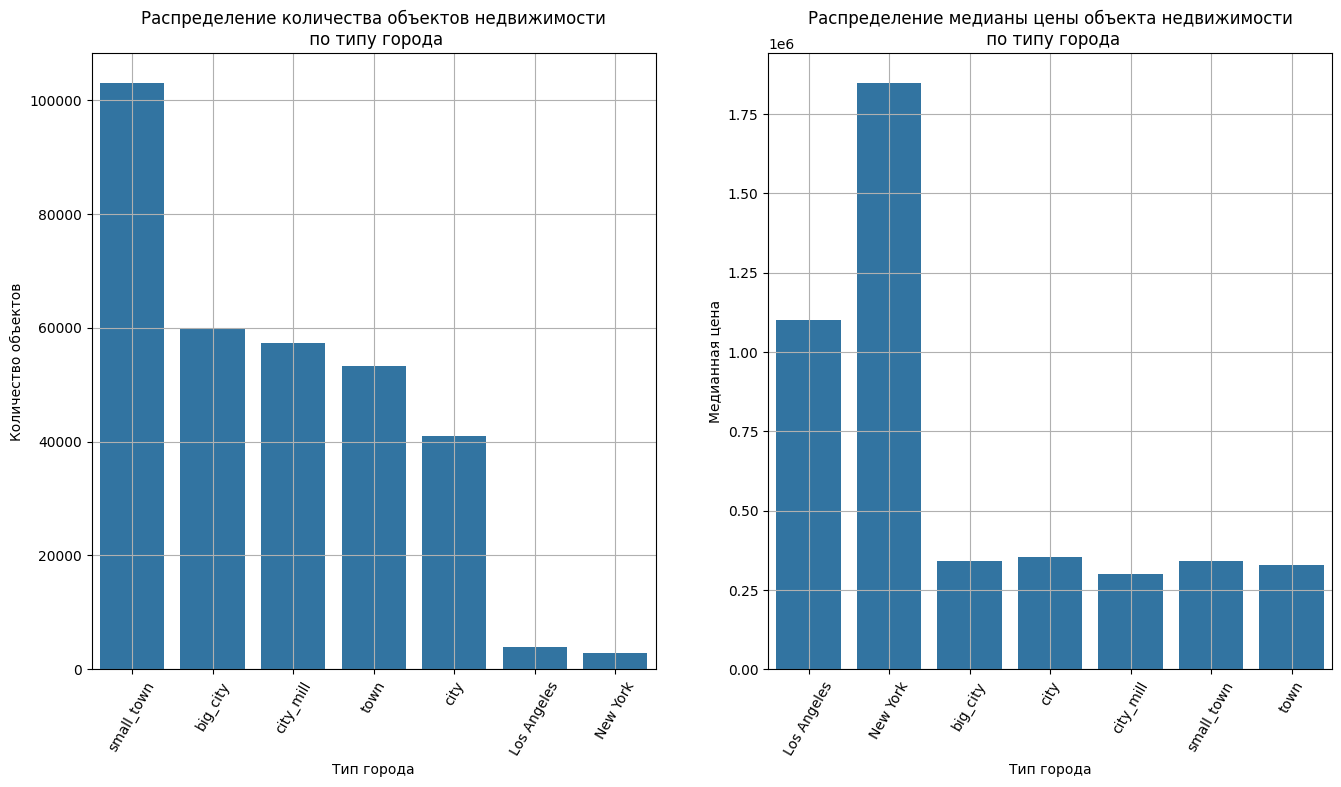

In [117]:
data6 = data['city_status'].value_counts().reset_index()
data7 = data.groupby('city_status')['target'].median().reset_index()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
sns.barplot(data6, x='city_status', y='count', ax=axes[0])
axes[0].tick_params(axis='x', rotation=60)
axes[0].set_title('Распределение количества объектов недвижимости\n по типу города')
axes[0].set_xlabel('Тип города')
axes[0].set_ylabel('Количество объектов')
axes[0].grid()
sns.barplot(data7, x='city_status', y='target', ax=axes[1])
axes[1].tick_params(axis='x', rotation=60)
axes[1].set_title('Распределение медианы цены объекта недвижимости\n по типу города')
axes[1].set_xlabel('Тип города')
axes[1].set_ylabel('Медианная цена')
axes[1].grid();
fig = axes[0].figure
fig.savefig('pic/pic10.png')

Наибольшее количество записей приходится на города с населением меньше 100000. Наименьшее количество записей - города Лос-Анжелес и Нью-Йорк, для которых наблюдается самое высокое значение медианы цены.

4.4 Влияние признаков 'pool', 'Heating', 'Cooling' и 'Parking'

Рассмотрим распределения медианы цены по штатам в зависимости от наличия бассейна, отопления, кондиционера и парковки

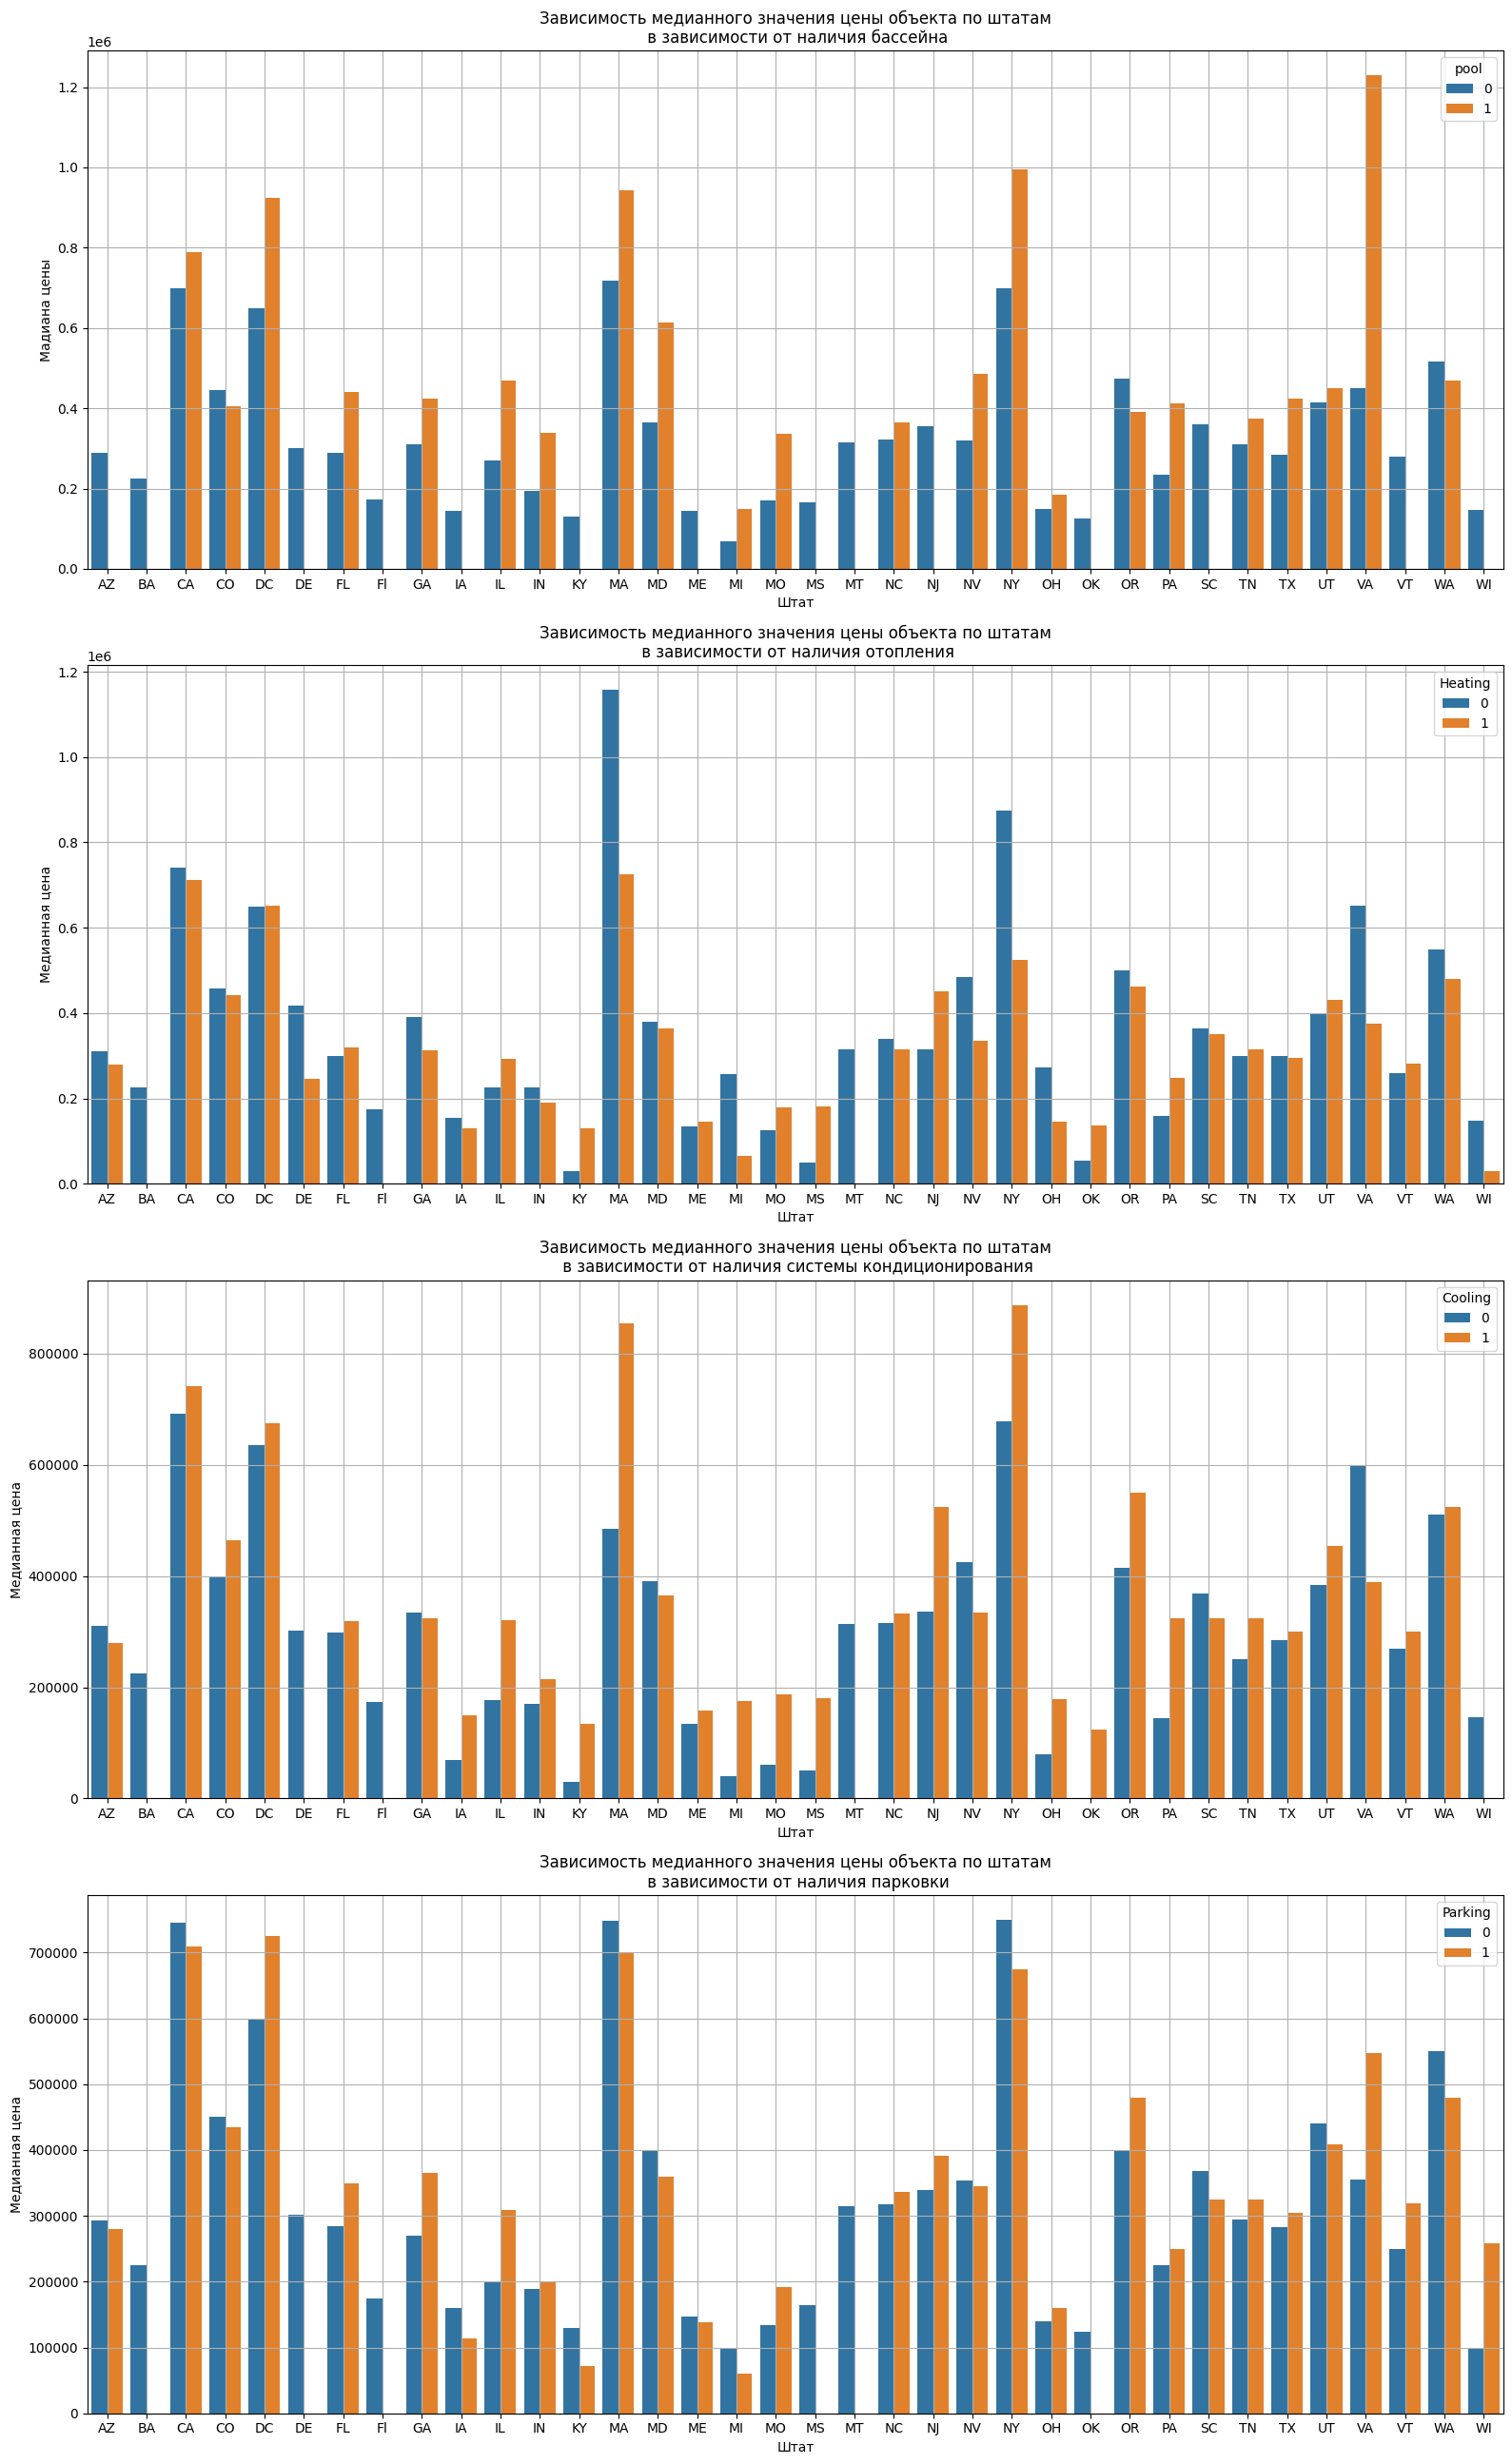

In [118]:
data8 = data.groupby(['state', 'pool'])['target'].median().reset_index()
data9 = data.groupby(['state', 'Heating'])['target'].median().reset_index()
data10 = data.groupby(['state', 'Cooling'])['target'].median().reset_index()
data11 = data.groupby(['state', 'Parking'])['target'].median().reset_index()

fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(16, 26))
sns.barplot(data8, x='state', y='target', hue='pool', ax=axes[0])
axes[0].set_title('Зависимость медианного значения цены объекта по штатам\n в зависимости от наличия бассейна')
axes[0].set_xlabel('Штат')
axes[0].set_ylabel('Мадиана цены')
axes[0].grid()
sns.barplot(data9, x='state', y='target', hue='Heating', ax=axes[1])
axes[1].set_title('Зависимость медианного значения цены объекта по штатам\n в зависимости от наличия отопления')
axes[1].set_xlabel('Штат')
axes[1].set_ylabel('Медианная цена')
axes[1].grid()
sns.barplot(data10, x='state', y='target', hue='Cooling', ax=axes[2])
axes[2].set_title('Зависимость медианного значения цены объекта по штатам\n в зависимости от наличия системы кондиционирования')
axes[2].set_xlabel('Штат')
axes[2].set_ylabel('Медианная цена')
axes[2].grid()
sns.barplot(data11, x='state', y='target', hue='Parking', ax=axes[3])
axes[3].set_title('Зависимость медианного значения цены объекта по штатам\n в зависимости от наличия парковки')
axes[3].set_xlabel('Штат')
axes[3].set_ylabel('Медианная цена')
axes[3].grid()
plt.tight_layout();
fig = axes[0].figure
fig.savefig('pic/pic11.png')

Выводы: распределения имеют индивидуальный характер для каждого штата.

Рассмотрим влияние значения этих признаков на медиане цены по всему датасету

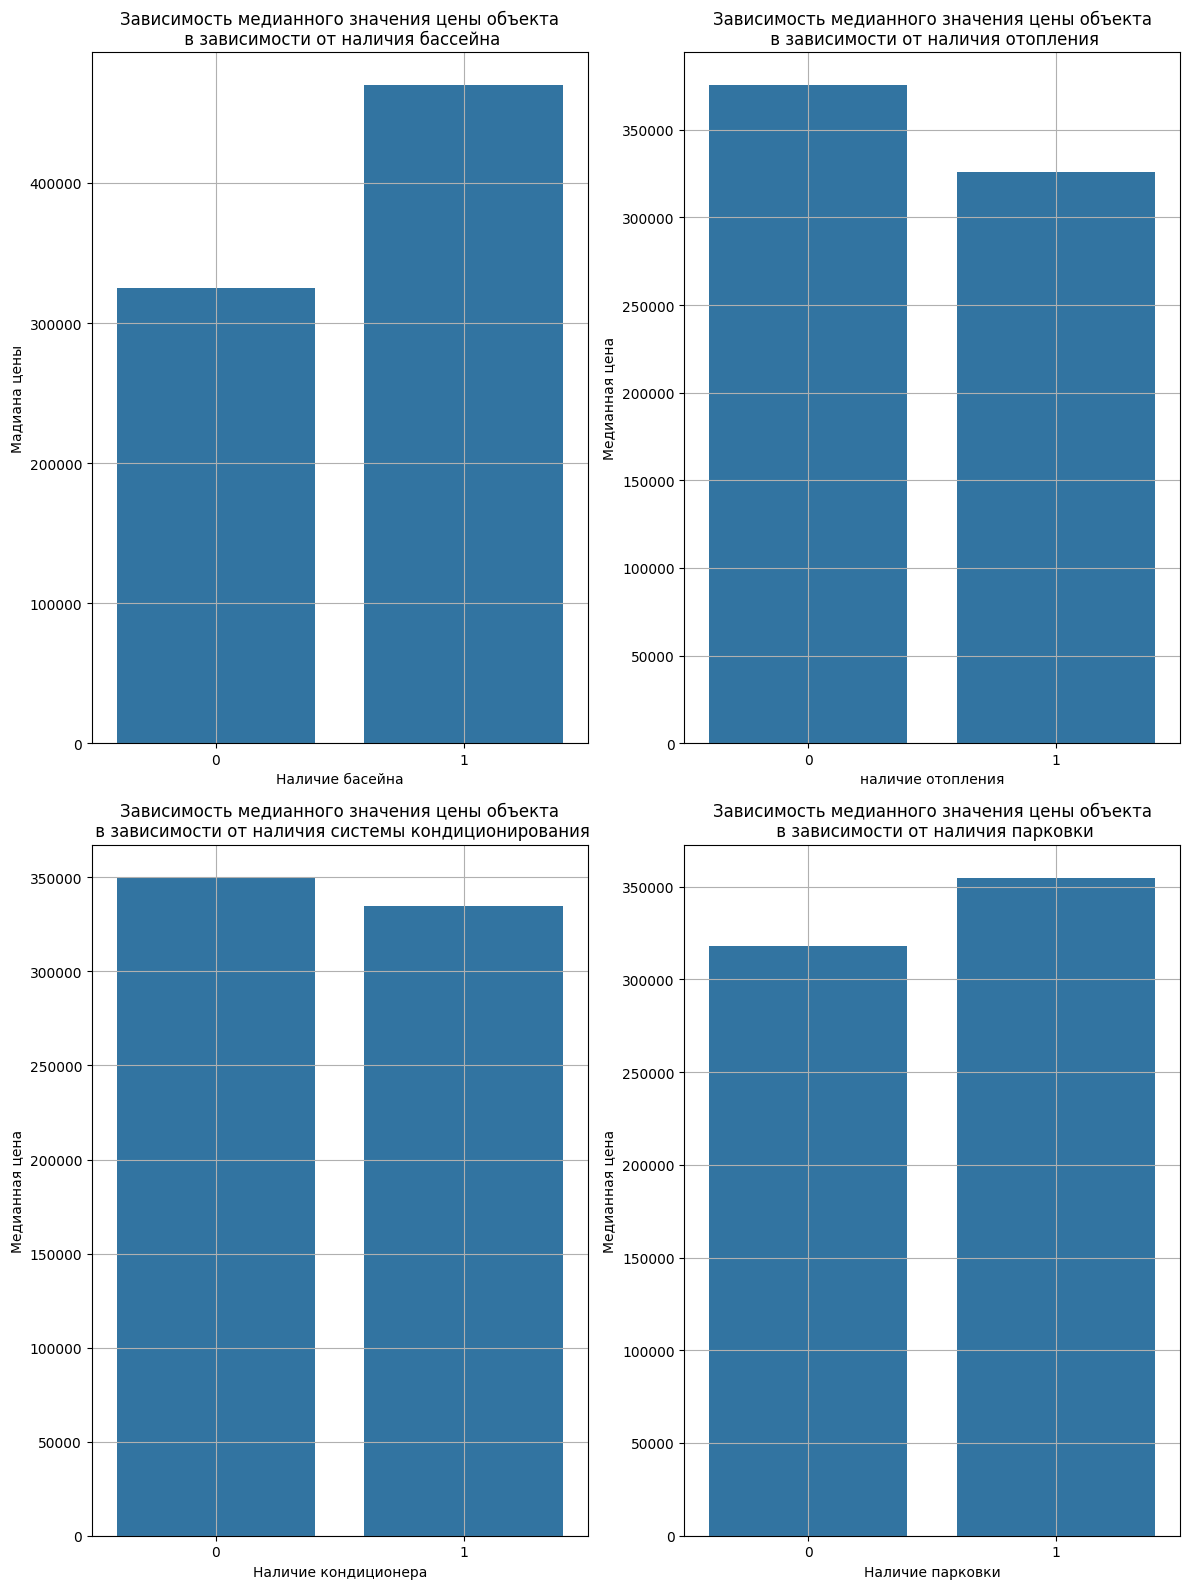

In [119]:
data12 = data.groupby('pool')['target'].median().reset_index()
data13 = data.groupby('Heating')['target'].median().reset_index()
data14 = data.groupby('Cooling')['target'].median().reset_index()
data15 = data.groupby('Parking')['target'].median().reset_index()

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 16))
sns.barplot(data12, x='pool', y='target', ax=axes[0][0])
axes[0][0].set_title('Зависимость медианного значения цены объекта\n в зависимости от наличия бассейна')
axes[0][0].set_xlabel('Наличие басейна')
axes[0][0].set_ylabel('Мадиана цены')
axes[0][0].grid()
sns.barplot(data13, x='Heating', y='target', ax=axes[0][1])
axes[0][1].set_title('Зависимость медианного значения цены объекта\n в зависимости от наличия отопления')
axes[0][1].set_xlabel('наличие отопления')
axes[0][1].set_ylabel('Медианная цена')
axes[0][1].grid()
sns.barplot(data14, x='Cooling', y='target', ax=axes[1][0])
axes[1][0].set_title('Зависимость медианного значения цены объекта\n в зависимости от наличия системы кондиционирования')
axes[1][0].set_xlabel('Наличие кондиционера')
axes[1][0].set_ylabel('Медианная цена')
axes[1][0].grid()
sns.barplot(data15, x='Parking', y='target', ax=axes[1][1])
axes[1][1].set_title('Зависимость медианного значения цены объекта\n в зависимости от наличия парковки')
axes[1][1].set_xlabel('Наличие парковки')
axes[1][1].set_ylabel('Медианная цена')
axes[1][1].grid()
plt.tight_layout();
fig = axes[0][0].figure
fig.savefig('pic/pic12.png')

Выводы:
1. Наличие бассейна характеризуется большей медианной цены.
2. Наличие кондиционера и парковки незначительно влияюет на медиану цены.
3. Наличие отопления характеризуется незначительным понижение медианы цены.

Удалим более ненужные и вспомогательные признаки

In [120]:
data = data.drop(['street', 'city', 'state', 'city, state', 'population'], axis=1)

4.5 Признаки 'Year built' и 'Remodeled year'

Рассмотрим распределение значений принаков, без учета пропусков

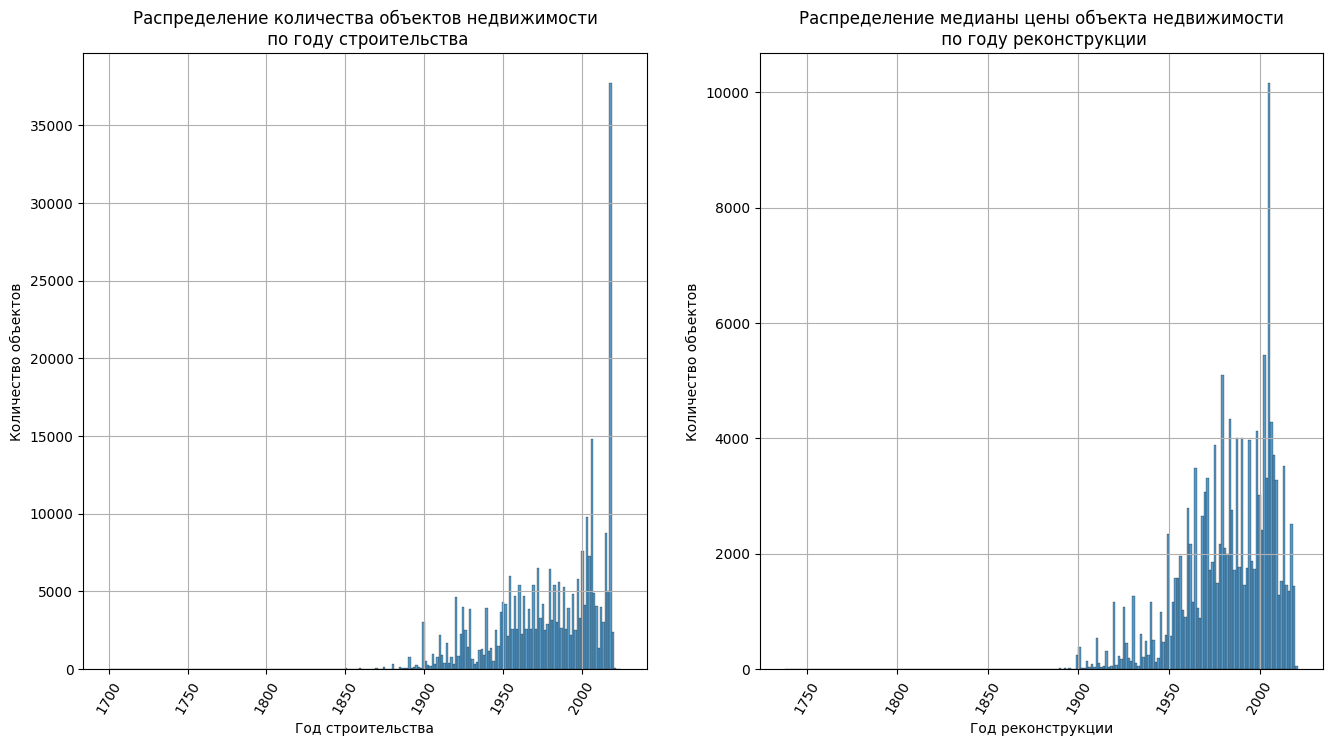

In [121]:
data16 = data[data['Year built'] != 'no data']
data17 = data[data['Remodeled year'] != 'no data']

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
sns.histplot(data16, x='Year built',ax=axes[0])
axes[0].tick_params(axis='x', rotation=60)
axes[0].set_title('Распределение количества объектов недвижимости\n по году строительства')
axes[0].set_xlabel('Год строительства')
axes[0].set_ylabel('Количество объектов')
axes[0].grid()
sns.histplot(data17, x='Remodeled year',ax=axes[1])
axes[1].tick_params(axis='x', rotation=60)
axes[1].set_title('Распределение медианы цены объекта недвижимости\n по году реконструкции')
axes[1].set_xlabel('Год реконструкции')
axes[1].set_ylabel('Количество объектов')
axes[1].grid();
fig = axes[0].figure
fig.savefig('pic/pic13.png')

Наибольшее количество объектов построены или реконструированы в этом веке.

Вместо чисел введем категории, например дома в возрасте до 5 лет назовем новыми - new building и т.д.

In [122]:
def get_age_building(elem):
    
    if elem == 'no data':
        return elem
    elif elem > 2020:
        return 'new building'
    elif elem > 2000:
        return '2000 - 2020'
    elif elem > 1980:
        return '1980 - 2000'
    elif elem > 1950:
        return '1950 - 1980'
    elif elem > 1900:
        return '1900 - 1950'
    else:
        return 'over 100'
    

def get_age_remodeled(elem):
    
    if elem == 'no data':
        return elem
    elif elem > 2020:
        return 'new rem'
    elif elem > 2000:
        return '2000 - 2020'
    elif elem > 1980:
        return '1980 - 2000'
    elif elem > 1950:
        return '1950 - 1980'
    elif elem > 1900:
        return '1900 - 1950'
    else:
        return 'over 100'

Введем два новых признака 'age building' и 'age remodeled'

In [123]:
data['age building'] = data['Year built'].apply(get_age_building)
data['age remodeled'] = data['Remodeled year'].apply(get_age_remodeled)

Рассмотрим распределение количества объектов и медианы цены в зависимости от года строительства и года реконструкции

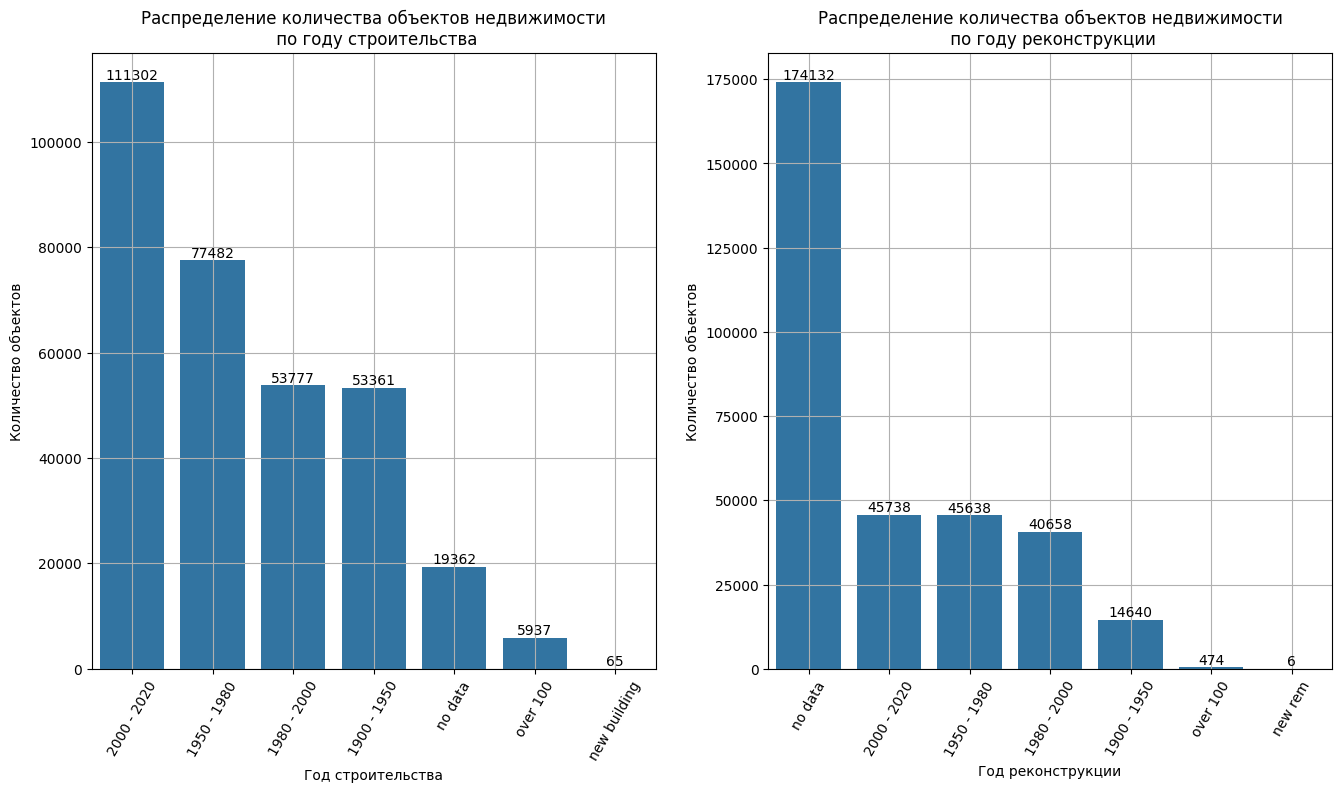

In [124]:
data18 = data['age building'].value_counts().reset_index()
data19 = data['age remodeled'].value_counts().reset_index()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
sns.barplot(data18, x='age building', y='count', ax=axes[0])
axes[0].tick_params(axis='x', rotation=60)
axes[0].set_title('Распределение количества объектов недвижимости\n по году строительства')
axes[0].set_xlabel('Год строительства')
axes[0].set_ylabel('Количество объектов')
axes[0].bar_label(axes[0].containers[0])
axes[0].grid()
sns.barplot(data19, x='age remodeled', y='count', ax=axes[1])
axes[1].tick_params(axis='x', rotation=60)
axes[1].set_title('Распределение количества объектов недвижимости\n по году реконструкции')
axes[1].set_xlabel('Год реконструкции')
axes[1].set_ylabel('Количество объектов')
axes[1].bar_label(axes[1].containers[0])
axes[1].grid();
fig = axes[0].figure
fig.savefig('pic/pic14.png')

Рассмотрим распределение медианы цены

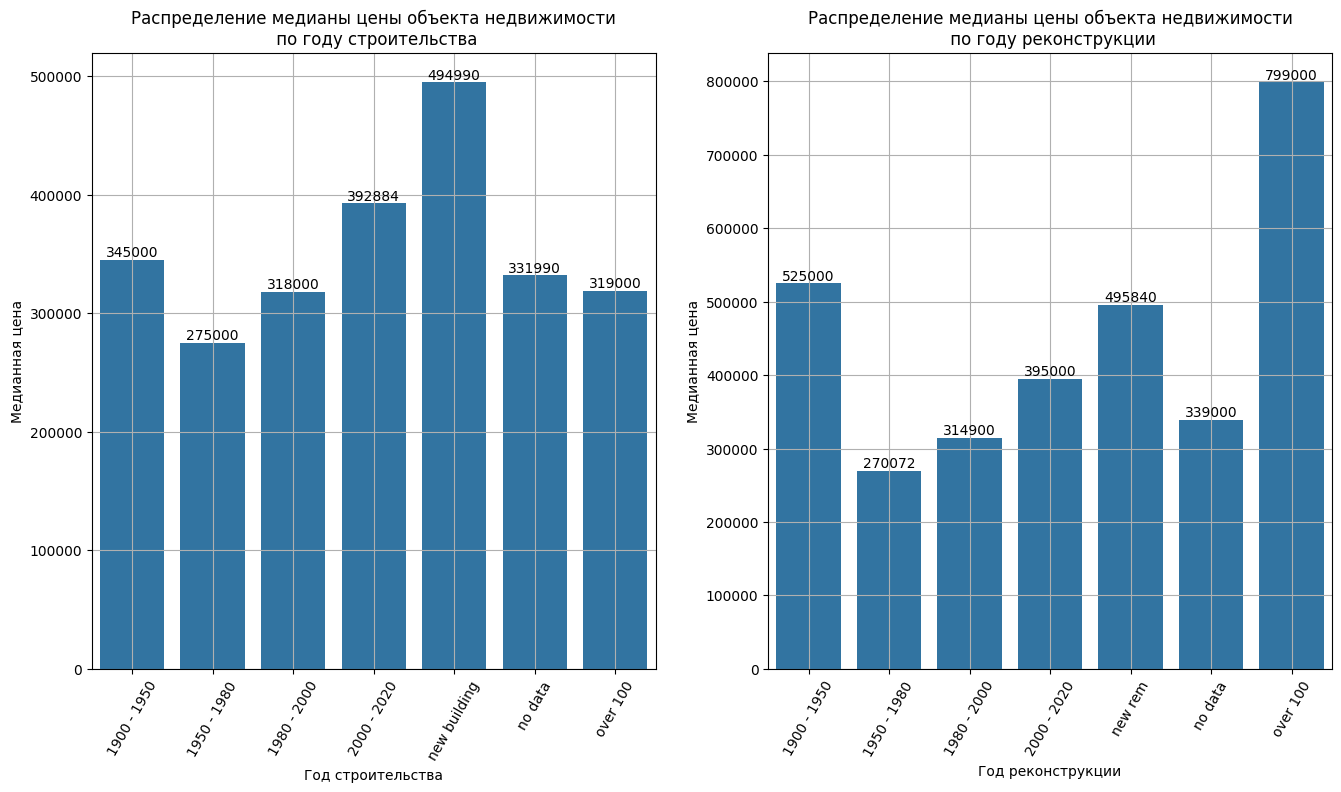

In [125]:
data20 = data.groupby('age building')['target'].median().reset_index()
data21 = data.groupby('age remodeled')['target'].median().reset_index()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
sns.barplot(data20, x='age building', y='target', ax=axes[0])
axes[0].tick_params(axis='x', rotation=60)
axes[0].set_title('Распределение медианы цены объекта недвижимости\n по году строительства')
axes[0].set_xlabel('Год строительства')
axes[0].set_ylabel('Медианная цена')
axes[0].bar_label(axes[0].containers[0])
axes[0].grid()
sns.barplot(data21, x='age remodeled', y='target', ax=axes[1])
axes[1].tick_params(axis='x', rotation=60)
axes[1].set_title('Распределение медианы цены объекта недвижимости\n по году реконструкции')
axes[1].set_xlabel('Год реконструкции')
axes[1].set_ylabel('Медианная цена')
axes[1].bar_label(axes[1].containers[0])
axes[1].grid();
fig = axes[0].figure
fig.savefig('pic/pic15.png')

Выводы:
1. По году строительства наибольшее количество объектов приходится на период 2000-2020, по году реконструкции - 'no data' отсутствуют данные.
2. Наибольшая медиана цены соответствует современным домам - 2020-2025, на втором месте - 2000-2020 годов строительства.
3. По году реконструкции наибольшая медиана соответствует строениям, прошедшим реконструкцию более 100 лет назад.

Удалим старые признаки 'Year built' и 'Remodeled year'

In [126]:
data = data.drop(['Year built', 'Remodeled year'], axis=1)

4.6 Признаки 'min_dist', 'max_rating' и 'num_schools'

Преобразуем значения признака 'min_dist' в категориальные значения

In [127]:
def get_distance(elem):
    
    if elem == 'no data':
        return elem
    elif elem <= 0.5:
        return 'less 0.5 mi'
    elif elem <= 1.0:
        return 'less 1 mi'
    elif elem <= 2.0:
        return 'less 2 mi'
    elif elem <= 3.0:
        return 'less 3 mi'
    elif elem <= 5.0:
        return 'less 5 mi'
    else: 
        return 'over 5 mi'

In [128]:
data['min_dist_to_school'] = data['min_dist'].apply(get_distance)

Рассмотрим распределение количества объектов и медианы цены в зависимости от расстояния до близжайшей школы

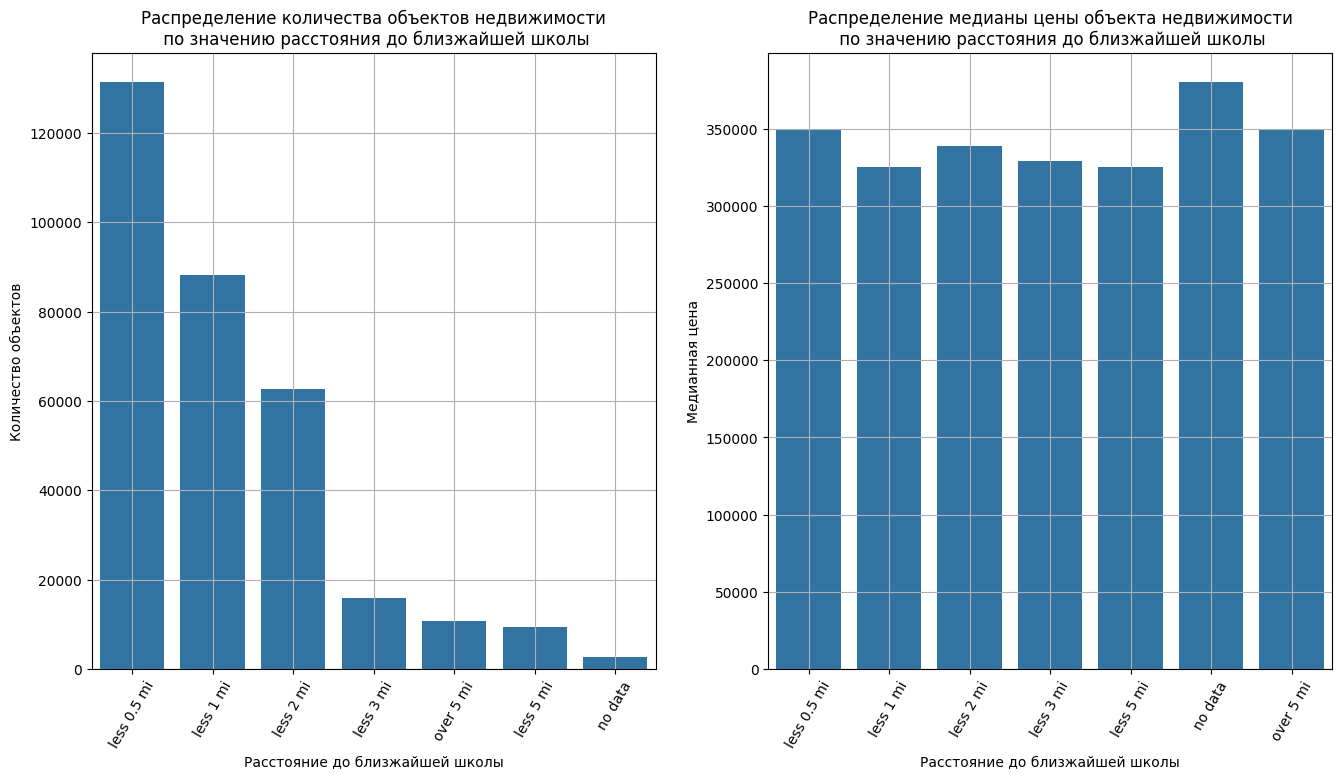

In [129]:
data22 = data['min_dist_to_school'].value_counts().reset_index()
data23 = data.groupby('min_dist_to_school')['target'].median().reset_index()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
sns.barplot(data22, x='min_dist_to_school', y='count', ax=axes[0])
axes[0].tick_params(axis='x', rotation=60)
axes[0].set_title('Распределение количества объектов недвижимости\n по значению расстояния до близжайшей школы')
axes[0].set_xlabel('Расстояние до близжайшей школы')
axes[0].set_ylabel('Количество объектов')
axes[0].grid()
sns.barplot(data23, x='min_dist_to_school', y='target', ax=axes[1])
axes[1].tick_params(axis='x', rotation=60)
axes[1].set_title('Распределение медианы цены объекта недвижимости\n по значению расстояния до близжайшей школы')
axes[1].set_xlabel('Расстояние до близжайшей школы')
axes[1].set_ylabel('Медианная цена')
axes[1].grid();
fig = axes[0].figure
fig.savefig('pic/pic16.png')

У наибольшего количества объектов ближайшая школа находится на рассотянии порядка полумили. При этом само расстояние практически не влияет на медиану цены.


Аналогично рассмотрим распределение количества объектов и медианы цены в зависимости от значения признаков 'max_rating' и 'num_schools'

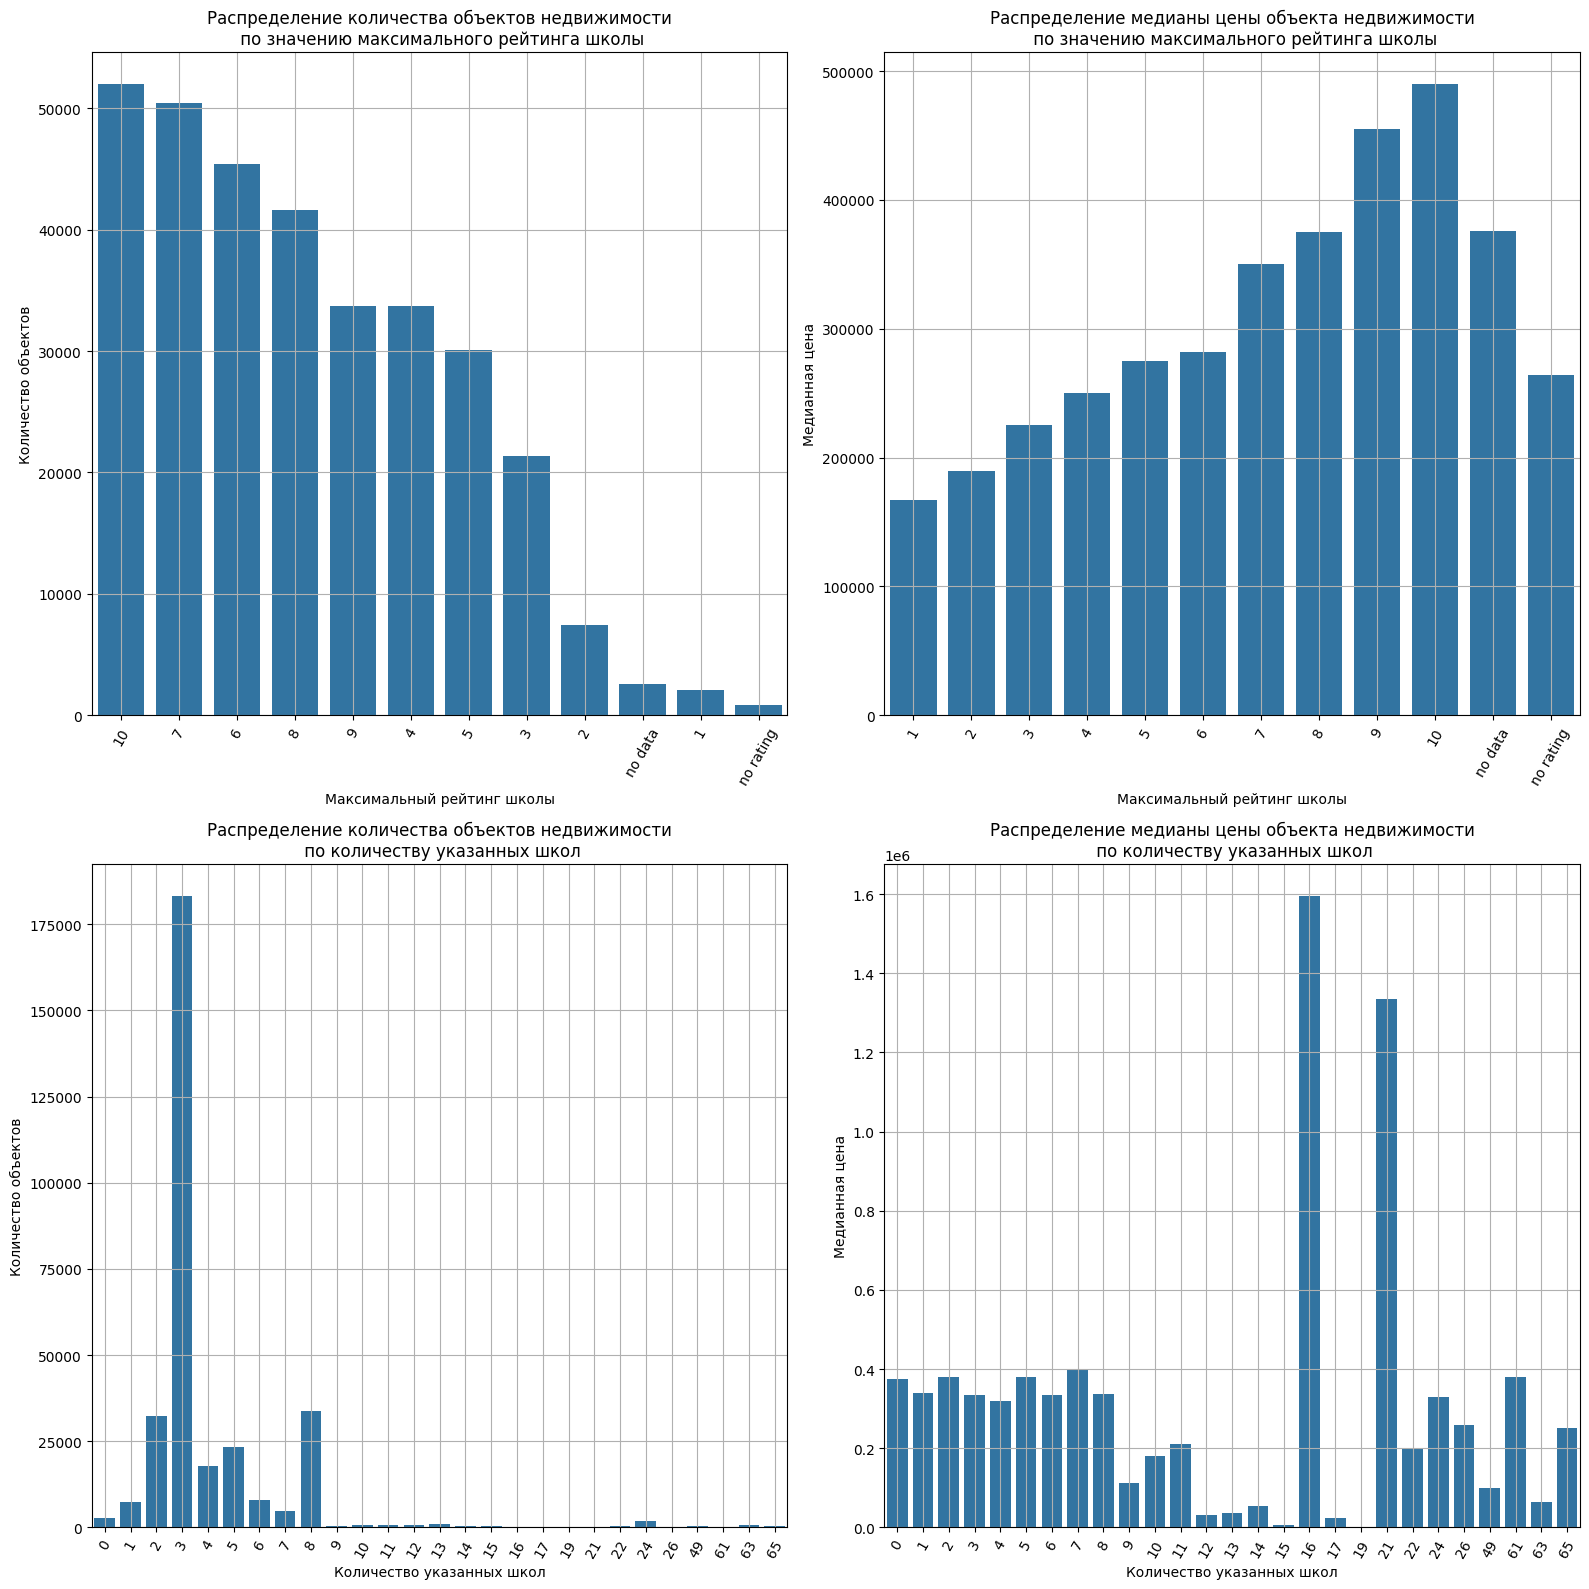

In [130]:
data24 = data['max_rating'].value_counts().reset_index()
data25 = data.groupby('max_rating')['target'].median().reset_index()
data26 = data['num_schools'].value_counts().reset_index()
data27 = data.groupby('num_schools')['target'].median().reset_index()

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 16))
sns.barplot(data24, x='max_rating', y='count', ax=axes[0][0])
axes[0][0].tick_params(axis='x', rotation=60)
axes[0][0].set_title('Распределение количества объектов недвижимости\n по значению максимального рейтинга школы')
axes[0][0].set_xlabel('Максимальный рейтинг школы')
axes[0][0].set_ylabel('Количество объектов')
axes[0][0].grid()
sns.barplot(data25, x='max_rating', y='target', ax=axes[0][1])
axes[0][1].tick_params(axis='x', rotation=60)
axes[0][1].set_title('Распределение медианы цены объекта недвижимости\n по значению максимального рейтинга школы')
axes[0][1].set_xlabel('Максимальный рейтинг школы')
axes[0][1].set_ylabel('Медианная цена')
axes[0][1].grid()
sns.barplot(data26, x='num_schools', y='count', ax=axes[1][0])
axes[1][0].tick_params(axis='x', rotation=60)
axes[1][0].set_title('Распределение количества объектов недвижимости\n по количеству указанных школ')
axes[1][0].set_xlabel('Количество указанных школ')
axes[1][0].set_ylabel('Количество объектов')
axes[1][0].grid()
sns.barplot(data27, x='num_schools', y='target', ax=axes[1][1])
axes[1][1].tick_params(axis='x', rotation=60)
axes[1][1].set_title('Распределение медианы цены объекта недвижимости\n по количеству указанных школ')
axes[1][1].set_xlabel('Количество указанных школ')
axes[1][1].set_ylabel('Медианная цена')
axes[1][1].grid()
plt.tight_layout();
fig = axes[0][0].figure
fig.savefig('pic/pic17.png')

Выводы:
1. Для наибольшего количества объектов указан самый высокий рейтинг - 10. И имеено ему соответствует максимальная медиана цены.
2. Для наибольшего количества объектов указано 3 школы, максимальные значения медианы цены приходится на 16 и 21 указанную школу. 

4.7 Признак 'type house'

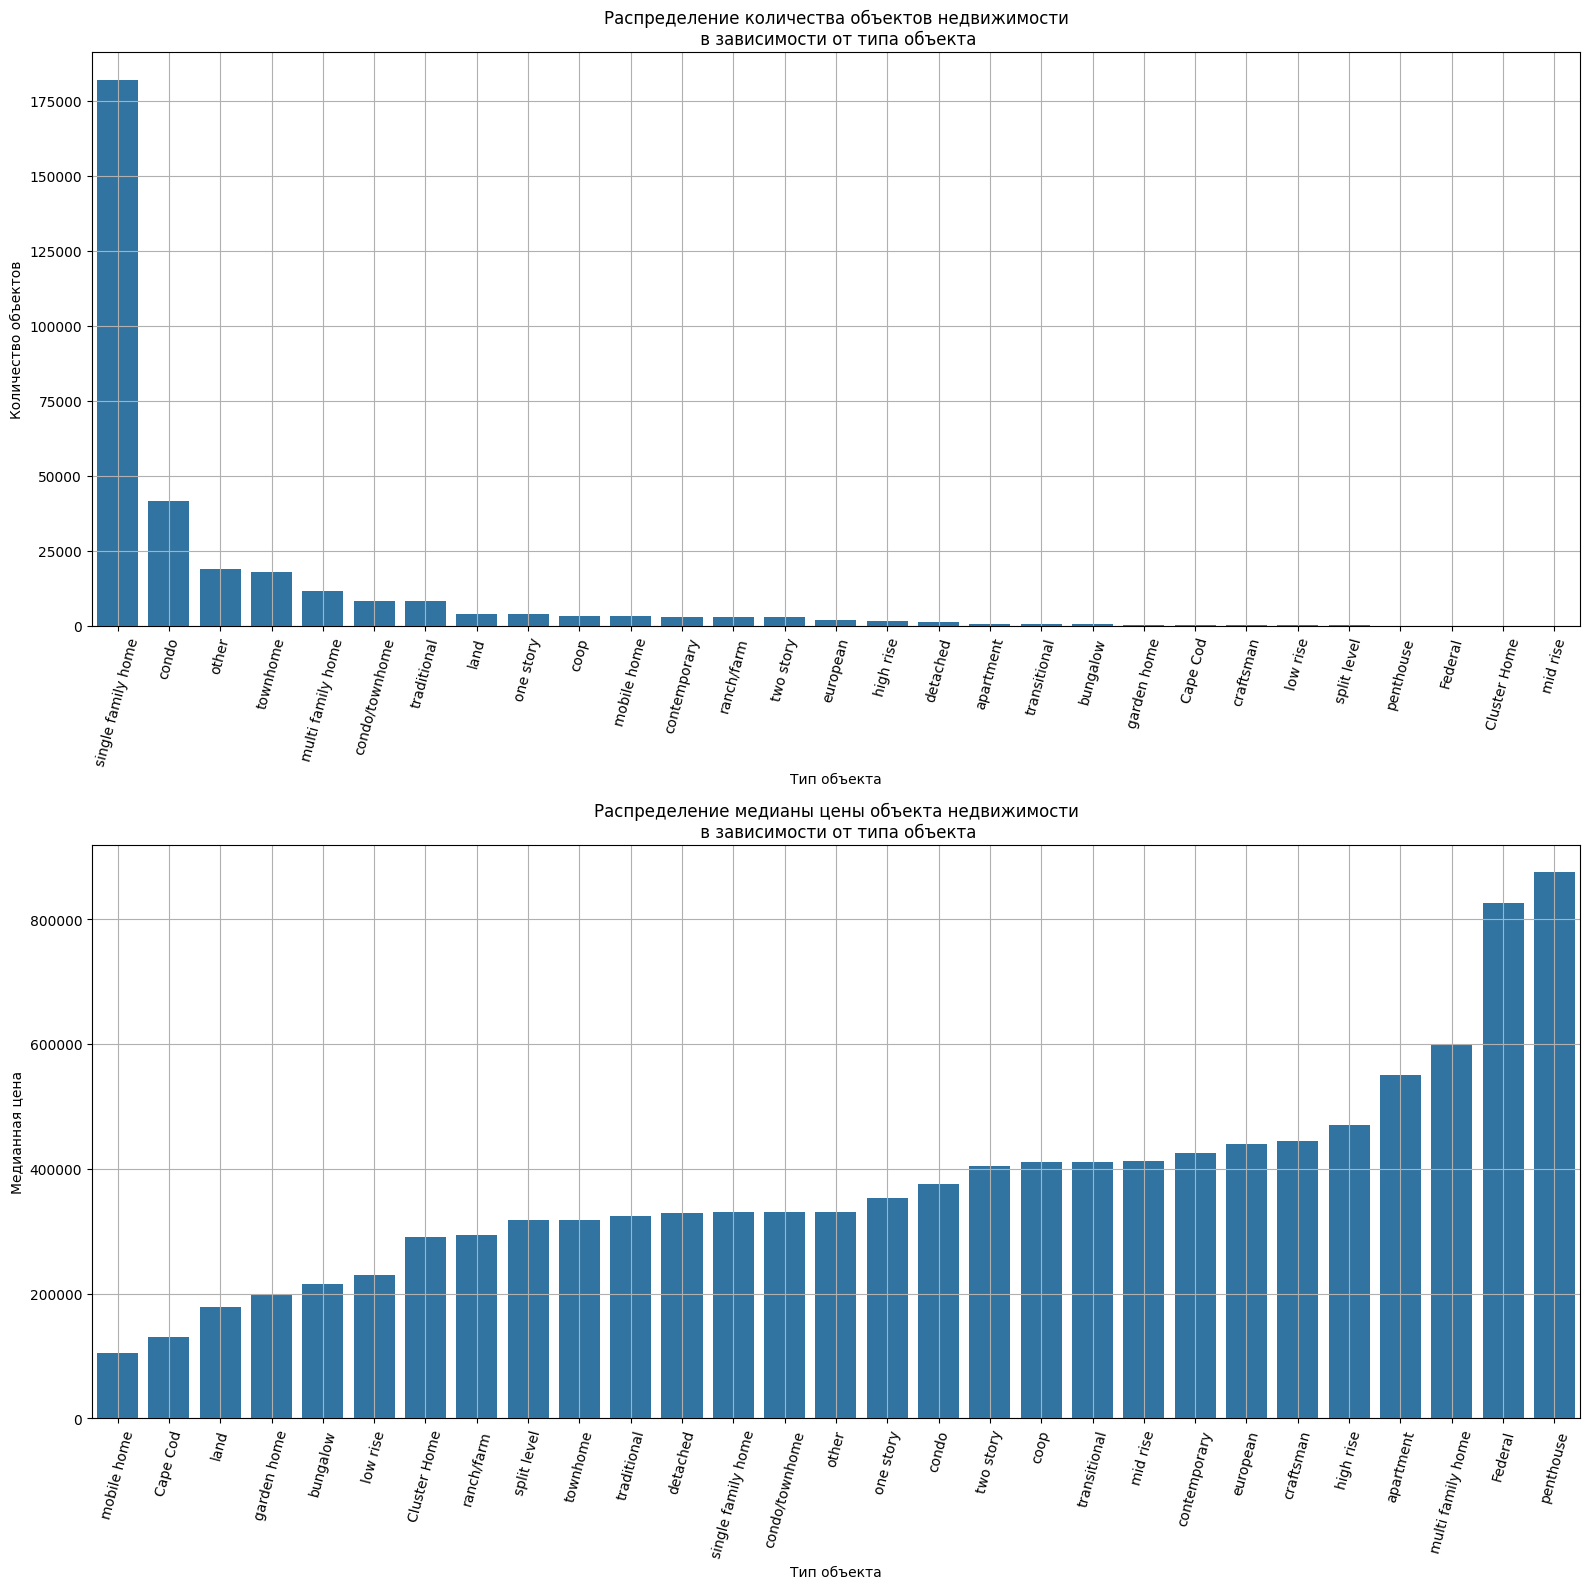

In [131]:
data28 = data['type house'].value_counts().reset_index()
data29 = data.groupby('type house')['target'].median().reset_index().sort_values(by='target')

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(16, 16))
sns.barplot(data28, x='type house', y='count', ax=axes[0])
axes[0].tick_params(axis='x', rotation=75)
axes[0].set_title('Распределение количества объектов недвижимости\n в зависимости от типа объекта')
axes[0].set_xlabel('Тип объекта')
axes[0].set_ylabel('Количество объектов')
axes[0].grid()
sns.barplot(data29, x='type house', y='target', ax=axes[1])
axes[1].tick_params(axis='x', rotation=75)
axes[1].set_title('Распределение медианы цены объекта недвижимости\n в зависимости от типа объекта')
axes[1].set_xlabel('Тип объекта')
axes[1].set_ylabel('Медианная цена')
axes[1].grid()
plt.tight_layout();
fig = axes[0].figure
fig.savefig('pic/pic18.png')

Выводы:
1. Наибольшее количество записей приходится на тип 'single family home' дом для одной семьи.
2. Наибольшая медиана цены приходится на пентхаус.

4.8 Признак 'bathrooms' и 'bedrooms'

Также рассмотрим распределения количества объектов и медианы цены

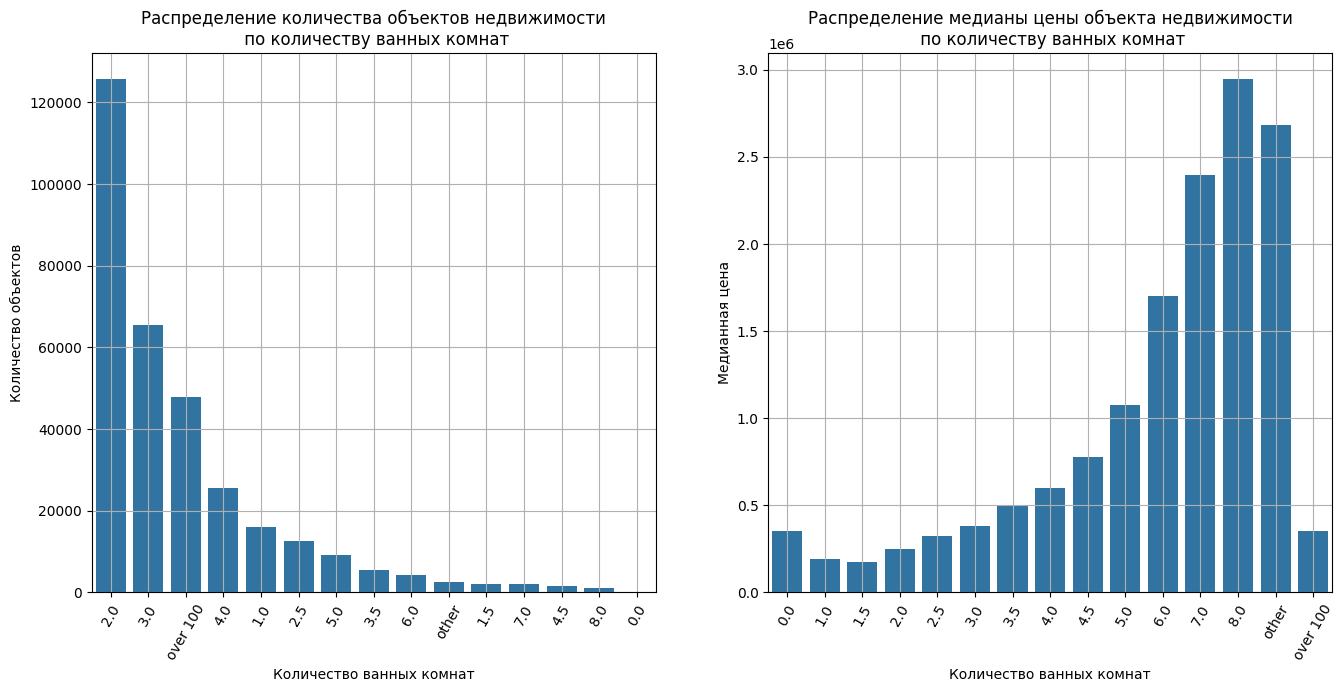

In [132]:
data30 = data['bathrooms'].value_counts().reset_index()
data31 = data.groupby('bathrooms')['target'].median().reset_index()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 7))
sns.barplot(data30, x='bathrooms', y='count', ax=axes[0])
axes[0].tick_params(axis='x', rotation=60)
axes[0].set_title('Распределение количества объектов недвижимости\n по количеству ванных комнат')
axes[0].set_xlabel('Количество ванных комнат')
axes[0].set_ylabel('Количество объектов')
axes[0].grid()
sns.barplot(data31, x='bathrooms', y='target', ax=axes[1])
axes[1].tick_params(axis='x', rotation=60)
axes[1].set_title('Распределение медианы цены объекта недвижимости\n по количеству ванных комнат')
axes[1].set_xlabel('Количество ванных комнат')
axes[1].set_ylabel('Медианная цена')
axes[1].grid()
fig = axes[0].figure
fig.savefig('pic/pic19.png')

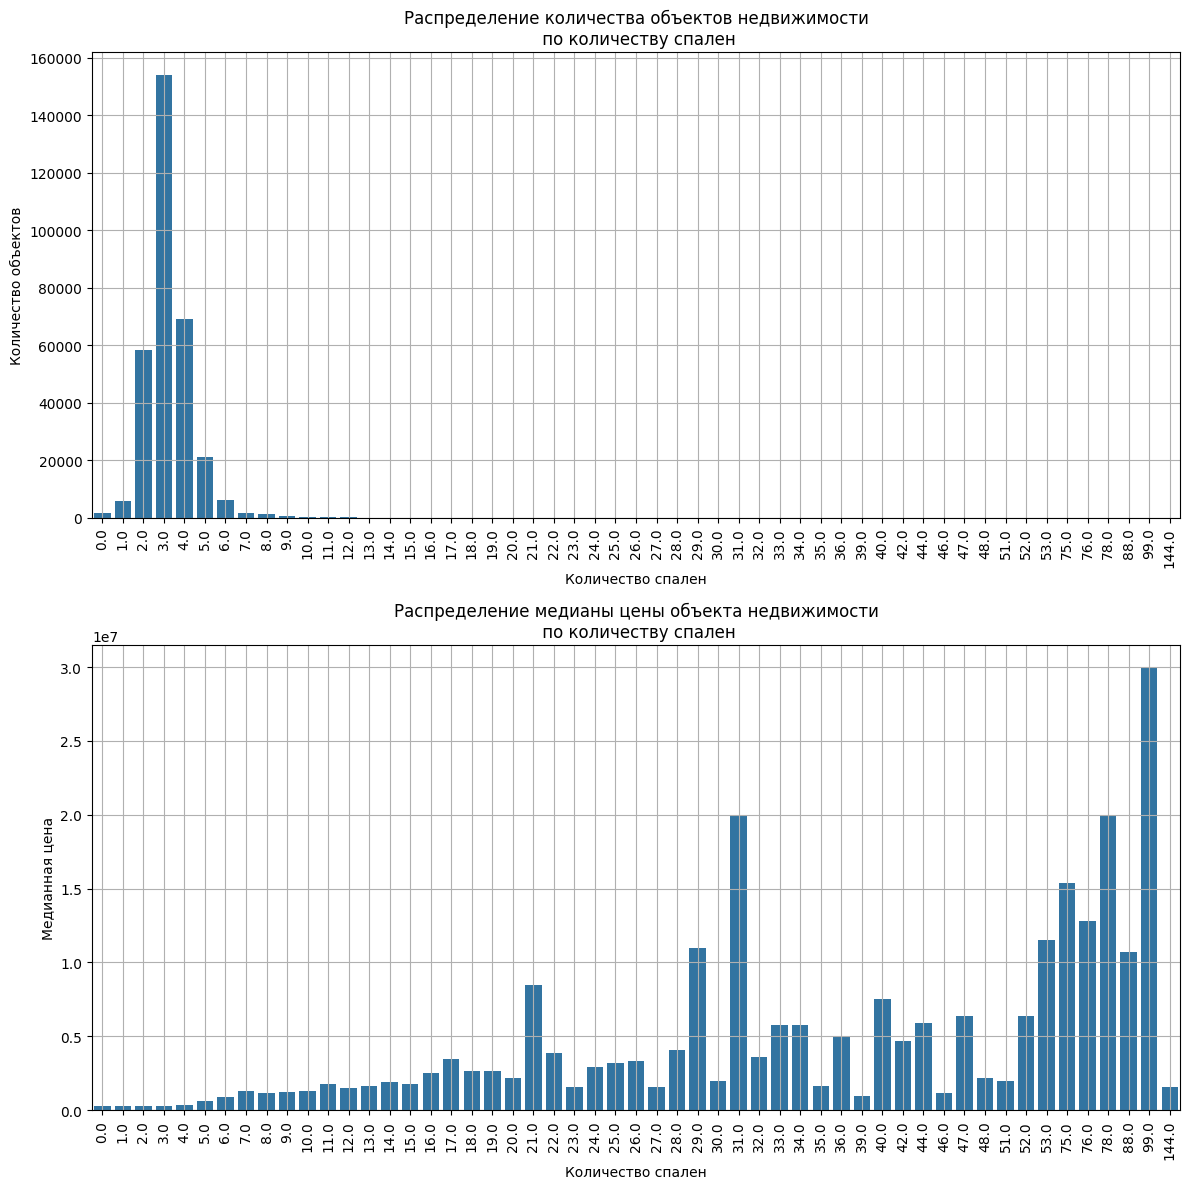

In [133]:
data32 = data['bedrooms'].value_counts().reset_index()
data33 = data.groupby('bedrooms')['target'].median().reset_index()

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 12))
sns.barplot(data32, x='bedrooms', y='count', ax=axes[0])
axes[0].tick_params(axis='x', rotation=90)
axes[0].set_title('Распределение количества объектов недвижимости\n по количеству спален')
axes[0].set_xlabel('Количество спален')
axes[0].set_ylabel('Количество объектов')
axes[0].grid()
sns.barplot(data33, x='bedrooms', y='target', ax=axes[1])
axes[1].tick_params(axis='x', rotation=90)
axes[1].set_title('Распределение медианы цены объекта недвижимости\n по количеству спален')
axes[1].set_xlabel('Количество спален')
axes[1].set_ylabel('Медианная цена')
axes[1].grid()
plt.tight_layout();
fig = axes[0].figure
fig.savefig('pic/pic20.png')

Выводы:
1. Наибольшее количество объектов имеет 2 этажа (возможно искажение данных из-за большого количества пропусков, заполненых модой).
2. Наблюдается рост медианы цены с ростом количества этажей с 0 до 8. Значения более 100 скорее всего ошибка заполнения данных.
3. Наибольшее количество объектов имеет 3 спальни (возможно искажение данных из-за большого количества пропусков, заполненых модой).
4. Распределение медианы по количеству спален не подвергается точному анализу.

4.8 Признак 'degree_lot'

Рассмотрим распределения количества объектов и медианы цены

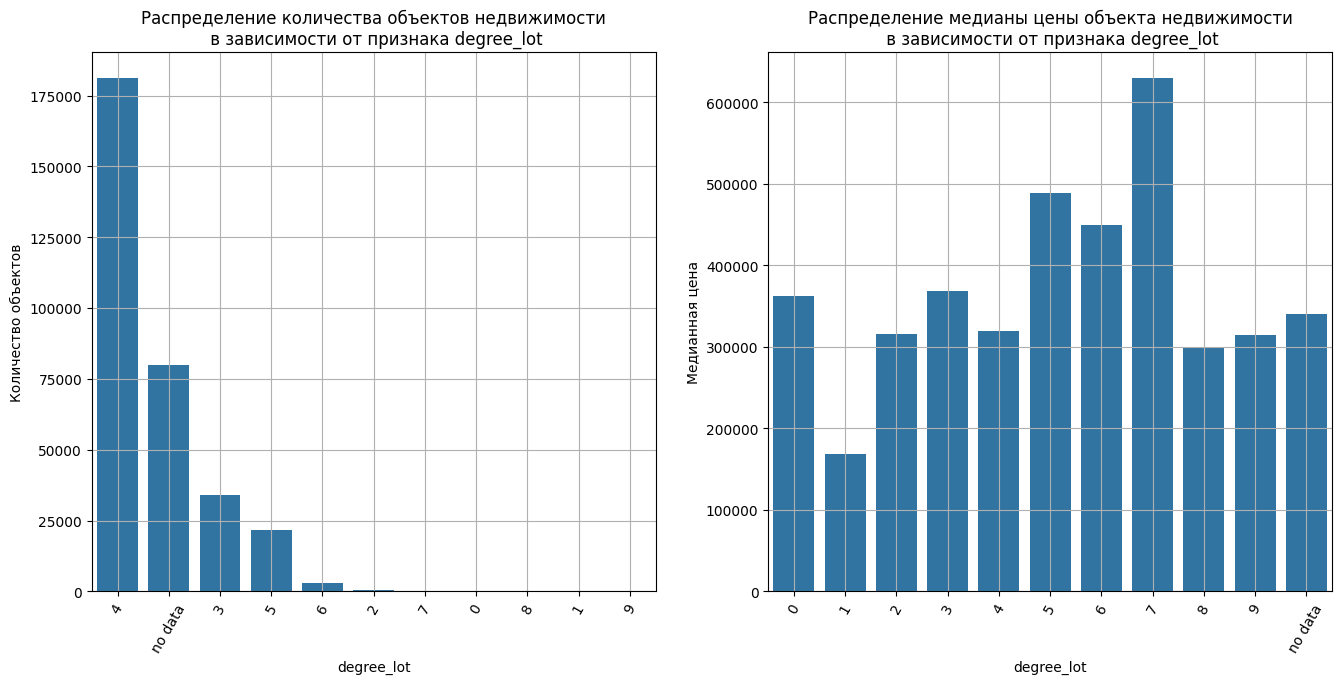

In [134]:
data34 = data['degree_lot'].value_counts().reset_index()
data35 = data.groupby('degree_lot')['target'].median().reset_index()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 7))
sns.barplot(data34, x='degree_lot', y='count', ax=axes[0])
axes[0].tick_params(axis='x', rotation=60)
axes[0].set_title('Распределение количества объектов недвижимости\n в зависимости от признака degree_lot')
axes[0].set_ylabel('Количество объектов')
axes[0].grid()
sns.barplot(data35, x='degree_lot', y='target', ax=axes[1])
axes[1].tick_params(axis='x', rotation=60)
axes[1].set_title('Распределение медианы цены объекта недвижимости\n в зависимости от признака degree_lot')
axes[1].set_ylabel('Медианная цена')
axes[1].grid()
fig = axes[0].figure
fig.savefig('pic/pic21.png')

Выводы:
1. Для большинства объектов значение признака соответствует 4, т.е. $10^4$.
2. Распределение медианы не носит четкой зависимости, максимум соответствует 7, т.е.  $10^7$.

### 5. Кодирование и нормирование признаков

5.1 Нормирование числовых признаков

Будем использовать MinMaxScaler()

In [ ]:
df = data.copy()
# Удалим более не нужные признаки
df = df.drop(['status', 'lotsize', 'min_dist'], axis=1)

In [136]:
col_num = ['log_sq', 'lat', 'lng']

mm_scaler = MinMaxScaler()
df_sc = mm_scaler.fit_transform(df[col_num])

df_sc = pd.DataFrame(df_sc, columns=col_num)

In [137]:
df[col_num] = df_sc[col_num]

5.2 Кодирование признаков
'stories', 'type house', 'bathrooms', 'bedrooms', 'max_rating', 'num_schools', 'degree_lot', 'city_status', 'age building', 'age remodeled', 'min_dist_to_school'

Будем использовать бинарное кодирование

In [138]:
list_col_bin = ['stories', 'type house', 'bathrooms', 'bedrooms', 'max_rating', 'num_schools', 'city_status', 'degree_lot', 'age building', 'age remodeled', 'min_dist_to_school']

bin_encoder = ce.BinaryEncoder(cols=list_col_bin)
df = bin_encoder.fit_transform(df)

df.head()

fireplace  stories_0  stories_1  stories_2  stories_3  stories_4  \
0          1          0          0          0          0          0   
1          0          0          0          0          0          0   
2          1          0          0          0          0          0   
3          1          0          0          0          0          0   
4          0          0          0          0          0          0   

   stories_5  stories_6     target  pool  ...  city_status_2  age building_0  \
0          0          1   418000.0     0  ...              1               0   
1          1          0   310000.0     0  ...              0               0   
2          0          1  2895000.0     1  ...              1               0   
3          1          1  2395000.0     0  ...              0               0   
4          1          0   209000.0     0  ...              0               0   

   age building_1  age building_2  age remodeled_0  age remodeled_1  \
0               0               1                0                0   
1               0               1                0                0   
2               1               0                0                1   
3               0               1                0                1   
4               1               1                0                0   

   age remodeled_2  min_dist_to_school_0  min_dist_to_school_1  \
0                1                     0                     0   
1                1                     0                     1   
2                0                     0                     1   
3                1                     0                     1   
4                1                     1                     0   

   min_dist_to_school_2  
0                     1  
1                     0  
2                     0  
3                     1  
4                     0  

[5 rows x 57 columns]

Рассмотрим корреляцию в данных

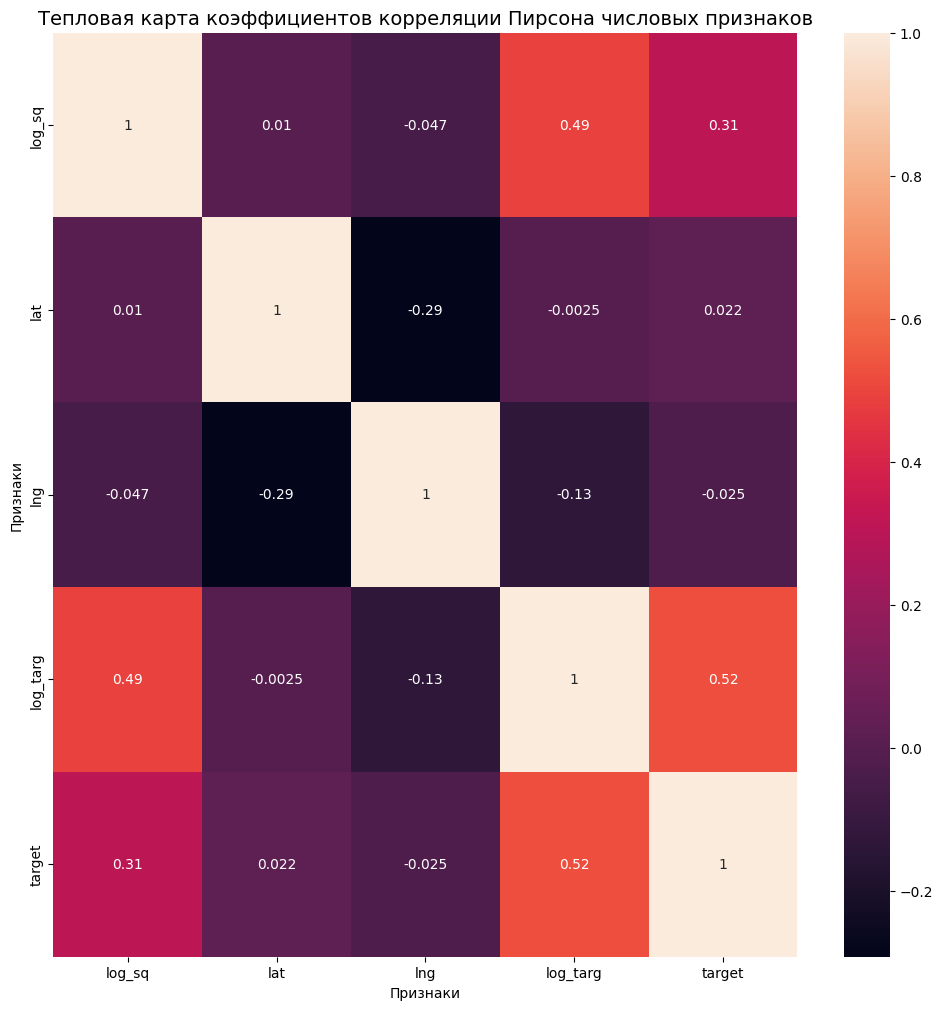

In [139]:
num_col = ['log_sq', 'lat', 'lng', 'log_targ', 'target']

fig= plt.figure(figsize=(12, 12))
ax = sns.heatmap(df[num_col].corr(), annot=True)
ax.set_title('Тепловая карта коэффициентов корреляции Пирсона числовых признаков', fontsize=14)
ax.set_xlabel('Признаки')
ax.set_ylabel('Признаки');
fig = ax.figure
fig.savefig('pic/pic22.png')

In [140]:
cat_fear = list(set(df.columns) - set(num_col))
cat_fear = cat_fear + ['log_targ', 'target']

In [141]:
len(cat_fear)

54

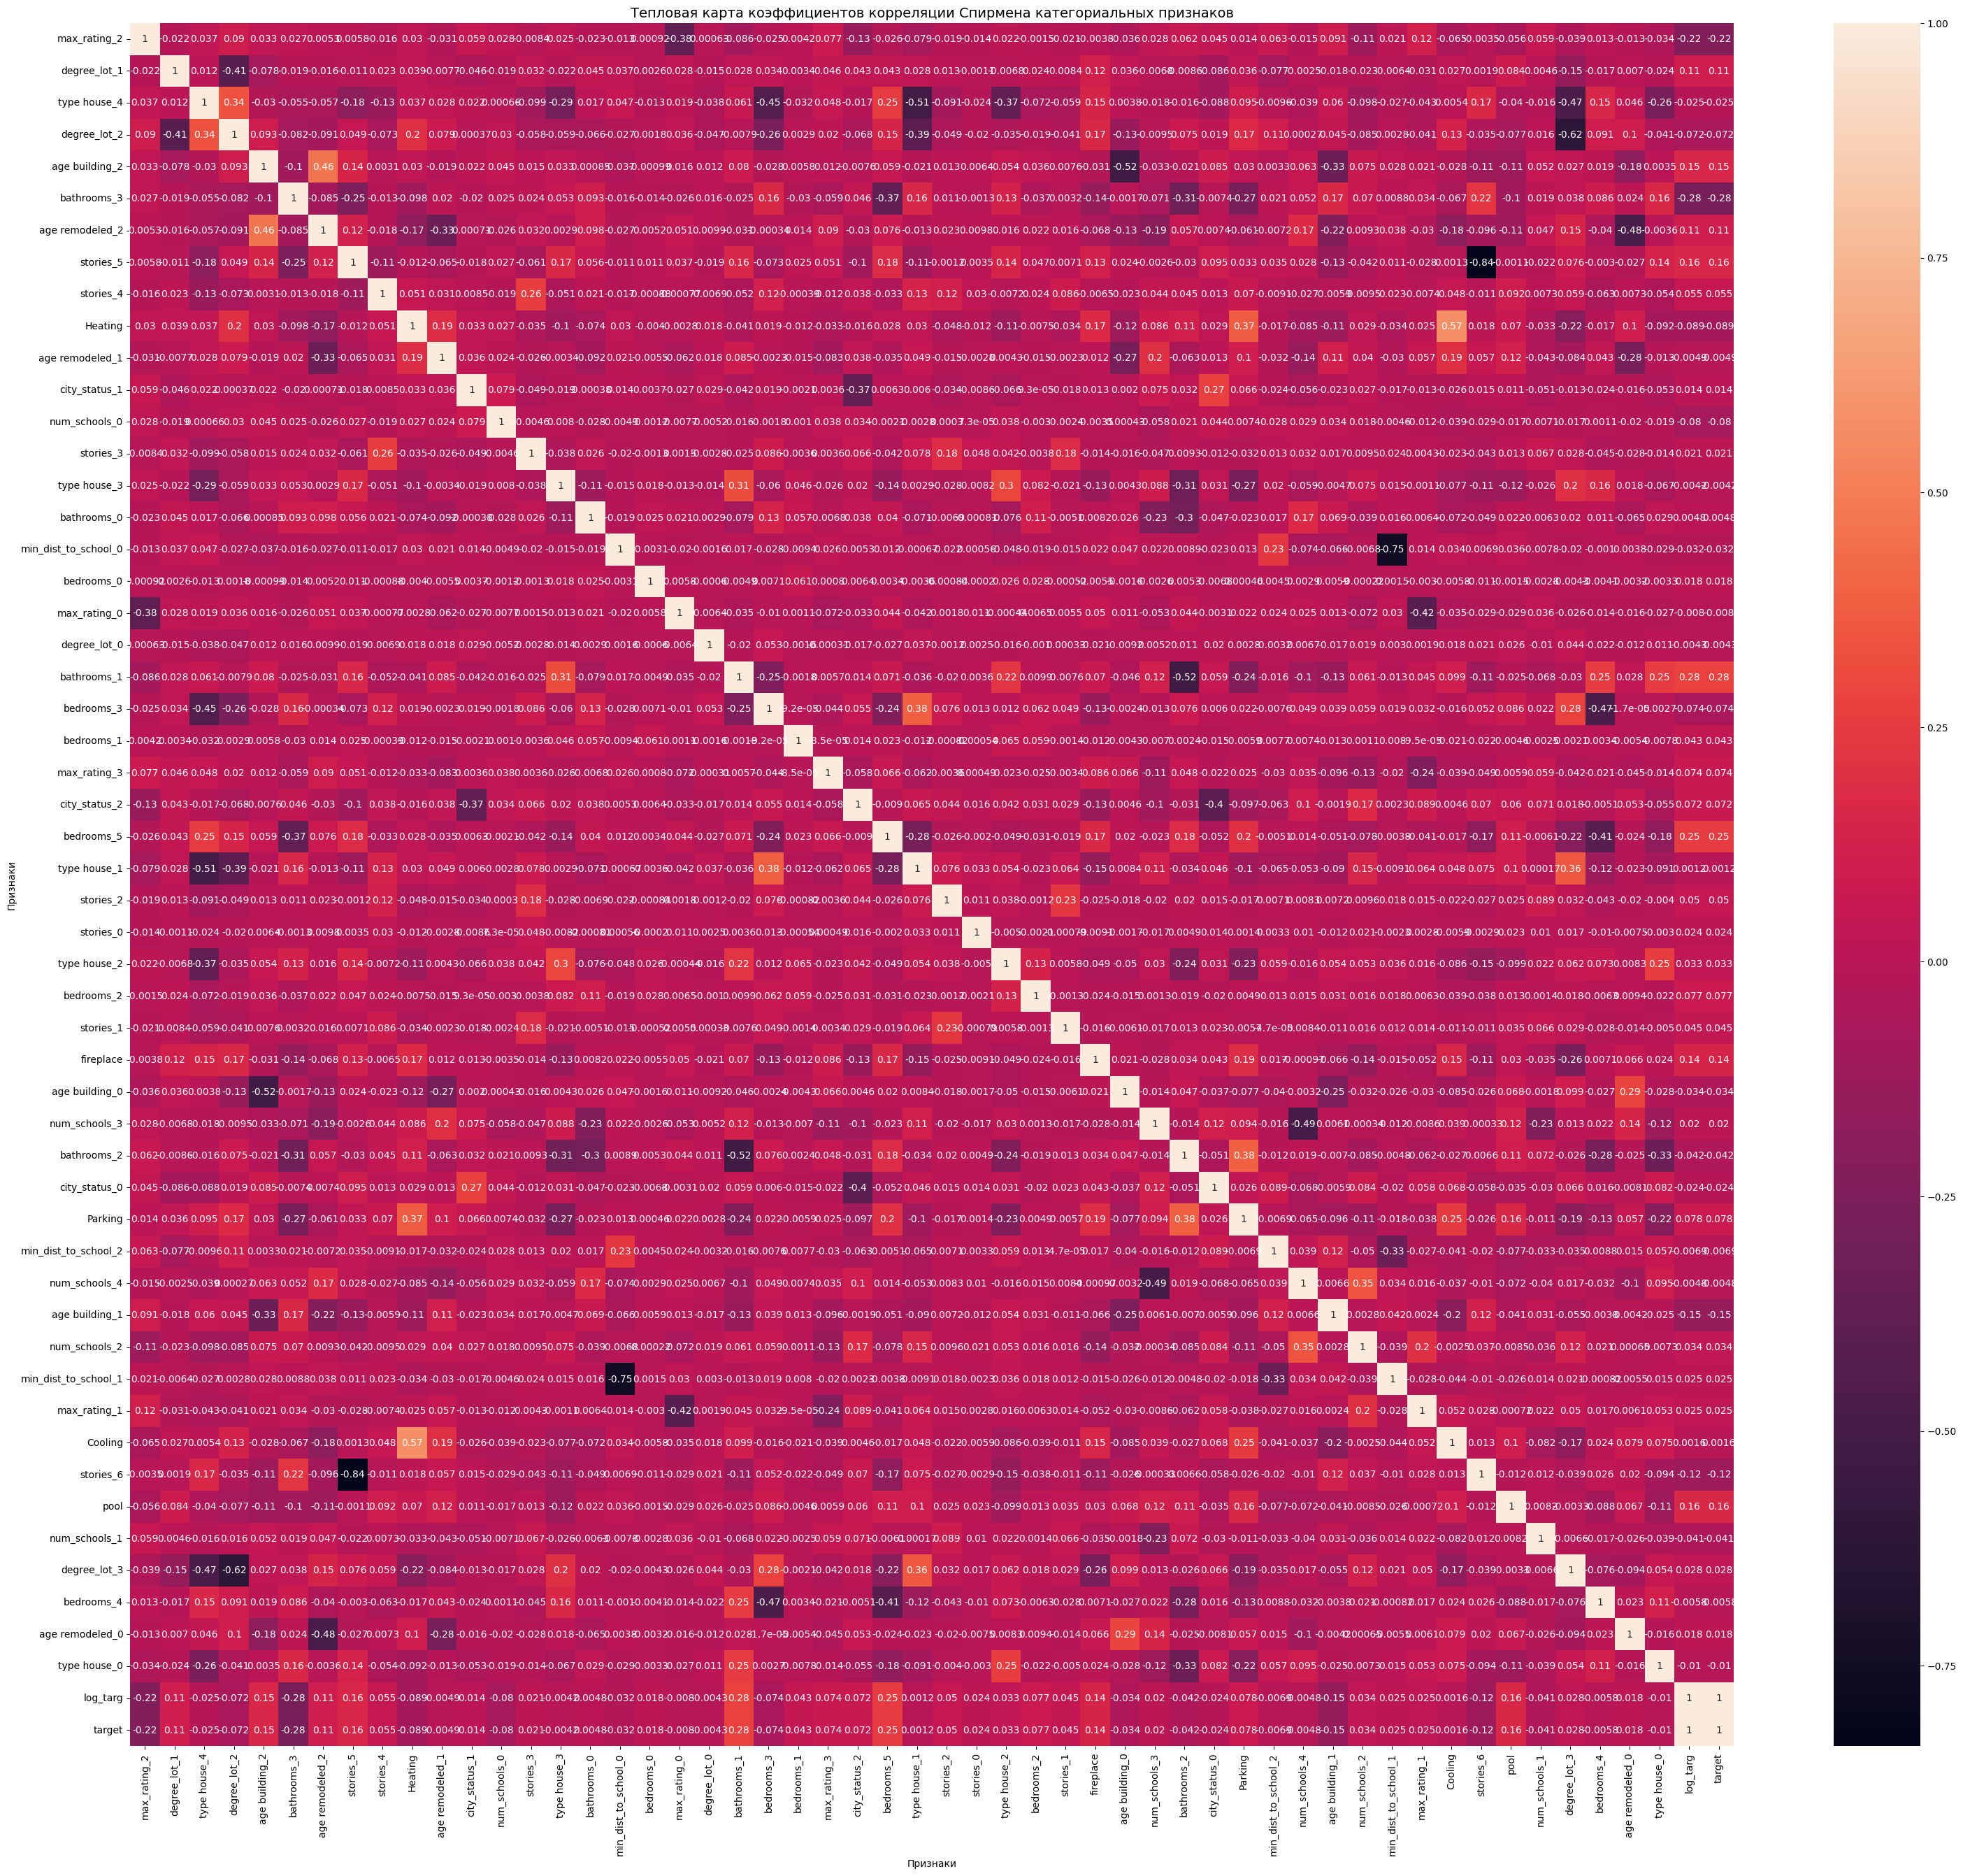

In [142]:
fig = plt.figure(figsize=(37, 32))
ax = sns.heatmap(df[cat_fear].corr(method='spearman'), annot=True)
ax.set_title('Тепловая карта коэффициентов корреляции Спирмена категориальных признаков', fontsize=14)
ax.set_xlabel('Признаки')
ax.set_ylabel('Признаки');
fig = ax.figure
fig.savefig('pic/pic23.png')

Сильной связи не обнаружено.

### 6. Обучение модели

Разделим датасет на признаки и целевую переменную, сейчас у нас она выражена двумя колонками - 'log_targ' и 'target'

In [143]:
X = df.drop(['log_targ', 'target'], axis = 1)
y = df[['target', 'log_targ']]

Рассмотрим значимость признаков с помощью chi2 и f_classif

In [144]:
col_list = list(X.columns)
# Разделим значение целевой переменной и её логарифм
y_gr=y['target'].astype('int')
y_gr_log = y['log_targ'].astype('int')

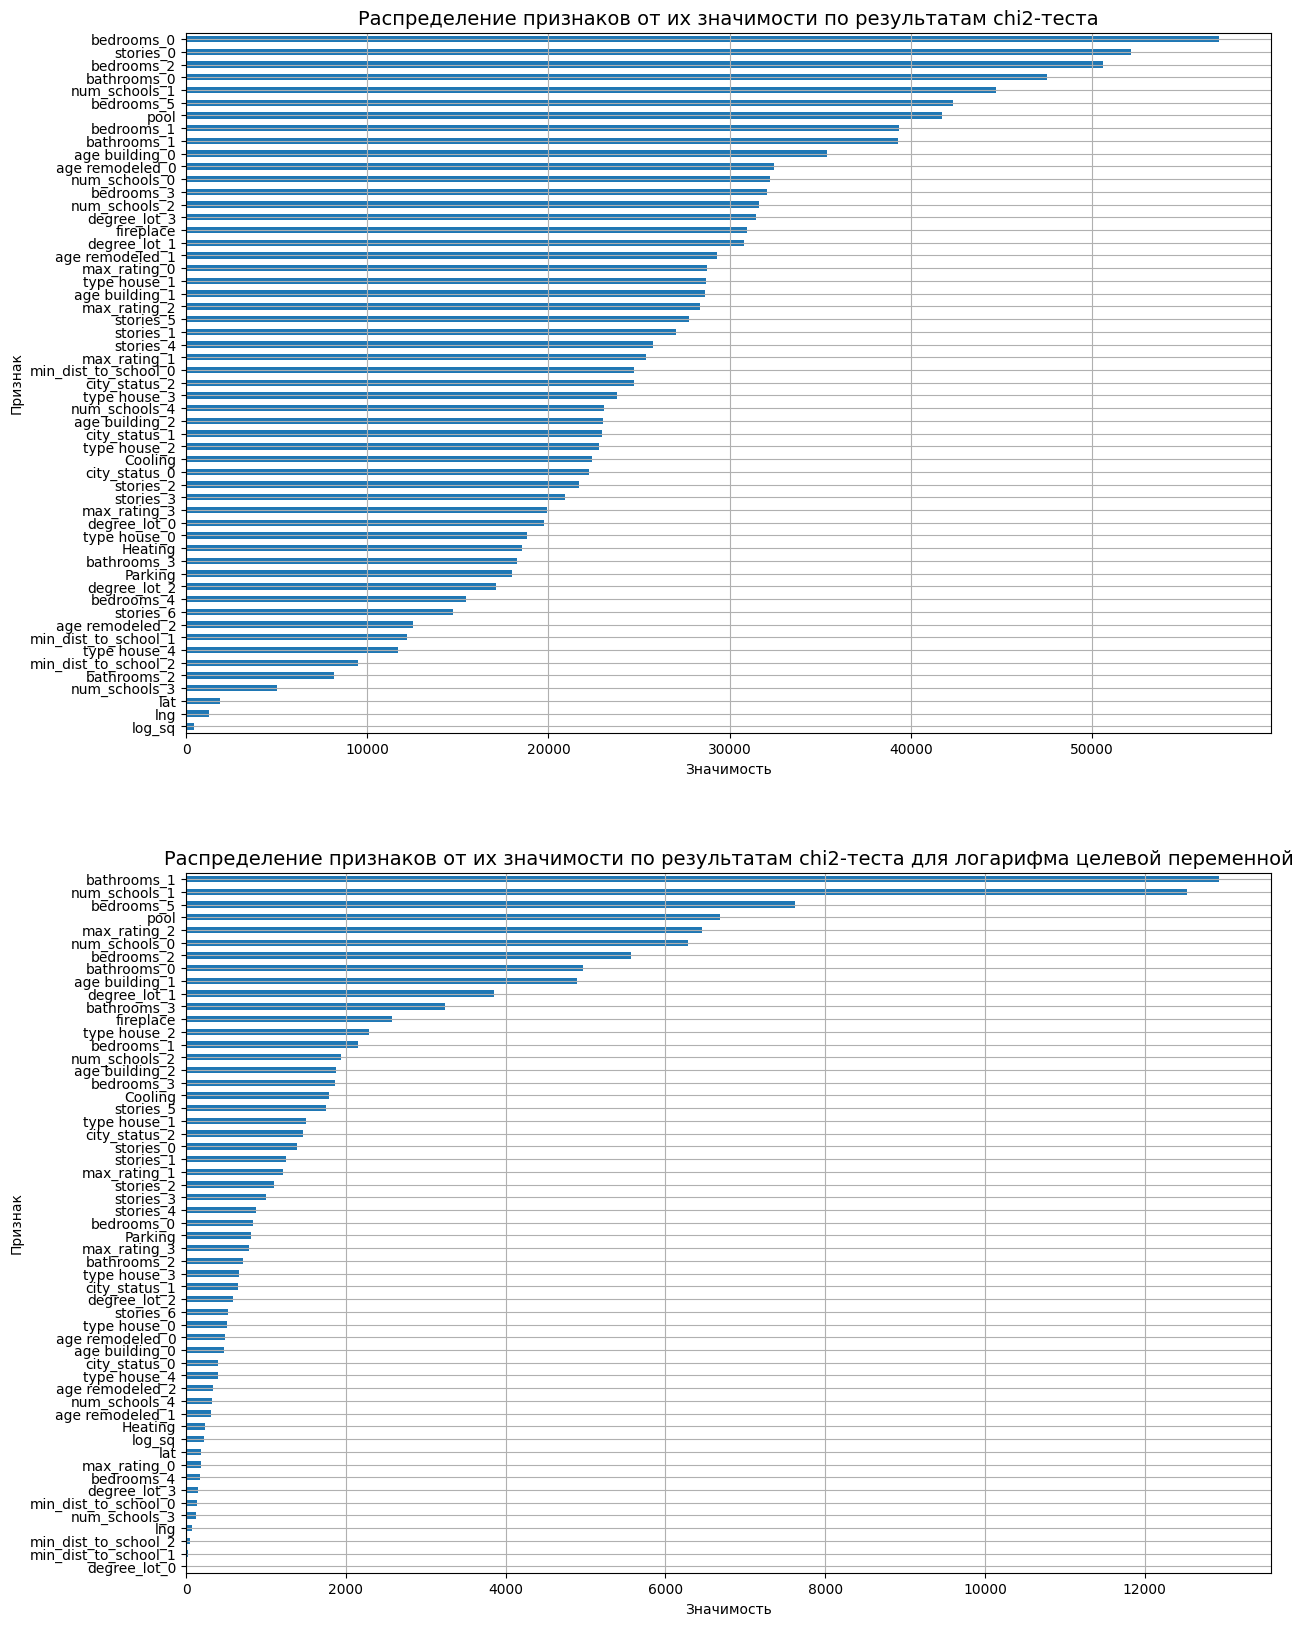

In [145]:
from sklearn.feature_selection import chi2 # хи-квадрат

imp_cat = pd.Series(chi2(X[col_list].abs(), y_gr)[0], index=col_list)
imp_cat.sort_values(inplace = True)
imp_cat_log = pd.Series(chi2(X[col_list].abs(), y_gr_log)[0], index=col_list)
imp_cat_log.sort_values(inplace = True)

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(14, 20))
imp_cat.plot(kind = 'barh', ax=ax[0])
ax[0].grid()
ax[0].set_title('Распределение признаков от их значимости по результатам chi2-теста', fontsize=14)
ax[0].set_xlabel('Значимость')
ax[0].set_ylabel('Признак')
imp_cat_log.plot(kind = 'barh', ax=ax[1])
ax[1].grid()
ax[1].set_title('Распределение признаков от их значимости по результатам chi2-теста для логарифма целевой переменной', fontsize=14)
ax[1].set_xlabel('Значимость')
ax[1].set_ylabel('Признак');
fig = ax[0].figure
fig.savefig('pic/pic24.png')

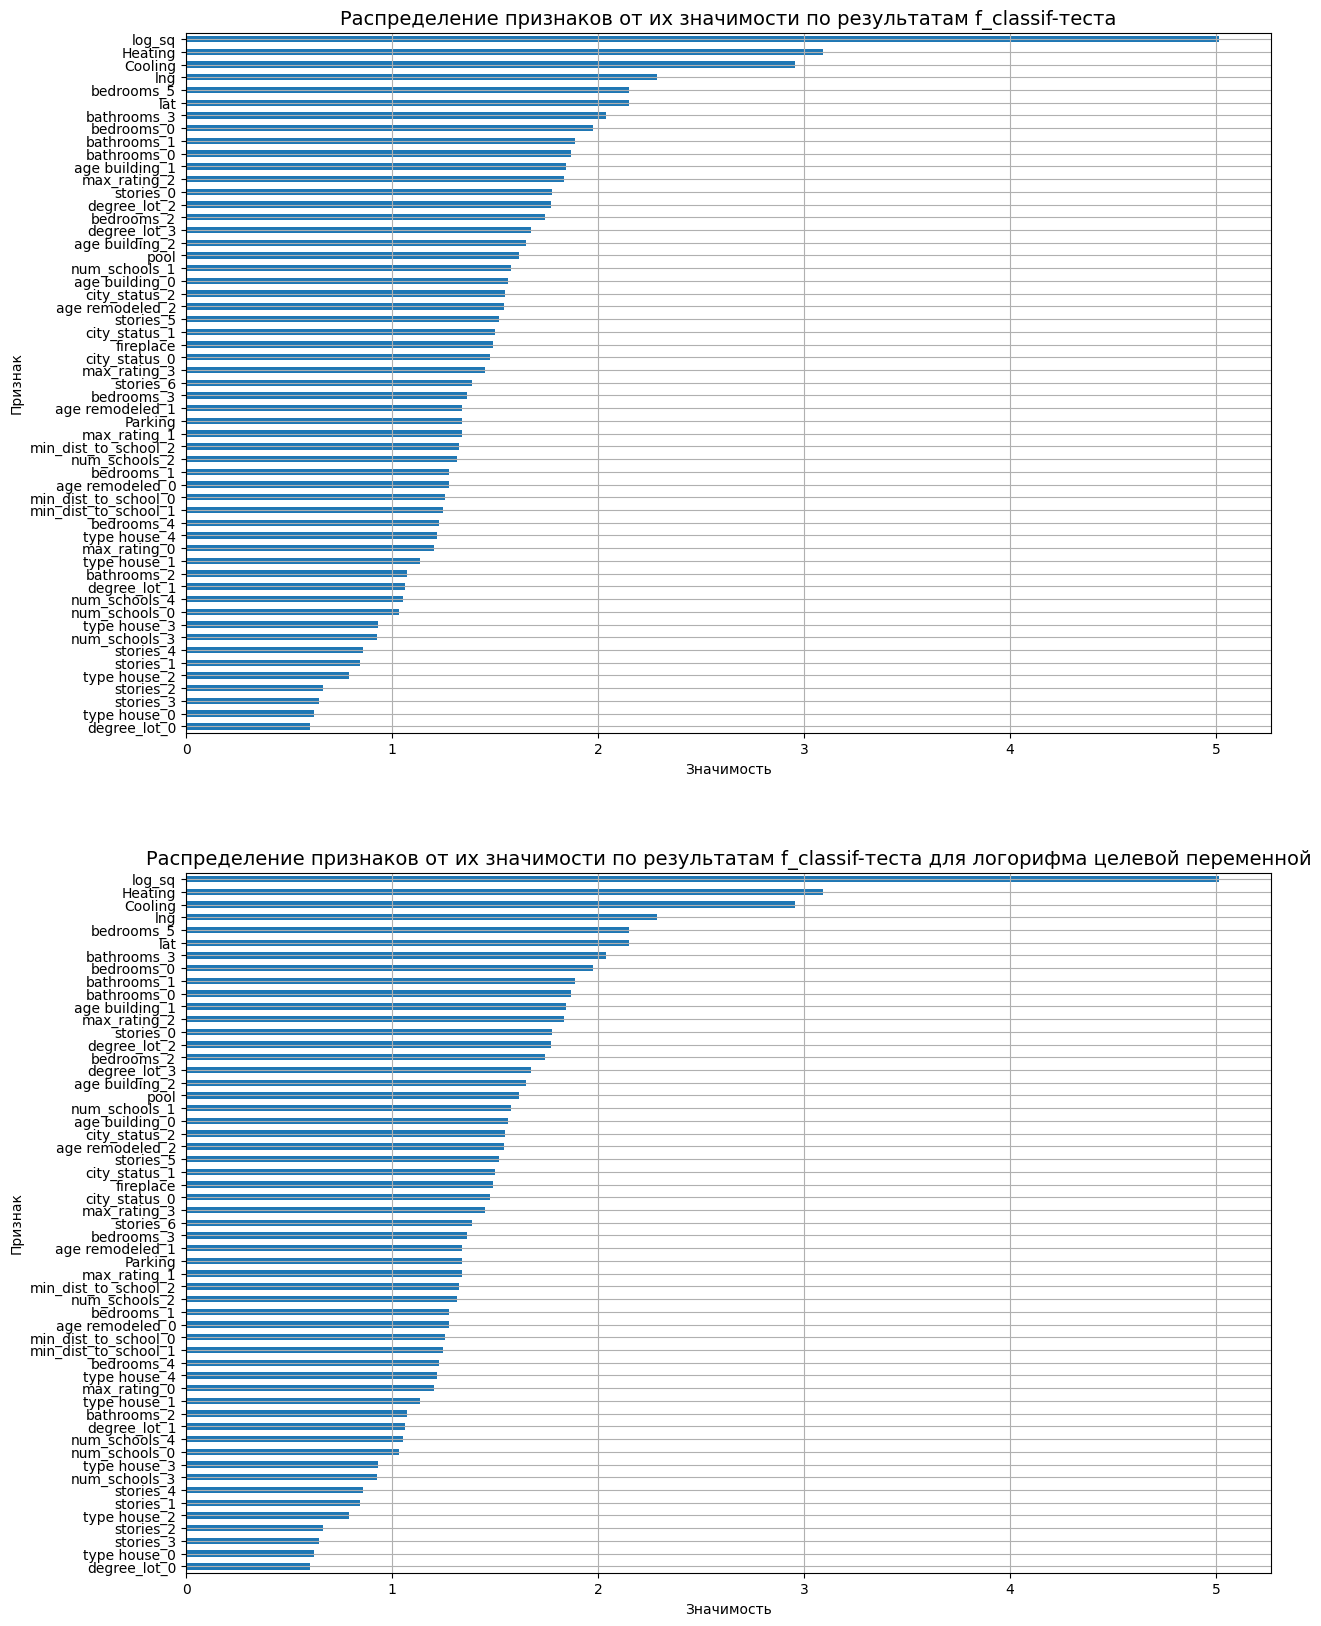

In [146]:
from sklearn.feature_selection import f_classif # anova

imp_num = pd.Series(f_classif(X[col_list].abs(), y['target'])[0], index=col_list)
imp_num.sort_values(inplace = True)
imp_num_log = pd.Series(f_classif(X[col_list].abs(), y['log_targ'])[0], index=col_list)
imp_num_log.sort_values(inplace = True)

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(14, 20))
imp_num.plot(kind = 'barh', ax=ax[0])
ax[0].grid()
ax[0].set_title('Распределение признаков от их значимости по результатам f_classif-теста', fontsize=14)
ax[0].set_xlabel('Значимость')
ax[0].set_ylabel('Признак')
imp_num_log.plot(kind = 'barh', ax=ax[1])
ax[1].grid()
ax[1].set_title('Распределение признаков от их значимости по результатам f_classif-теста для логорифма целевой переменной', fontsize=14)
ax[1].set_xlabel('Значимость')
ax[1].set_ylabel('Признак');
fig = ax[0].figure
fig.savefig('pic/pic25.png')

Разделим данные на обучающую и тестовую выборки

In [147]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Разделим данные на целевую переменную и её логарифм
y_train1 = y_train['target']
y_test1 = y_test['target']
y_train_log = y_train['log_targ']
y_test_log = y_test['log_targ']

6.1 Линейная регрессия

Начнем с простой модели - линейная регрессия

В качестве метрик будем использовать среднюу абсолютную ошибку, среднюу абсолютную ошибку в процентах и R2 для определения качества модели.

Для начала попробуем предсказать непосредственно саму целевую переменную

In [148]:
lg = LinearRegression()
lg.fit(X_train, y_train1)

y_lg_train_pred = lg.predict(X_train)
y_lg_test_pred = lg.predict(X_test)

print('r2_score на обучающем наборе: {:.3f}'.format(metrics.r2_score(y_train1, y_lg_train_pred)))
print('MAE на обучающем наборе: {:.2f}'.format(metrics.mean_absolute_error(y_train1, y_lg_train_pred)))
print('MAPE на обучающем наборе: {:.2f} %'.format(metrics.mean_absolute_percentage_error(y_train1, y_lg_train_pred)))

print('r2_score на тестовом наборе: {:.3f}'.format(metrics.r2_score(y_test1, y_lg_test_pred)))
print('MAE на тестовом наборе: {:.2f}'.format(metrics.mean_absolute_error(y_test1, y_lg_test_pred)))
print('MAPE на тестовом наборе: {:.2f} %'.format(metrics.mean_absolute_percentage_error(y_test1, y_lg_test_pred)))

r2_score на обучающем наборе: 0.182
MAE на обучающем наборе: 515046.17
MAPE на обучающем наборе: 26.08 %
r2_score на тестовом наборе: 0.177
MAE на тестовом наборе: 514253.11
MAPE на тестовом наборе: 15.84 %


Не особо впечатляет.

Попробуем предсказать логарифм целевой переменной, а после переведем его в нормальное значение

In [149]:
lg_log = LinearRegression()
lg_log.fit(X_train, y_train_log)

y_lg_log_train_pred = lg_log.predict(X_train)
y_lg_log_test_pred = lg_log.predict(X_test)

print('r2_score на обучающем наборе: {:.3f}'.format(metrics.r2_score(y_train_log, y_lg_log_train_pred)))
print('MAE на обучающем наборе: {:.3f}'.format(metrics.mean_absolute_error(y_train_log, y_lg_log_train_pred)))
print('MAPE на обучающем наборе: {:.3f} %'.format(metrics.mean_absolute_percentage_error(y_train_log, y_lg_log_train_pred)))

print('r2_score на тестовом наборе: {:.3f}'.format(metrics.r2_score(y_test_log, y_lg_log_test_pred)))
print('MAE на тестовом наборе: {:.3f}'.format(metrics.mean_absolute_error(y_test_log, y_lg_log_test_pred)))
print('MAPE на тестовом наборе: {:.3f} %'.format(metrics.mean_absolute_percentage_error(y_test_log, y_lg_log_test_pred)))

print('\nПосле перевода логарифма \n')

y_train_from_lg_log = (10 ** y_lg_log_train_pred) - 1
y_test_from_lg_log = (10 ** y_lg_log_test_pred) - 1

print('r2_score на обучающем наборе: {:.3f}'.format(metrics.r2_score(y_train1, y_train_from_lg_log)))
print('MAE на обучающем наборе: {:.2f}'.format(metrics.mean_absolute_error(y_train1, y_train_from_lg_log)))
print('MAPE на обучающем наборе: {:.2f} %'.format(metrics.mean_absolute_percentage_error(y_train1, y_train_from_lg_log)))

print('r2_score на тестовом наборе: {:.3f}'.format(metrics.r2_score(y_test1, y_test_from_lg_log)))
print('MAE на тестовом наборе: {:.2f}'.format(metrics.mean_absolute_error(y_test1, y_test_from_lg_log)))
print('MAPE на тестовом наборе: {:.2f} %'.format(metrics.mean_absolute_percentage_error(y_test1, y_test_from_lg_log)))

r2_score на обучающем наборе: 0.441
MAE на обучающем наборе: 0.229
MAPE на обучающем наборе: 0.043 %
r2_score на тестовом наборе: 0.432
MAE на тестовом наборе: 0.229
MAPE на тестовом наборе: 0.043 %

После перевода логарифма 

r2_score на обучающем наборе: -3.982
MAE на обучающем наборе: 381607.77
MAPE на обучающем наборе: 10.13 %
r2_score на тестовом наборе: -6.247
MAE на тестовом наборе: 393525.28
MAPE на тестовом наборе: 8.65 %


Значения метрик стали лучше, за исключением R2 после перевода логарифма - они ухудшились

Попробуем использовать полигональное преобразование признаков

In [150]:
poly = PolynomialFeatures(degree=2, include_bias=False)

poly.fit(X_train)
X_train_poly = poly.transform(X_train)
X_test_poly = poly.transform(X_test)

Будем обучать модель линейной регрессии с L2-регуляризацией - RidgeCV

Снова для начала предсказываем целевую переменную

In [151]:
ridge = RidgeCV()
ridge.fit(X_train_poly, y_train1)

y_ridge_train_pred = ridge.predict(X_train_poly)
y_ridge_test_pred = ridge.predict(X_test_poly)

print('r2_score на обучающем наборе: {:.3f}'.format(metrics.r2_score(y_train1, y_ridge_train_pred)))
print('MAE на обучающем наборе: {:.2f}'.format(metrics.mean_absolute_error(y_train1, y_ridge_train_pred)))
print('MAPE на обучающем наборе: {:.2f} %'.format(metrics.mean_absolute_percentage_error(y_train1, y_ridge_train_pred)))

print('r2_score на тестовом наборе: {:.3f}'.format(metrics.r2_score(y_test1, y_ridge_test_pred)))
print('MAE на тестовом наборе: {:.2f}'.format(metrics.mean_absolute_error(y_test1, y_ridge_test_pred)))
print('MAPE на тестовом наборе: {:.2f} %'.format(metrics.mean_absolute_percentage_error(y_test1, y_ridge_test_pred)))

r2_score на обучающем наборе: 0.511
MAE на обучающем наборе: 433066.98
MAPE на обучающем наборе: 8.41 %
r2_score на тестовом наборе: 0.407
MAE на тестовом наборе: 441309.07
MAPE на тестовом наборе: 2.29 %


Значительно лучше по сравнению с обычным набором данных

Попробуем предсказать логарифм целевой переменной по полиномиальным признакам

In [152]:
ridge_log = RidgeCV()
ridge_log.fit(X_train_poly, y_train_log)

y_ridge_log_train_pred = ridge_log.predict(X_train_poly)
y_ridge_log_test_pred = ridge_log.predict(X_test_poly)

print('r2_score на обучающем наборе: {:.3f}'.format(metrics.r2_score(y_train_log, y_ridge_log_train_pred)))
print('MAE на обучающем наборе: {:.3f}'.format(metrics.mean_absolute_error(y_train_log, y_ridge_log_train_pred)))
print('MAPE на обучающем наборе: {:.3f} %'.format(metrics.mean_absolute_percentage_error(y_train_log, y_ridge_log_train_pred)))

print('r2_score на тестовом наборе: {:.3f}'.format(metrics.r2_score(y_test_log, y_ridge_log_test_pred)))
print('MAE на тестовом наборе: {:.3f}'.format(metrics.mean_absolute_error(y_test_log, y_ridge_log_test_pred)))
print('MAPE на тестовом наборе: {:.3f} %'.format(metrics.mean_absolute_percentage_error(y_test_log, y_ridge_log_test_pred)))

print('\nПосле перевода логарифма \n')

y_train_from_ridge_log = (10 ** y_ridge_log_train_pred) - 1
y_test_from_ridge_log = (10 ** y_ridge_log_test_pred) - 1

print('r2_score на обучающем наборе: {:.3f}'.format(metrics.r2_score(y_train1, y_train_from_ridge_log)))
print('MAE на обучающем наборе: {:.2f}'.format(metrics.mean_absolute_error(y_train1, y_train_from_ridge_log)))
print('MAPE на обучающем наборе: {:.2f} %'.format(metrics.mean_absolute_percentage_error(y_train1, y_train_from_ridge_log)))

print('r2_score на тестовом наборе: {:.3f}'.format(metrics.r2_score(y_test1, y_test_from_ridge_log)))
print('MAE на тестовом наборе: {:.2f}'.format(metrics.mean_absolute_error(y_test1, y_test_from_ridge_log)))
print('MAPE на тестовом наборе: {:.2f} %'.format(metrics.mean_absolute_percentage_error(y_test1, y_test_from_ridge_log)))

r2_score на обучающем наборе: 0.717
MAE на обучающем наборе: 0.163
MAPE на обучающем наборе: 0.031 %
r2_score на тестовом наборе: 0.706
MAE на тестовом наборе: 0.164
MAPE на тестовом наборе: 0.031 %

После перевода логарифма 

r2_score на обучающем наборе: -2258663.249
MAE на обучающем наборе: 5315241.20
MAPE на обучающем наборе: 29.83 %
r2_score на тестовом наборе: -58873.540
MAE на тестовом наборе: 2301716.20
MAPE на тестовом наборе: 37.03 %


Метрики для предсказания логарифма значительно улучшились, а вот перевод логарифма "пошел не по плану".

6.2 Дерево решений

Используем дерево решений для предсказания целевой переменной. Здесь и далее, оставим саму оптимизацию параметров модели за скобками - будем использовать сразу оптимизированные модели.

In [153]:
tr = DecisionTreeRegressor(max_depth=9, random_state=42)

tr.fit(X_train, y_train1)

y_tr_train_pred = tr.predict(X_train)
y_tr_test_pred = tr.predict(X_test)

print('r2_score на обучающем наборе: {:.3f}'.format(metrics.r2_score(y_train1, y_tr_train_pred)))
print('MAE на обучающем наборе: {:.3f}'.format(metrics.mean_absolute_error(y_train1, y_tr_train_pred)))
print('MAPE на обучающем наборе: {:.3f} %'.format(metrics.mean_absolute_percentage_error(y_train1, y_tr_train_pred)))

print('r2_score на тестовом наборе: {:.3f}'.format(metrics.r2_score(y_test1, y_tr_test_pred)))
print('MAE на тестовом наборе: {:.3f}'.format(metrics.mean_absolute_error(y_test1, y_tr_test_pred)))
print('MAPE на тестовом наборе: {:.3f} %'.format(metrics.mean_absolute_percentage_error(y_test1, y_tr_test_pred)))

r2_score на обучающем наборе: 0.791
MAE на обучающем наборе: 257491.559
MAPE на обучающем наборе: 12.373 %
r2_score на тестовом наборе: 0.302
MAE на тестовом наборе: 283620.814
MAPE на тестовом наборе: 7.604 %


Полученные значения метрик лучше, чем аналогичные для простой линейной регрессии. Если сравнивать с регрессией на полиномиальных признаках, то значение MAE улучшилось, MAPE ухудшилось, а r2 лучше для обучающего набора данных, но хуже для тестового.

Попробуем предсказать логарифм цены

In [154]:
tr_log = DecisionTreeRegressor(criterion='squared_error', max_depth=15, random_state=42)

tr_log.fit(X_train, y_train_log)

y_tr_log_train_pred = tr_log.predict(X_train)
y_tr_log_test_pred = tr_log.predict(X_test)

print('r2_score на обучающем наборе: {:.3f}'.format(metrics.r2_score(y_train_log, y_tr_log_train_pred)))
print('MAE на обучающем наборе: {:.3f}'.format(metrics.mean_absolute_error(y_train_log, y_tr_log_train_pred)))
print('MAPE на обучающем наборе: {:.3f} %'.format(metrics.mean_absolute_percentage_error(y_train_log, y_tr_log_train_pred)))

print('r2_score на тестовом наборе: {:.3f}'.format(metrics.r2_score(y_test_log, y_tr_log_test_pred)))
print('MAE на тестовом наборе: {:.3f}'.format(metrics.mean_absolute_error(y_test_log, y_tr_log_test_pred)))
print('MAPE на тестовом наборе: {:.3f} %'.format(metrics.mean_absolute_percentage_error(y_test_log, y_tr_log_test_pred)))

print('\nПосле перевода логарифма \n')

y_train_from_tr_log = (10 ** y_tr_log_train_pred) - 1
y_test_from_tr_log = (10 ** y_tr_log_test_pred) - 1

print('r2_score на обучающем наборе: {:.3f}'.format(metrics.r2_score(y_train1, y_train_from_tr_log)))
print('MAE на обучающем наборе: {:.2f}'.format(metrics.mean_absolute_error(y_train1, y_train_from_tr_log)))
print('MAPE на обучающем наборе: {:.2f} %'.format(metrics.mean_absolute_percentage_error(y_train1, y_train_from_tr_log)))

print('r2_score на тестовом наборе: {:.3f}'.format(metrics.r2_score(y_test1, y_test_from_tr_log)))
print('MAE на тестовом наборе: {:.2f}'.format(metrics.mean_absolute_error(y_test1, y_test_from_tr_log)))
print('MAPE на тестовом наборе: {:.2f} %'.format(metrics.mean_absolute_percentage_error(y_test1, y_test_from_tr_log)))

r2_score на обучающем наборе: 0.843
MAE на обучающем наборе: 0.114
MAPE на обучающем наборе: 0.021 %
r2_score на тестовом наборе: 0.742
MAE на тестовом наборе: 0.141
MAPE на тестовом наборе: 0.026 %

После перевода логарифма 

r2_score на обучающем наборе: 0.919
MAE на обучающем наборе: 140368.61
MAPE на обучающем наборе: 3.74 %
r2_score на тестовом наборе: 0.463
MAE на тестовом наборе: 232726.26
MAPE на тестовом наборе: 5.17 %


Использование предсказание логарифма значительно повысило метрики, в том числе и для преобразованных значений.

В дальнейшем будем использовать предсказание логарифма цены, как показала практика - в этом случае получаются более лучшие метрики.

6.3 Бэггинг - случайный лес

Используем более сложную модель

In [155]:
rf = RandomForestRegressor(max_depth=31, n_estimators=100, random_state=42)
rf.fit(X_train, y_train_log)

y_rf_train_pred = rf.predict(X_train)
y_rf_test_pred = rf.predict(X_test)

print('r2_score на обучающем наборе: {:.3f}'.format(metrics.r2_score(y_train_log, y_rf_train_pred)))
print('MAE на обучающем наборе: {:.3f}'.format(metrics.mean_absolute_error(y_train_log, y_rf_train_pred)))
print('MAPE на обучающем наборе: {:.3f} %'.format(metrics.mean_absolute_percentage_error(y_train_log, y_rf_train_pred)))

print('r2_score на тестовом наборе: {:.3f}'.format(metrics.r2_score(y_test_log, y_rf_test_pred)))
print('MAE на тестовом наборе: {:.3f}'.format(metrics.mean_absolute_error(y_test_log, y_rf_test_pred)))
print('MAPE на тестовом наборе: {:.3f} %'.format(metrics.mean_absolute_percentage_error(y_test_log, y_rf_test_pred)))

print('\nПосле перевода логарифма \n')

y_train_from_rf = (10 ** y_rf_train_pred) - 1
y_test_from_rf = (10 ** y_rf_test_pred) - 1

print('r2_score на обучающем наборе: {:.3f}'.format(metrics.r2_score(y_train1, y_train_from_rf)))
print('MAE на обучающем наборе: {:.2f}'.format(metrics.mean_absolute_error(y_train1, y_train_from_rf)))
print('MAPE на обучающем наборе: {:.2f} %'.format(metrics.mean_absolute_percentage_error(y_train1, y_train_from_rf)))

print('r2_score на тестовом наборе: {:.3f}'.format(metrics.r2_score(y_test1, y_test_from_rf)))
print('MAE на тестовом наборе: {:.2f}'.format(metrics.mean_absolute_error(y_test1, y_test_from_rf)))
print('MAPE на тестовом наборе: {:.2f} %'.format(metrics.mean_absolute_percentage_error(y_test1, y_test_from_rf)))

r2_score на обучающем наборе: 0.977
MAE на обучающем наборе: 0.040
MAPE на обучающем наборе: 0.008 %
r2_score на тестовом наборе: 0.844
MAE на тестовом наборе: 0.102
MAPE на тестовом наборе: 0.019 %

После перевода логарифма 

r2_score на обучающем наборе: 0.919
MAE на обучающем наборе: 71955.39
MAPE на обучающем наборе: 0.10 %
r2_score на тестовом наборе: 0.744
MAE на тестовом наборе: 170049.00
MAPE на тестовом наборе: 3.78 %


Использование случайного леса дает значительное улучшение метрик

Рассмотрим какие признаки с точки зрения модели являются более значимыми

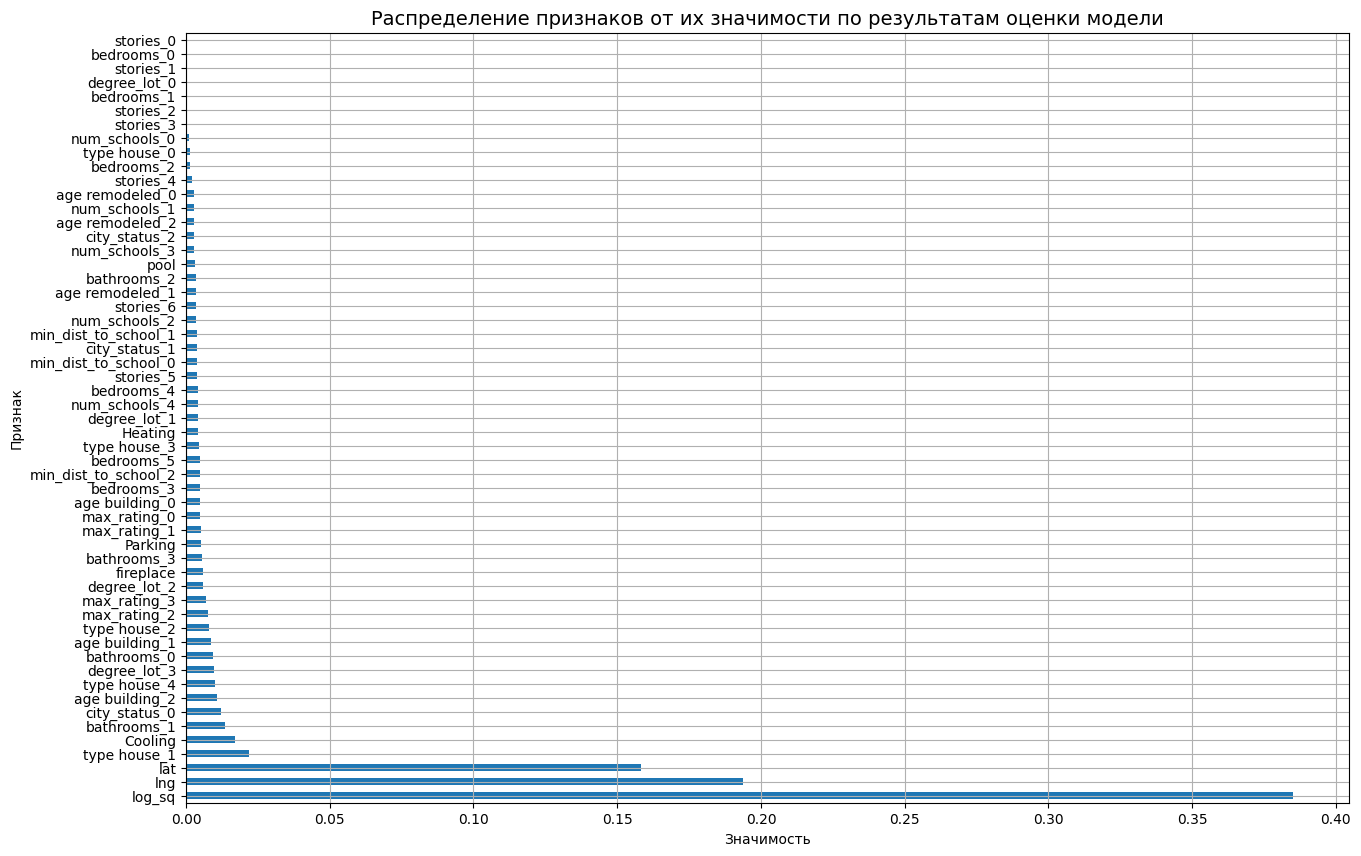

In [156]:
feat_importances = pd.Series(rf.feature_importances_, index=X_train.columns)

fig = plt.figure(figsize=(15,10))
ax = feat_importances.nlargest(X_train.shape[1]).plot(kind='barh')
ax.grid()
ax.set_title('Распределение признаков от их значимости по результатам оценки модели', fontsize=14)
ax.set_xlabel('Значимость')
ax.set_ylabel('Признак');
fig = ax.figure
fig.savefig('pic/pic26.png')

Как и ожидалось, наиболее значимым признаком является площадь. Два других - координаты места, где находится объект.

6.4 Бустинг

Используем градиентный бустинг

In [157]:
gb = GradientBoostingRegressor(random_state=42, learning_rate=0.28, max_depth=12, n_estimators=100)
gb.fit(X_train, y_train_log)
 
y_gb_train_pred = gb.predict(X_train)
y_gb_test_pred = gb.predict(X_test)

print('r2_score на обучающем наборе: {:.3f}'.format(metrics.r2_score(y_train_log, y_gb_train_pred)))
print('MAE на обучающем наборе: {:.3f}'.format(metrics.mean_absolute_error(y_train_log, y_gb_train_pred)))
print('MAPE на обучающем наборе: {:.3f} %'.format(metrics.mean_absolute_percentage_error(y_train_log, y_gb_train_pred)))

print('r2_score на тестовом наборе: {:.3f}'.format(metrics.r2_score(y_test_log, y_gb_test_pred)))
print('MAE на тестовом наборе: {:.3f}'.format(metrics.mean_absolute_error(y_test_log, y_gb_test_pred)))
print('MAPE на тестовом наборе: {:.3f} %'.format(metrics.mean_absolute_percentage_error(y_test_log, y_gb_test_pred)))

print('\nПосле перевода логарифма \n')

y_train_from_gb = (10 ** y_gb_train_pred) - 1
y_test_from_gb = (10 ** y_gb_test_pred) - 1

print('r2_score на обучающем наборе: {:.3f}'.format(metrics.r2_score(y_train1, y_train_from_gb)))
print('MAE на обучающем наборе: {:.2f}'.format(metrics.mean_absolute_error(y_train1, y_train_from_gb)))
print('MAPE на обучающем наборе: {:.2f} %'.format(metrics.mean_absolute_percentage_error(y_train1, y_train_from_gb)))

print('r2_score на тестовом наборе: {:.3f}'.format(metrics.r2_score(y_test1, y_test_from_gb)))
print('MAE на тестовом наборе: {:.2f}'.format(metrics.mean_absolute_error(y_test1, y_test_from_gb)))
print('MAPE на тестовом наборе: {:.2f} %'.format(metrics.mean_absolute_percentage_error(y_test1, y_test_from_gb)))

r2_score на обучающем наборе: 0.962
MAE на обучающем наборе: 0.058
MAPE на обучающем наборе: 0.011 %
r2_score на тестовом наборе: 0.846
MAE на тестовом наборе: 0.105
MAPE на тестовом наборе: 0.020 %

После перевода логарифма 

r2_score на обучающем наборе: 0.983
MAE на обучающем наборе: 74858.10
MAPE на обучающем наборе: 0.14 %
r2_score на тестовом наборе: 0.723
MAE на тестовом наборе: 173883.80
MAPE на тестовом наборе: 1.18 %


В сравнении со случайным лесом для метрик MAE и R2 наблюдается незначительное изменений, а вот MAPE уменьшилось практически в 3 раза для тестового набора данных. 

6.5 Стекинг

Воспользуемся стекингом, т.е. будем "читерить" - попытаемся улучшить метрики.

Воспользуемся моделями, которые использовали ранее, а в качестве финальной используем случайный лес.

In [158]:
estimators = [('lr', LinearRegression()), ('dt',  DecisionTreeRegressor(max_depth=13,random_state=42)), ('gb', GradientBoostingRegressor(random_state=42, learning_rate=0.2, max_depth=14, n_estimators=30))]

stack = StackingRegressor(estimators=estimators,final_estimator=RandomForestRegressor(max_depth=9, n_estimators=100, random_state=42))

stack.fit(X_train, y_train_log)

y_stack_train_pred = stack.predict(X_train)
y_stack_test_pred = stack.predict(X_test)

print('r2_score на обучающем наборе: {:.3f}'.format(metrics.r2_score(y_train_log, y_stack_train_pred)))
print('MAE на обучающем наборе: {:.3f}'.format(metrics.mean_absolute_error(y_train_log, y_stack_train_pred)))
print('MAPE на обучающем наборе: {:.3f} %'.format(metrics.mean_absolute_percentage_error(y_train_log, y_stack_train_pred)))


print('r2_score на тестовом наборе: {:.3f}'.format(metrics.r2_score(y_test_log, y_stack_test_pred)))
print('MAE на тестовом наборе: {:.3f}'.format(metrics.mean_absolute_error(y_test_log, y_stack_test_pred)))
print('MAPE на тестовом наборе: {:.3f} %'.format(metrics.mean_absolute_percentage_error(y_test_log, y_stack_test_pred)))

print('\nПосле перевода логарифма \n')

y_train_from_stack = (10 ** y_stack_train_pred) - 1
y_test_from_stack = (10 ** y_stack_test_pred) - 1

print('r2_score на обучающем наборе: {:.3f}'.format(metrics.r2_score(y_train1, y_train_from_stack)))
print('MAE на обучающем наборе: {:.2f}'.format(metrics.mean_absolute_error(y_train1, y_train_from_stack)))
print('MAPE на обучающем наборе: {:.2f} %'.format(metrics.mean_absolute_percentage_error(y_train1, y_train_from_stack)))

print('r2_score на тестовом наборе: {:.3f}'.format(metrics.r2_score(y_test1, y_test_from_stack)))
print('MAE на тестовом наборе: {:.2f}'.format(metrics.mean_absolute_error(y_test1, y_test_from_stack)))
print('MAPE на тестовом наборе: {:.2f} %'.format(metrics.mean_absolute_percentage_error(y_test1, y_test_from_stack)))

r2_score на обучающем наборе: 0.949
MAE на обучающем наборе: 0.064
MAPE на обучающем наборе: 0.012 %
r2_score на тестовом наборе: 0.846
MAE на тестовом наборе: 0.105
MAPE на тестовом наборе: 0.020 %

После перевода логарифма 

r2_score на обучающем наборе: 0.940
MAE на обучающем наборе: 84136.32
MAPE на обучающем наборе: 0.16 %
r2_score на тестовом наборе: 0.732
MAE на тестовом наборе: 174399.20
MAPE на тестовом наборе: 0.47 %


Наблюдается незначительное ухудшение метрик на тренировочном наборе по сравнению со случайным лесом и бустингом, но при этом имеет место быть увеличение R2 по сравнению с бустингом и наиболее лучшие значения MAPE на тестовом наборе.

### 7. Результаты:
1. Получены три модели с наиболее оптимальными метриками.
2. Наиболее оптимальной считаю модель градиентного бустинга - значение MAE на уровне случайного леса, а MAPE значительно лучше.
3. Наименьшее значение MAPE получено на модели стекинга - 0.47 % на тестовой выборке.

### 8. Выводы:
1. Нами был получен данные по объектам недвижимости, содержащие большое количество пропусков и ошибок. Была проведена работа по преобразованию признаков, исправлению ошибок и заполнению пропусков
2. Проведен анализ переданных данных:
* Показана зависимость цены объекта и площади
* Предложена идея предсказания не полной цены объекта, а предсказания цены за квадратный фут
* Предсказана сильная зависимость цены от площади.
3. Обучены модели:
* Из простых моделей с предсказанием лучше справилась модель дерева решений
* Из ансамблей - градиентный спуск и стэкинг на основе линейной регрессии, дерева решений и градиентного бустинга, финальная модель - случайный лес. 